# Kaggle Housing price prediction - Exploratory Data Analysis


Import packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV


Import Data

In [2]:
# Read data
housing_train = pd.read_csv('train.csv', sep=',', index_col='Id')
housing_test = pd.read_csv('test.csv', sep=',', index_col='Id')

features = housing_train.columns

# Exploratory Data Analysis

## Define helper functions

In [3]:
def iscat(feature):
    """Decide whether a variable is categorical"""
    if (len(feature.unique())<20 or feature.dtype=='O'):
        return True
    else:
        return False

In [4]:
def sortcat(data, features):
    """Sort features into categorical and continuous groups"""
    cols_cat=[]
    cols_cont=[]
    for feature in features:
        if iscat(data[feature]):
            cols_cat = np.append(cols_cat, feature)
        else:
            cols_cont = np.append(cols_cont, feature)
    return cols_cat, cols_cont

In [5]:
def analyzefeature(feature, feature2=None):
    plt.figure(figsize=(18, 6))
    housing = pd.concat([housing_train, housing_test], axis=0, sort=False)
    housing[[feature]].info()
    if iscat(housing_train[feature]):
        print(feature + " is categorical")
        plt.subplot(1, 2, 1)
        y1 = (housing[feature].fillna('Missing')).value_counts(sort=True)
        x = np.arange(0, len(y1))
        sns.barplot(x, y1.values)
        plt.xticks(x, y1.index)
        plt.xlabel(feature)
        plt.ylabel("Total (train+test) counts")
        plt.subplot(1, 2, 2)
        sns.boxplot(x=feature, y="SalePrice", hue=feature2, data=housing_train.fillna('Missing'), order=y1.index)
        plt.show()
        return True
    else:
        print(feature + " is continuous")
        plt.subplot(1, 3, 1)
        plt.hist(housing_train[feature], bins=25)
        plt.subplot(1, 3, 2)
        x, y = ecdf(housing_train[feature])
        plt.plot(x, y)
        plt.subplot(1, 3, 3)
        sns.scatterplot(x=feature, y="SalePrice", data=housing_train)
        print(housing_train[[feature, "SalePrice"]].corr())
        plt.show()
        return False

In [6]:
def ecdf(feature):
    x = np.arange(1, len(feature)+1)/len(feature)
    y = np.sort(feature)
    return x, y

In [7]:
def categorize(feature, bns=3, lbls=['1','2','3'], method="mean", fillna=False):
    temp = housing_train[[feature, "SalePrice"]].groupby(feature).agg(method)
    print(temp.head())
    tr, bins = pd.cut(temp["SalePrice"], bins=bns, labels=lbls, retbins=True)
    print(bins)
    print(tr.head())
    fna = tr.value_counts().idxmax()
    if fillna:
        feature_tr = housing_train[feature].map(tr).fillna(fna).astype(str)
        feature_tr_test = housing_test[feature].map(tr).fillna(fna).astype(str)
    else:
        feature_tr = housing_train[feature].map(tr).astype(str)
        feature_tr_test = housing_test[feature].map(tr).astype(str)
    print(feature_tr.head())
    return feature_tr, feature_tr_test

In [8]:
def safelog(array, zeromin=2):
    result = np.empty((len(array),1))
    b = (array!=0)
    result[b,0] = np.log(array[b])
    c = (array==0)
    result[c,0] = result[b,0].min()-zeromin
    return result[:,0]

## Feature selection

In [9]:
# Sort categorical and continuous features
cols_cat, cols_cont = sortcat(housing_train, features)
# Treat the train and test data the same way
housing = pd.concat([housing_train, housing_test], axis=0, sort=False)

#Initialize feature arrays
features_to_drop = []
features_to_normalize = []
features_to_dummies = []

### MSSubClass
Too many features. Correlated with HouseStyle and Age. Drop.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MSSubClass    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
MSSubClass is categorical


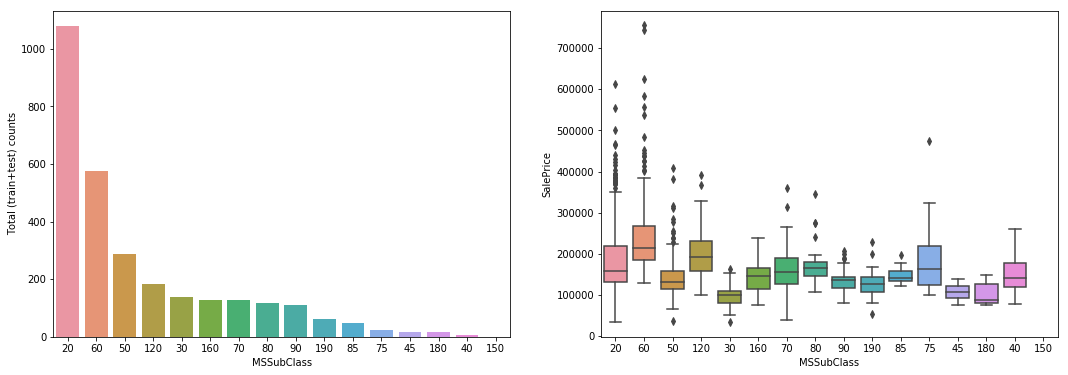

In [10]:
analyzefeature("MSSubClass")

features_to_drop.append("MSSubClass")

### MSZoning
Not much difference between RH and RM, there is only a few RH -> collect them to RMH. Drop original feature. Few missing values. Impute with most probable value = RL.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MSZoning    2915 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
MSZoning is categorical


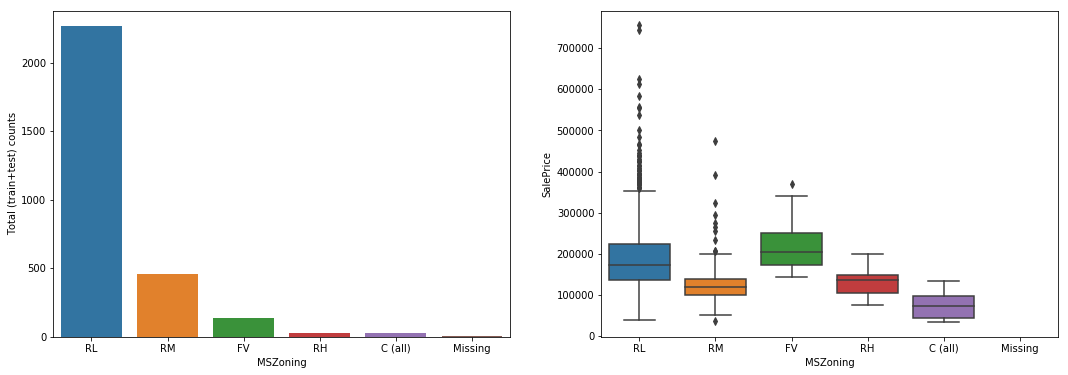

True

In [11]:
analyzefeature("MSZoning")


In [12]:
tr = {"RL": 'RL', "RM": 'RMH', "RH": 'RMH', "FV": "FV", "C (all)": "C"}
housing_train["MSZoning_tr"] = housing_train["MSZoning"].map(tr).fillna("RL")
housing_test["MSZoning_tr"] = housing_test["MSZoning"].map(tr).fillna("RL")

features_to_dummies.append("MSZoning_tr")
features_to_drop.append("MSZoning")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MSZoning_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
MSZoning_tr is categorical


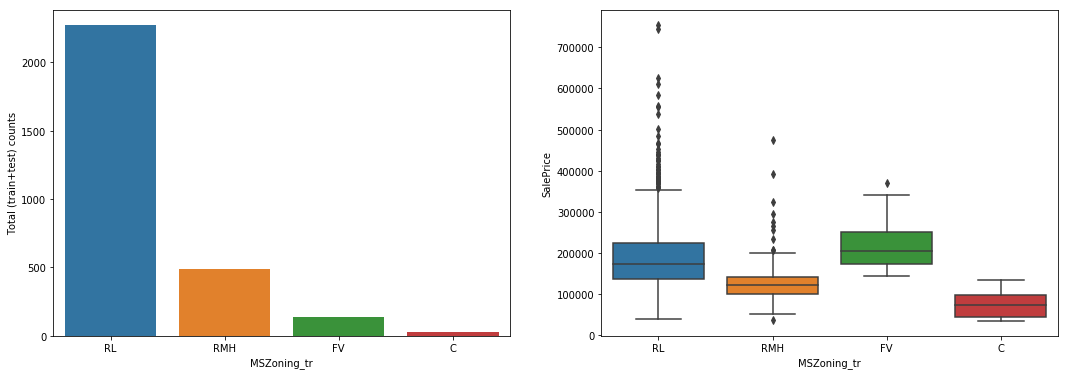

True

In [13]:
analyzefeature("MSZoning_tr")


### LotFrontage

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LotFrontage    2433 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
LotFrontage is continuous
             LotFrontage  SalePrice
LotFrontage     1.000000   0.351799
SalePrice       0.351799   1.000000


C:\Program Files\Python36\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Program Files\Python36\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


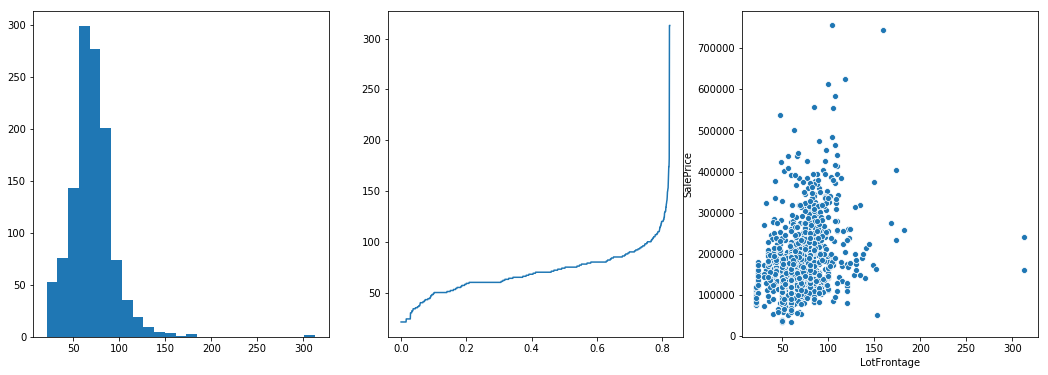

False

In [14]:
analyzefeature("LotFrontage")


Apparently, this feature has a lognormal-type distribution: transform to normal:

In [15]:
housing_train["LogLotFrontage"] = np.log(housing_train["LotFrontage"])
housing_test["LogLotFrontage"] = np.log(housing_test["LotFrontage"])

Check transformed feature distribution:

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LogLotFrontage    2433 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
LogLotFrontage is continuous
                LogLotFrontage  SalePrice
LogLotFrontage        1.000000   0.348745
SalePrice             0.348745   1.000000


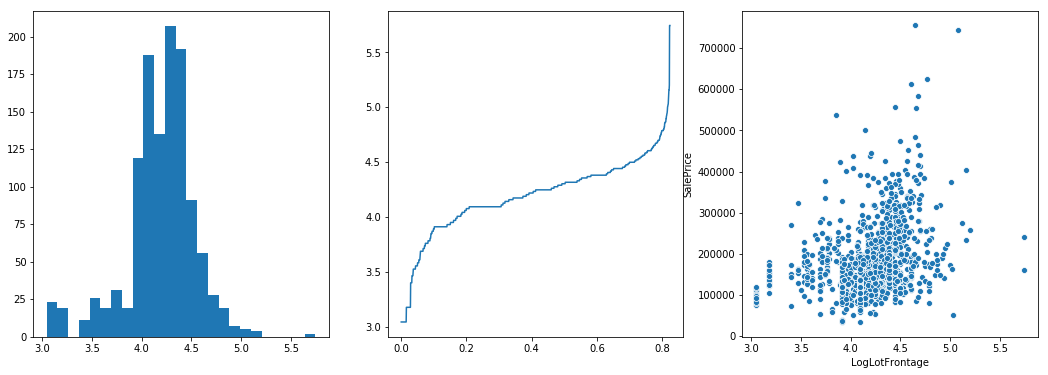

False

In [16]:
analyzefeature("LogLotFrontage")


Distribution is now closer to normal. Feature ready to be normalized. It has a positive correlation with the sale price, so it is reasonable to be kept.

In [17]:
features_to_drop.append("LotFrontage")
features_to_normalize.append("LogLotFrontage")

### LotArea
Same method performed as above.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LotArea    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
LotArea is continuous
            LotArea  SalePrice
LotArea    1.000000   0.263843
SalePrice  0.263843   1.000000


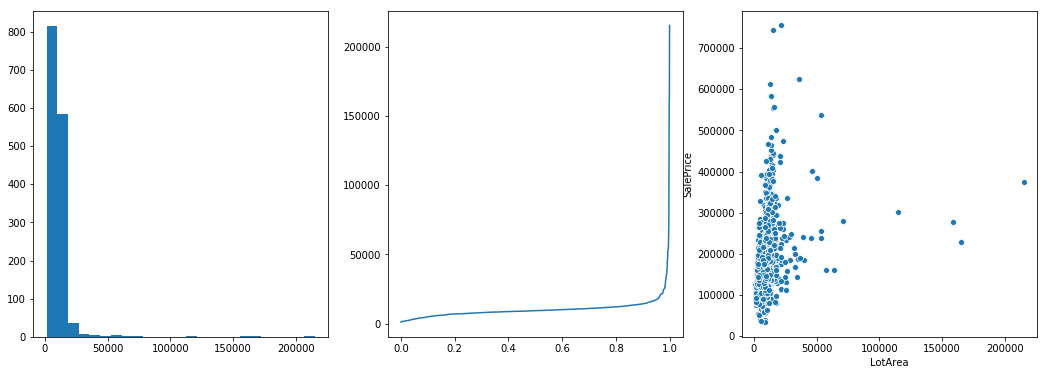

False

In [18]:
analyzefeature("LotArea")


In [19]:
housing_train["LogLotArea"] = np.log(housing_train["LotArea"])
housing_test["LogLotArea"] = np.log(housing_test["LotArea"])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LogLotArea    2919 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
LogLotArea is continuous
            LogLotArea  SalePrice
LogLotArea     1.00000    0.38852
SalePrice      0.38852    1.00000


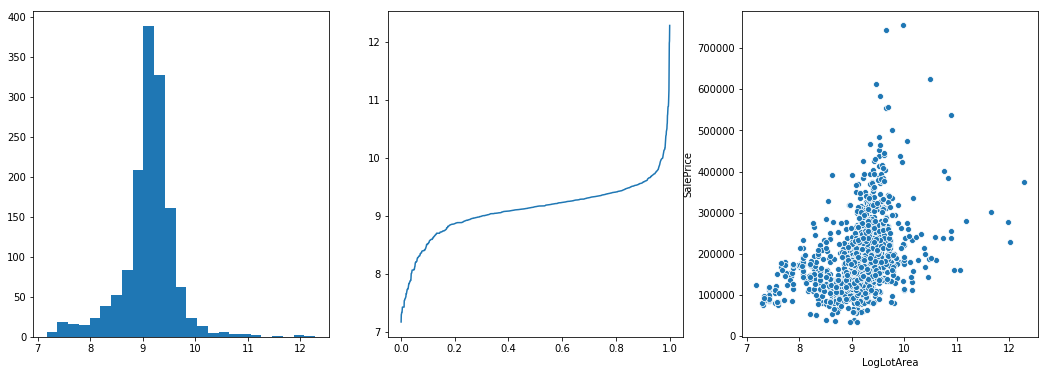

False

In [20]:
analyzefeature("LogLotArea")


In [21]:
features_to_drop.append("LotArea")
features_to_normalize.append("LogLotArea")

### Street: Type of road access to property
       Grvl	Gravel	
       Pave	Paved

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Street    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Street is categorical


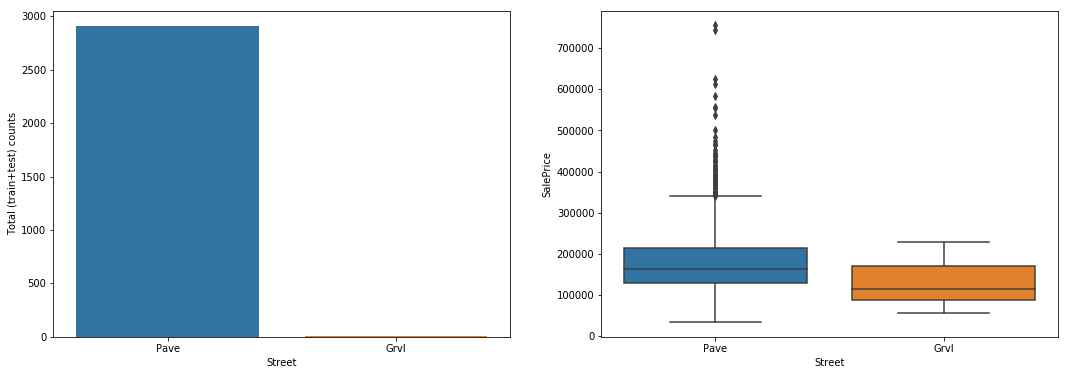

True

In [22]:
analyzefeature("Street")


Even though this feature seems to be significantly affecting the final price, an overwhelming majority of the streets are paved, with very few being gravel. Therefore, this feature is expected to carry only weak predicting power. 

In [23]:
features_to_drop.append("Street")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Alley    198 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Alley is categorical


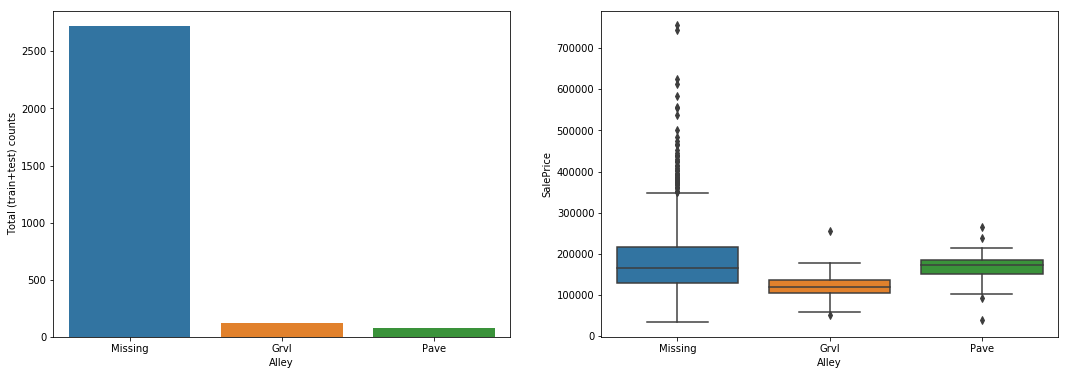

True

In [24]:
analyzefeature("Alley")


This feature might have a strong predicting power, however, most values are missing. The statistics is too small to infer these values, therefore, they will be marked as "missing" as a new category in the prediction.

In [25]:
housing_train["Alley"].fillna("Missing", inplace=True)
housing_test["Alley"].fillna("Missing", inplace=True)
features_to_dummies.append("Alley")

### LotShape
General shape of property

       Reg	Regular	
       IR1	Slightly irregular
       IR2	Moderately Irregular
       IR3	Irregular

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LotShape    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
LotShape is categorical


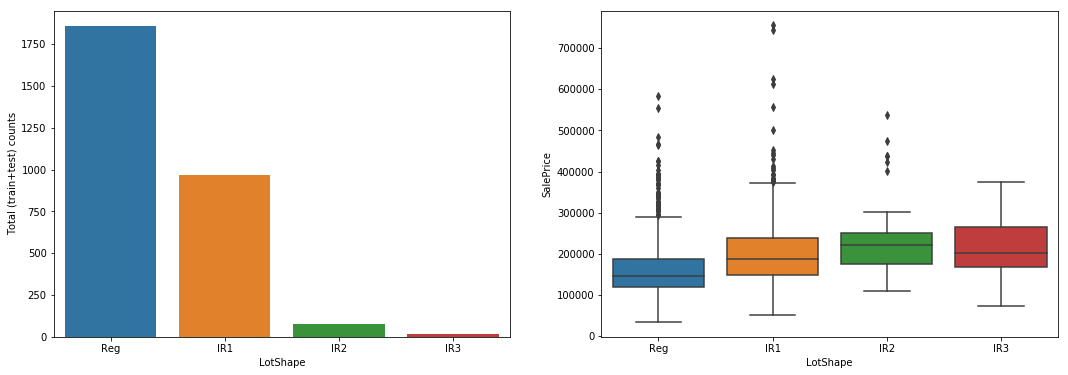

True

In [26]:
analyzefeature("LotShape")


Not too much price difference between IR1/2/3, however, they represent less weight in the distribution. Collect them to a single feature: IR

In [27]:
tr = {"Reg": 'Reg', "IR1": 'IR', "IR2": 'IR', "IR3": "IR"}
housing_train["LotShape_tr"] = housing_train["LotShape"].map(tr)
housing_test["LotShape_tr"] = housing_test["LotShape"].map(tr)

features_to_dummies.append("LotShape_tr")
features_to_drop.append("LotShape")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LotShape_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
LotShape_tr is categorical


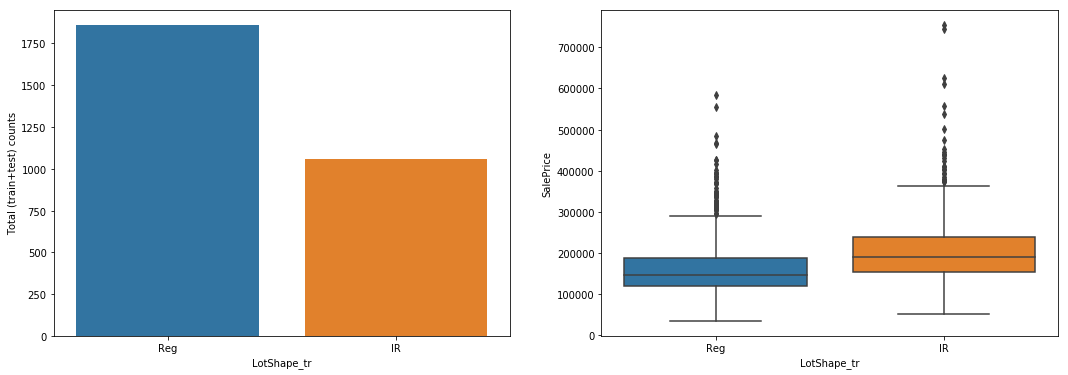

True

In [28]:
analyzefeature("LotShape_tr")


### LandContour : Flatness of the property

       Lvl	Near Flat/Level	
       Bnk	Banked - Quick and significant rise from street grade to building
       HLS	Hillside - Significant slope from side to side
       Low	Depression


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LandContour    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
LandContour is categorical


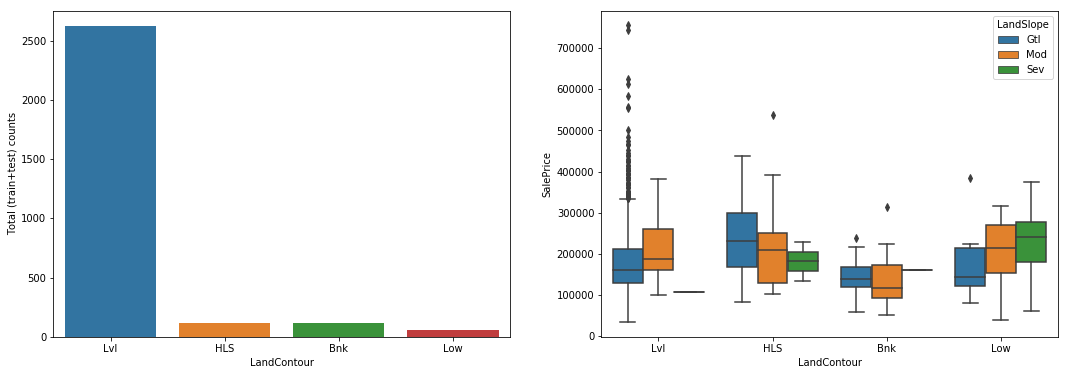

True

In [29]:
analyzefeature("LandContour", "LandSlope")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LandSlope    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
LandSlope is categorical


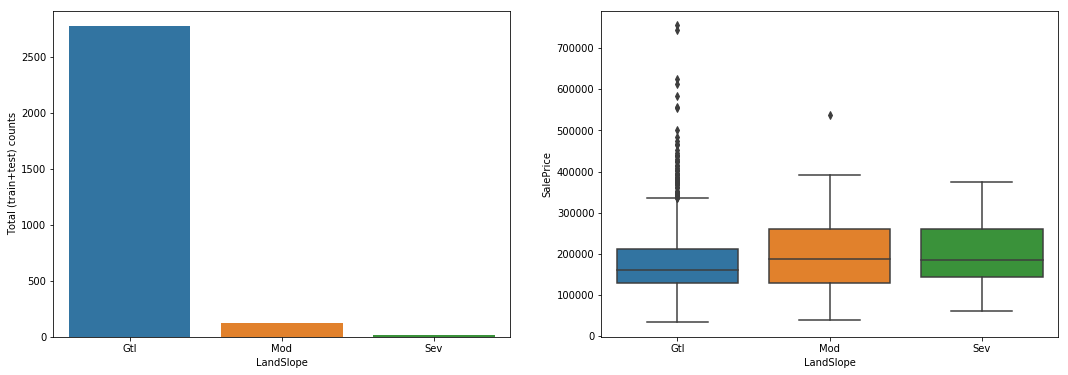

True

In [30]:
analyzefeature("LandSlope")


Check correlation between shape, contour, config and slope

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 4 columns):
LotShape_tr    1460 non-null object
LandContour    1460 non-null object
LotConfig      1460 non-null object
LandSlope      1460 non-null object
dtypes: object(4)
memory usage: 97.0+ KB


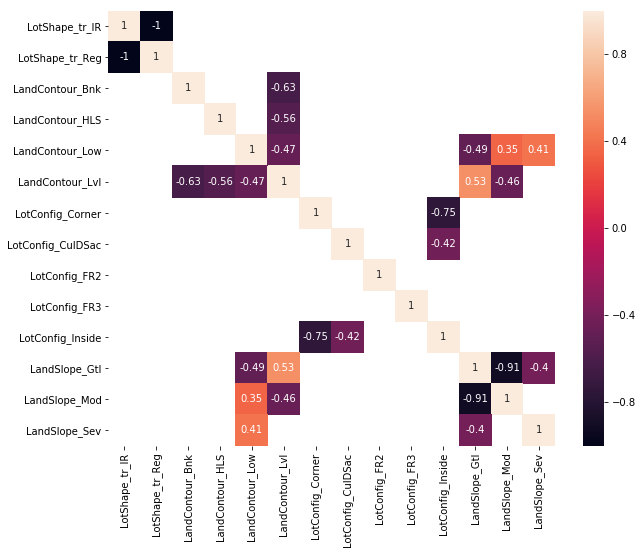

In [31]:
chk_corr_df = housing_train[["LotShape_tr", "LandContour", "LotConfig", "LandSlope"]]
chk_corr_df.info()
corr = pd.get_dummies(chk_corr_df).corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=corr[corr.abs()>0.35], mask=np.isnan(corr[corr.abs()>0.35]))
plt.show()

LandContour and LandSlope are weakly correlated, however, most values are Lvl and Gentle, therefore these features are expected to hold a weak predicting power. Drop

In [32]:
features_to_drop.append("LandContour")
features_to_drop.append("LandSlope")

### Utilities: Type of utilities available
		
       AllPub	All public Utilities (E,G,W,& S)	
       NoSewr	Electricity, Gas, and Water (Septic Tank)
       NoSeWa	Electricity and Gas Only
       ELO	Electricity only

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Utilities    2917 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Utilities is categorical


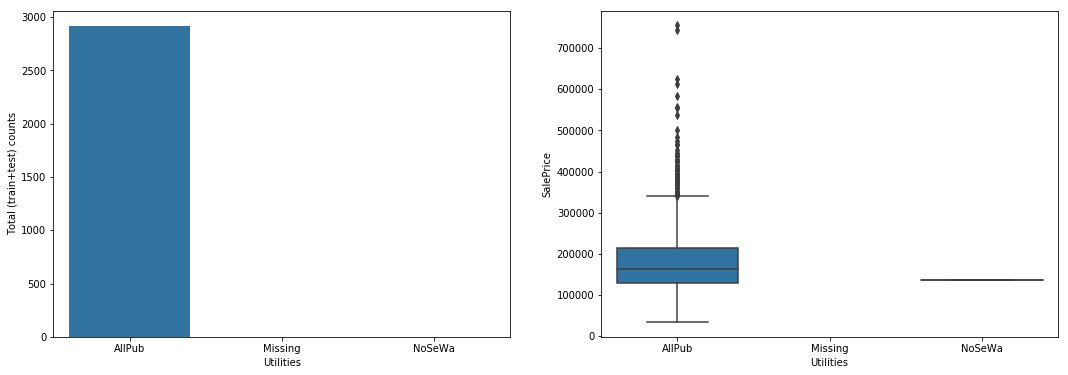

True

In [33]:
analyzefeature("Utilities")


In [34]:
print(housing_train["Utilities"].value_counts())
print(housing_test["Utilities"].value_counts())

AllPub    1459
NoSeWa       1
Name: Utilities, dtype: int64
AllPub    1457
Name: Utilities, dtype: int64


Only one case, where there is no sewer and water. Drop feature.

In [35]:
features_to_drop.append("Utilities")

### LotConfig: Lot configuration

       Inside	Inside lot
       Corner	Corner lot
       CulDSac	Cul-de-sac
       FR2	Frontage on 2 sides of property
       FR3	Frontage on 3 sides of property

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LotConfig    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
LotConfig is categorical


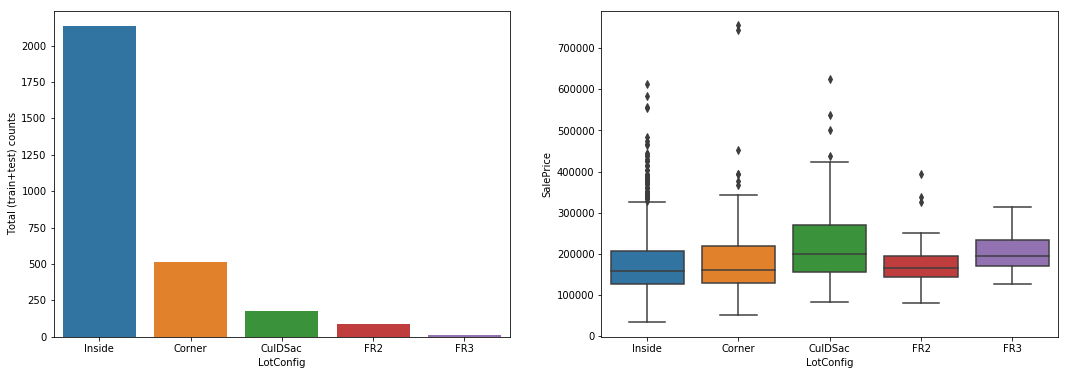

True

In [36]:
analyzefeature("LotConfig")


Mostly inside and corner with similar distribution. This feature will be dropped in the first approximation.

In [37]:
features_to_drop.append("LotConfig")

### Neighborhood: Physical locations within Ames city limits

       

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Neighborhood    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Neighborhood is categorical


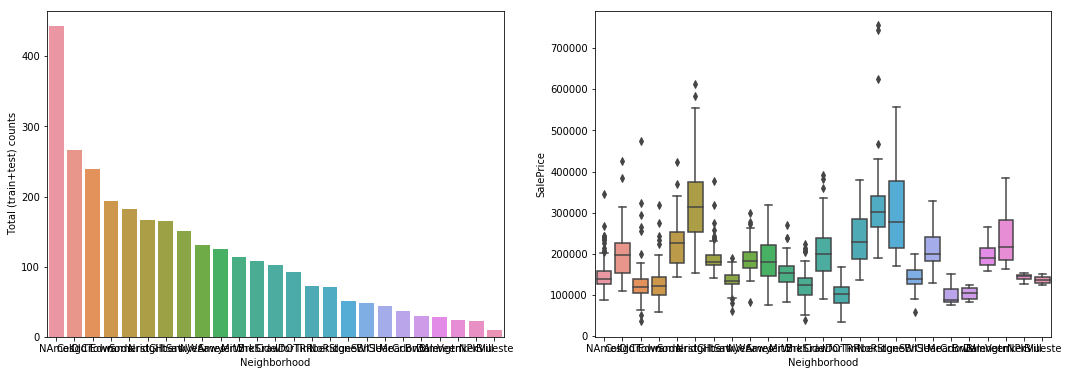

True

In [38]:
analyzefeature("Neighborhood")


Group neighborhood into 3 categories according to the mean price of the sold properties

In [39]:
temp = housing_train[["Neighborhood", "SalePrice"]].groupby("Neighborhood").agg("mean")
print(temp.head())
tr, bins = pd.cut(temp["SalePrice"], 3, labels=['Poor', 'Med', 'Rich'], retbins=True)
print(bins)
print(tr.head())

                  SalePrice
Neighborhood               
Blmngtn       194870.882353
Blueste       137500.000000
BrDale        104493.750000
BrkSide       124834.051724
ClearCr       212565.428571
[ 98339.75174175 177482.75274988 256389.03491153 335295.31707317]
Neighborhood
Blmngtn     Med
Blueste    Poor
BrDale     Poor
BrkSide    Poor
ClearCr     Med
Name: SalePrice, dtype: category
Categories (3, object): [Poor < Med < Rich]


In [40]:
housing_train["Neighborhood_tr"] = housing_train["Neighborhood"].map(tr).astype(str)
housing_test["Neighborhood_tr"] = housing_test["Neighborhood"].map(tr).astype(str)
print(housing_train["Neighborhood_tr"].head())
print(housing_test["Neighborhood_tr"].head())


Id
1     Med
2     Med
3     Med
4     Med
5    Rich
Name: Neighborhood_tr, dtype: object
Id
1461    Poor
1462    Poor
1463     Med
1464     Med
1465    Rich
Name: Neighborhood_tr, dtype: object


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Neighborhood_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Neighborhood_tr is categorical


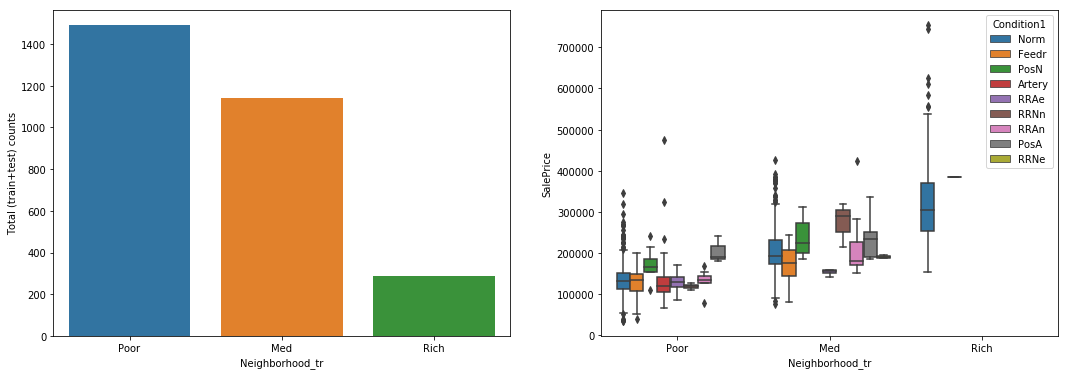

True

In [41]:
analyzefeature("Neighborhood_tr", "Condition1")


Now it seems that these three categories reflect the sale prices well. 

In [42]:
features_to_dummies.append("Neighborhood_tr")
features_to_drop.append("Neighborhood")

### Condition1: Proximity to various conditions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Condition1    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Condition1 is categorical


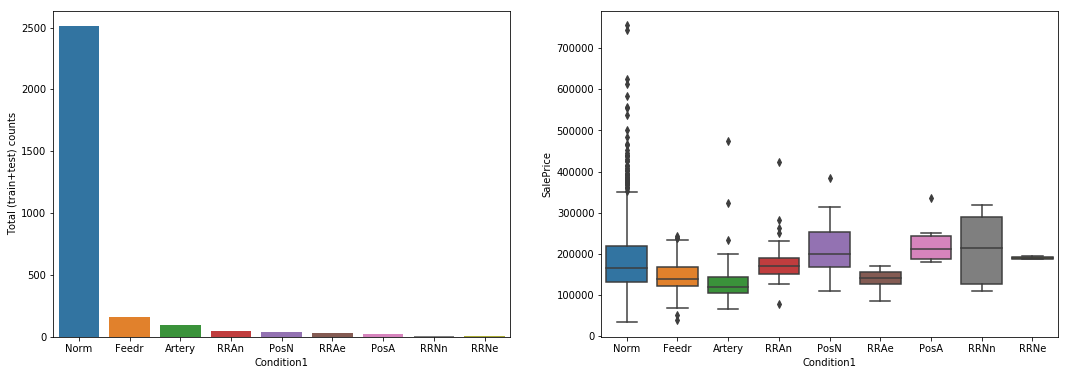

True

In [43]:
analyzefeature("Condition1")


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Condition2    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Condition2 is categorical


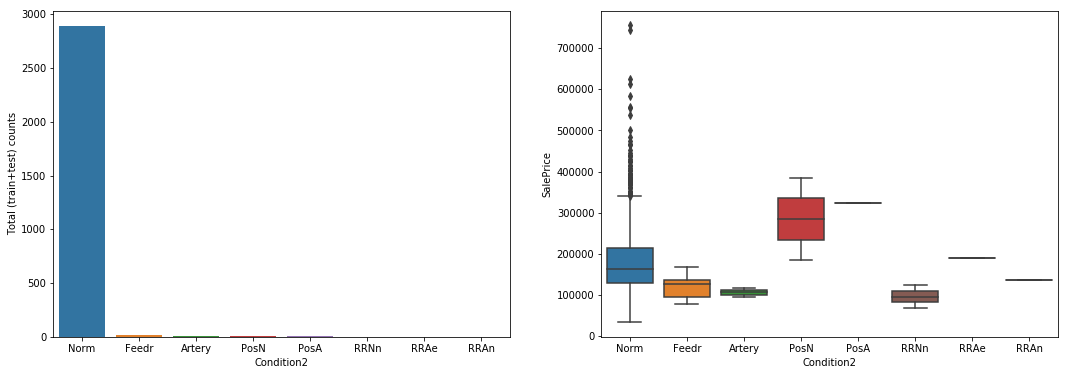

True

In [44]:
analyzefeature("Condition2")


Condition1 and 2: PosA and PosN may significantly influence the price within a certain neighborhood category. Collect these features into a single category:

In [45]:
tr = {"Norm": 0, "Feedr": -1, "Artery": -1, "PosA": 1, "PosN": 1, "RRNn": 0, "RRAn": 0, "RRAe": -1}
housing_train["Condition"] = housing_train["Condition1"].map(tr).fillna(0)+housing_train["Condition2"].map(tr).fillna(0)
housing_test["Condition"] = housing_test["Condition1"].map(tr).fillna(0)+housing_test["Condition2"].map(tr).fillna(0)

In [46]:
housing_train["Condition"].describe()

count    1460.000000
mean       -0.081507
std         0.350561
min        -2.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         2.000000
Name: Condition, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Condition    2919 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
Condition is categorical


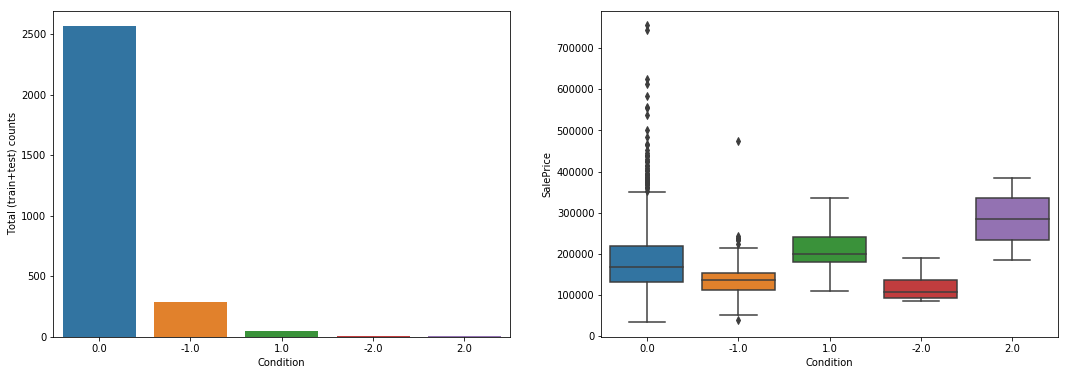

True

In [47]:
analyzefeature("Condition")


Seems to be a weakly predictive feature, but let's keep it for now.

In [48]:
features_to_dummies.append("Condition")
features_to_drop.append("Condition1")
features_to_drop.append("Condition2")

### BldgType: Type of dwelling
		
       1Fam	Single-family Detached	
       2FmCon	Two-family Conversion; originally built as one-family dwelling
       Duplx	Duplex
       TwnhsE	Townhouse End Unit
       TwnhsI	Townhouse Inside Unit

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BldgType    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BldgType is categorical


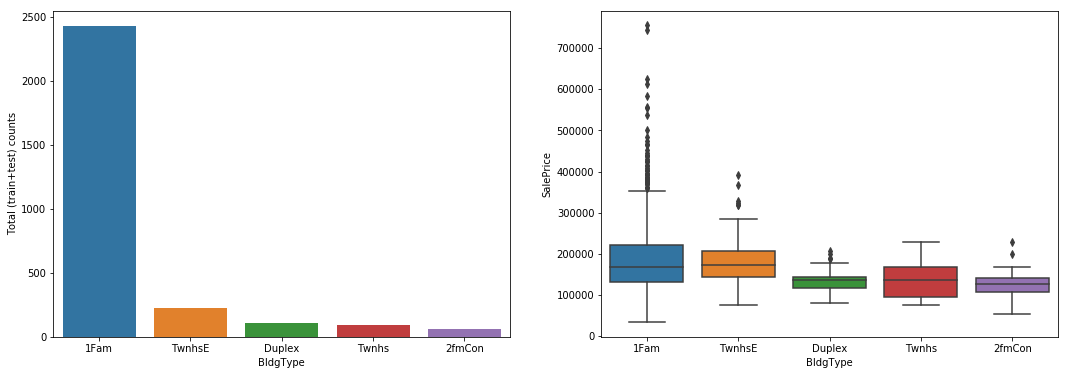

True

In [49]:
analyzefeature("BldgType")


Weakly predictive on its own. May be useful as a modifier feature, but at the moment lets leave it out. 

In [50]:
features_to_drop.append("BldgType")

### HouseStyle: Style of dwelling
	
       1Story	One story
       1.5Fin	One and one-half story: 2nd level finished
       1.5Unf	One and one-half story: 2nd level unfinished
       2Story	Two story
       2.5Fin	Two and one-half story: 2nd level finished
       2.5Unf	Two and one-half story: 2nd level unfinished
       SFoyer	Split Foyer
       SLvl	Split Level

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
HouseStyle    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
HouseStyle is categorical


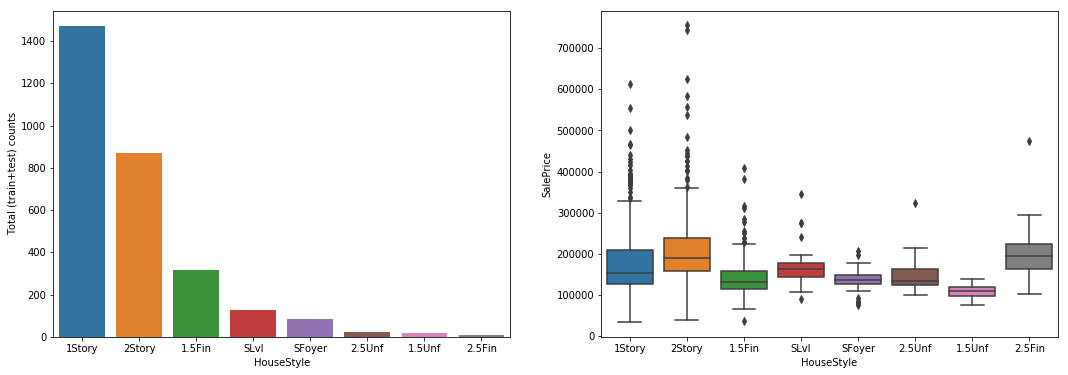

True

In [51]:
analyzefeature("HouseStyle")


It is hard to see the effect from this feature. Let's try to categorize.

In [52]:
tr = {"1Story": "1"}
housing_train["HouseStyle_tr"] = housing_train["HouseStyle"].map(tr).fillna("1+")
housing_test["HouseStyle_tr"] = housing_test["HouseStyle"].map(tr).fillna("1+")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Neighborhood_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Neighborhood_tr is categorical


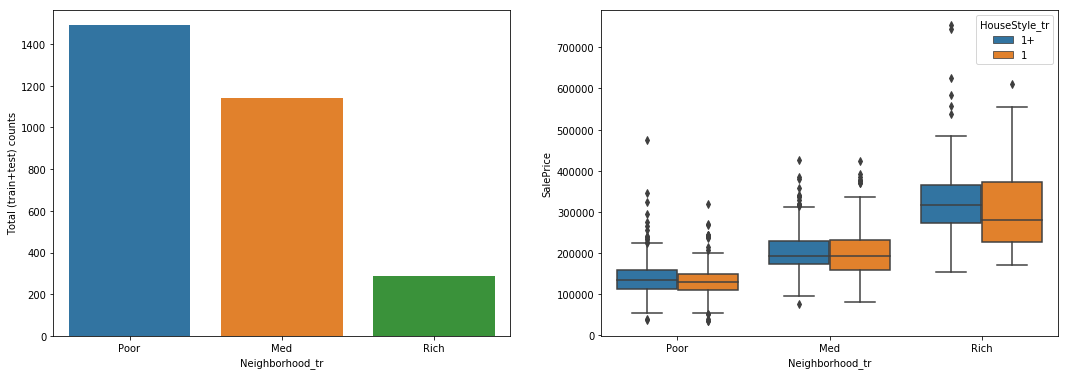

True

In [53]:
analyzefeature("Neighborhood_tr","HouseStyle_tr")


Category is still weak, but may be useful.

In [54]:
features_to_dummies.append("HouseStyle_tr")
features_to_drop.append("HouseStyle")

### OverallQual: Rates the overall material and finish of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average
       5	Average
       4	Below Average
       3	Fair
       2	Poor
       1	Very Poor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
OverallQual    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
OverallQual is categorical


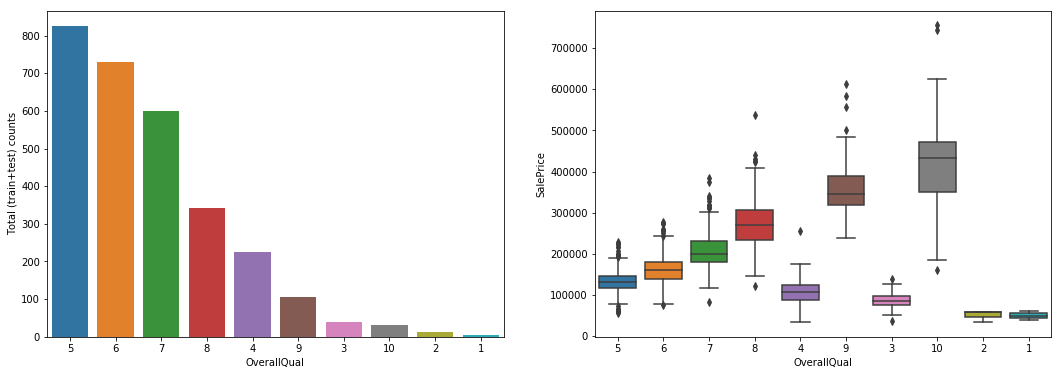

True

In [55]:
analyzefeature("OverallQual")


Quality has an apparent effect on the housing prices. Even though it is a discrete feature, the monotonous dependence allows for keeping it as a continuous feature.

             OverallQual  SalePrice
OverallQual     1.000000   0.790982
SalePrice       0.790982   1.000000


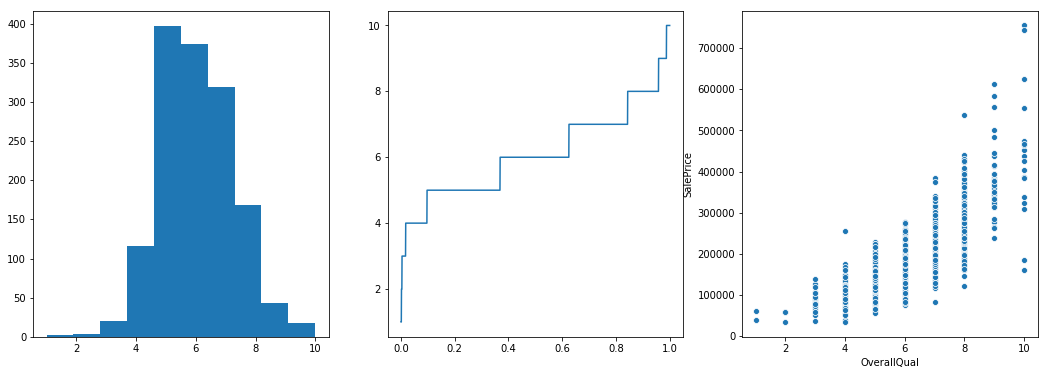

In [56]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(housing_train["OverallQual"], bins=10)
plt.subplot(1, 3, 2)
x, y = ecdf(housing_train["OverallQual"])
plt.plot(x, y)
plt.subplot(1, 3, 3)
sns.scatterplot(x="OverallQual", y="SalePrice", data=housing_train)
print(housing_train[["OverallQual", "SalePrice"]].corr())

In [57]:
features_to_normalize.append("OverallQual")

### OverallCond: Rates the overall condition of the house

       10	Very Excellent
       9	Excellent
       8	Very Good
       7	Good
       6	Above Average	
       5	Average
       4	Below Average	
       3	Fair
       2	Poor
       1	Very Poor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
OverallCond    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
OverallCond is categorical


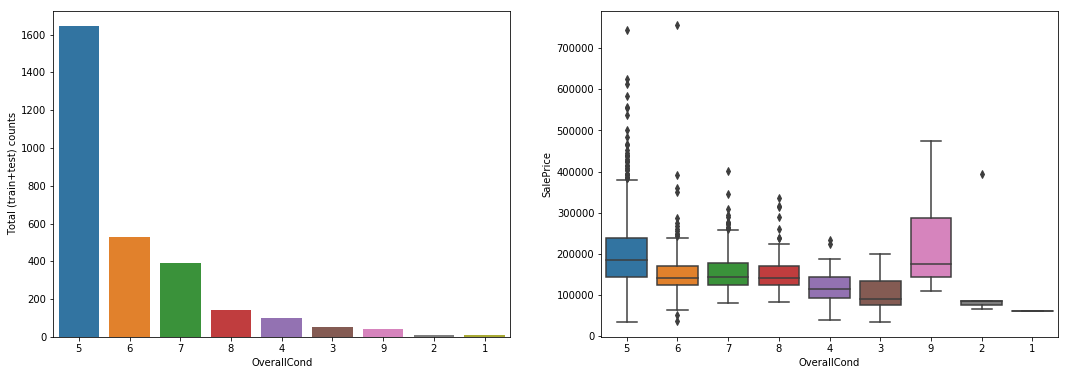

True

In [58]:
analyzefeature("OverallCond")


             OverallCond  SalePrice
OverallCond     1.000000  -0.077856
SalePrice      -0.077856   1.000000


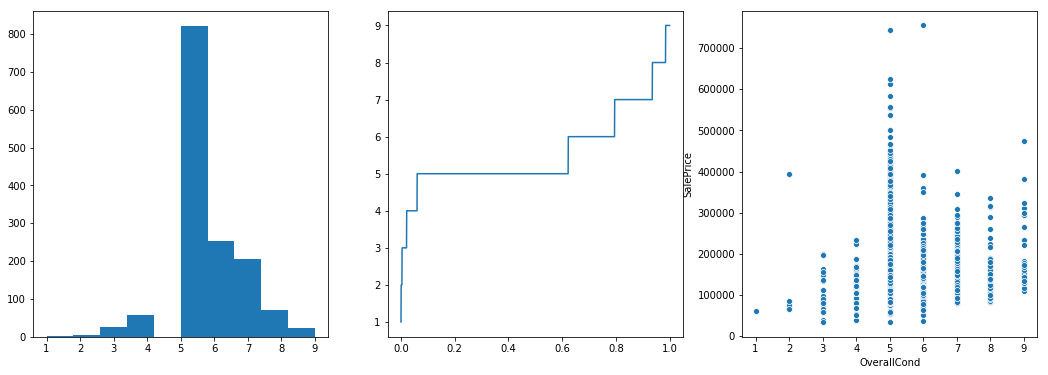

In [59]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.hist(housing_train["OverallCond"], bins=10)
plt.subplot(1, 3, 2)
x, y = ecdf(housing_train["OverallCond"])
plt.plot(x, y)
plt.subplot(1, 3, 3)
sns.scatterplot(x="OverallCond", y="SalePrice", data=housing_train)
print(housing_train[["OverallCond", "SalePrice"]].corr())

In [60]:
print(housing_train[["OverallQual", "OverallCond"]].corr())

             OverallQual  OverallCond
OverallQual     1.000000    -0.091932
OverallCond    -0.091932     1.000000


Correlation between the quality and condition and the sale price is not trivial. Let's drop this one.

In [61]:
features_to_drop.append("OverallCond")

### YearBuilt: Original construction date

YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)

In [62]:
# Convert building/renovation year to age
def tr_age(df):
    df["Age"] = df["YrSold"] - df["YearBuilt"]
    df["RenAge"] = df["YrSold"] - df["YearRemodAdd"]
    df["GarAge"] = df["YrSold"] - df["GarageYrBlt"]
    return df

In [63]:
tr_age(housing_train)
tr_age(housing_test)
features_to_drop.append("YearBuilt")
features_to_drop.append("YearRemodAdd")
features_to_drop.append("GarageYrBlt")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Age    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
Age is continuous
               Age  SalePrice
Age        1.00000   -0.52335
SalePrice -0.52335    1.00000


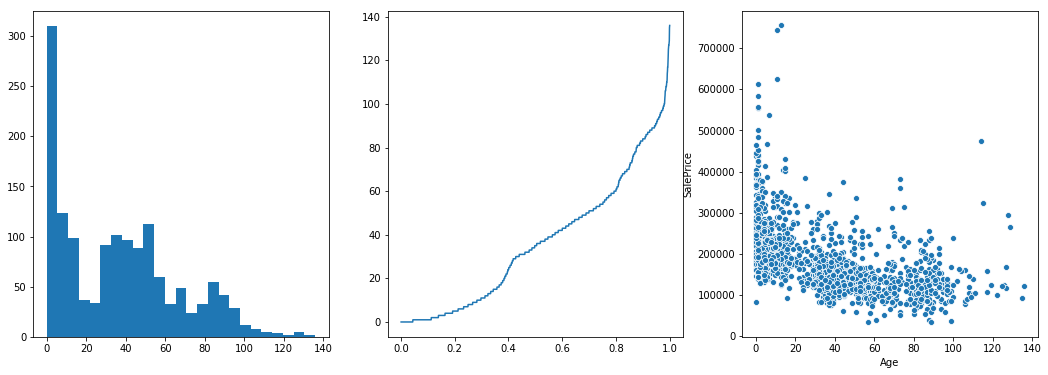

False

In [64]:
analyzefeature("Age")

The negative correlation of the price and age is clear. Keep it as a continuous feature.

In [65]:
features_to_normalize.append("Age")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
RenAge    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
RenAge is continuous
             RenAge  SalePrice
RenAge     1.000000  -0.509079
SalePrice -0.509079   1.000000


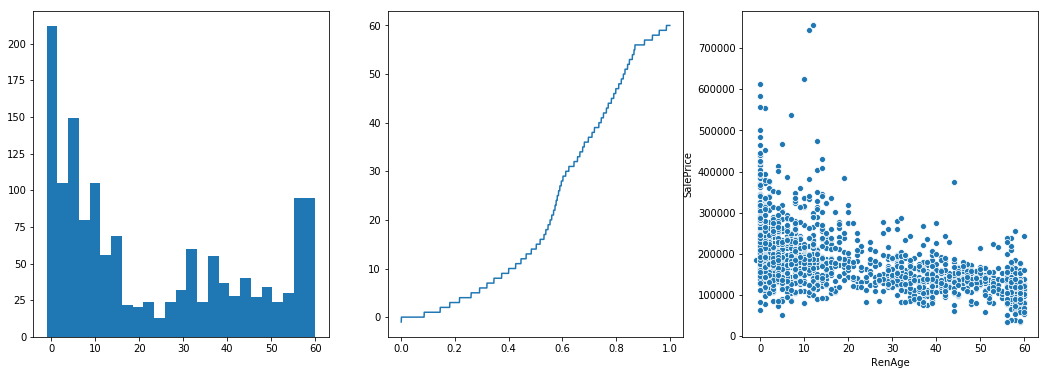

False

In [66]:
analyzefeature("RenAge")

In [67]:
housing_train[["Age", "RenAge"]].corr()

Age    RenAge
Age     1.000000  0.594195
RenAge  0.594195  1.000000

<Figure size 432x288 with 0 Axes>

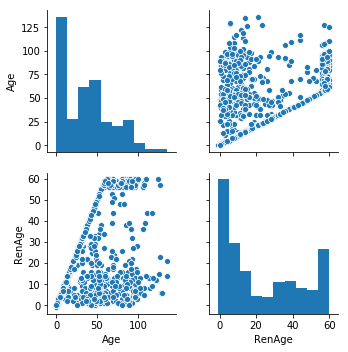

In [68]:
plt.figure()
sns.pairplot(housing_train[["Age", "RenAge"]])

Every house has been renovated at most 60 yrs prior to selling. Yet the correlation of the price with the actual age is stronger. Let's keep this feature as it is now.

In [69]:
features_to_normalize.append("RenAge")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarAge    2760 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
GarAge is continuous
             GarAge  SalePrice
GarAge     1.000000  -0.487069
SalePrice -0.487069   1.000000


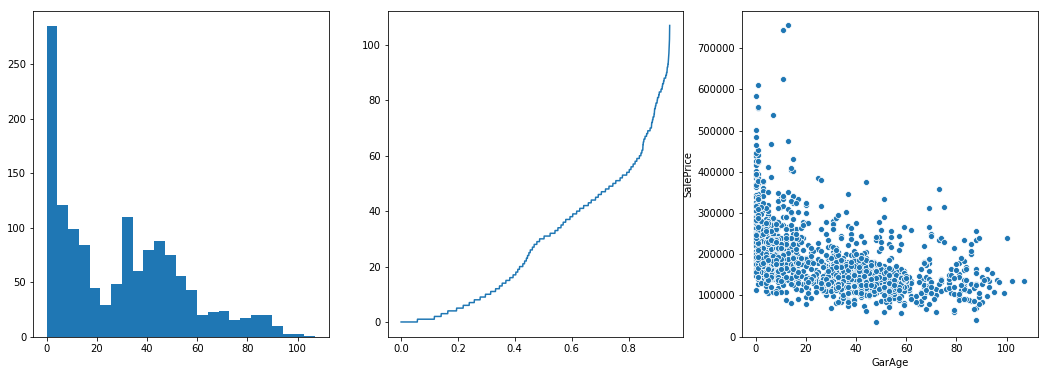

False

In [70]:
analyzefeature("GarAge")

<Figure size 432x288 with 0 Axes>

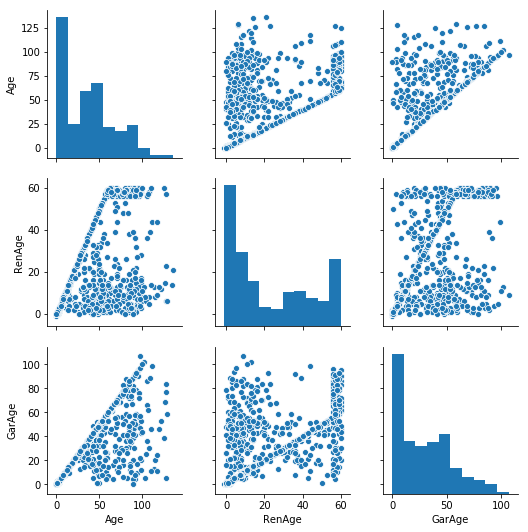

In [71]:
plt.figure()
sns.pairplot(housing_train[["Age", "RenAge", "GarAge"]])

The age of the garage is probably affecting the price through its correlation with the age of the house. Let's drop it.

In [72]:
features_to_drop.append("GarAge")

### RoofStyle: Type of roof

       Flat	Flat
       Gable	Gable
       Gambrel	Gabrel (Barn)
       Hip	Hip
       Mansard	Mansard
       Shed	Shed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
RoofStyle    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
RoofStyle is categorical


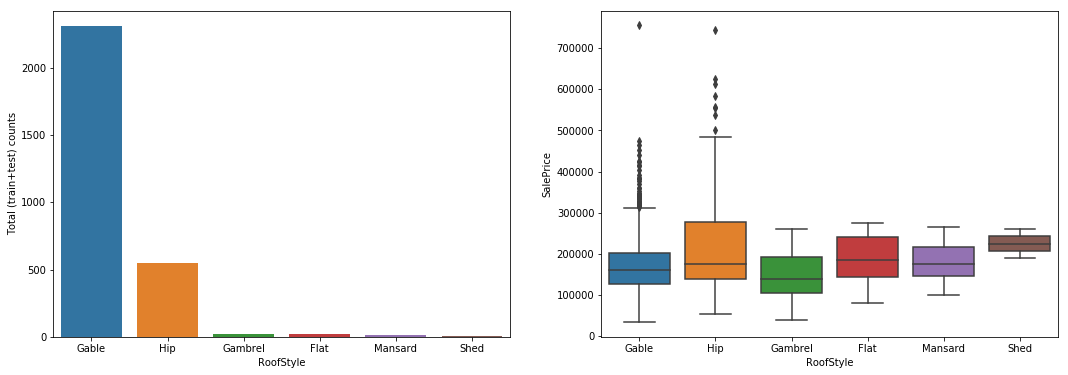

True

In [73]:
analyzefeature("RoofStyle")

No strong effect on price. Drop

In [74]:
features_to_drop.append("RoofStyle")

### RoofMatl: Roof material

       ClyTile	Clay or Tile
       CompShg	Standard (Composite) Shingle
       Membran	Membrane
       Metal	Metal
       Roll	Roll
       Tar&Grv	Gravel & Tar
       WdShake	Wood Shakes
       WdShngl	Wood Shingles

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
RoofMatl    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
RoofMatl is categorical


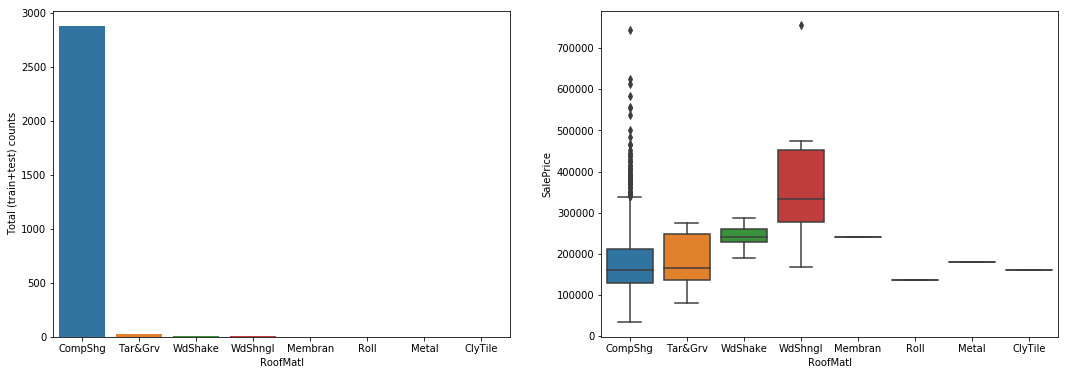

True

In [75]:
analyzefeature("RoofMatl")

In [76]:
housing_train["RoofMatl"].value_counts()

CompShg    1434
Tar&Grv      11
WdShngl       6
WdShake       5
Membran       1
Roll          1
Metal         1
ClyTile       1
Name: RoofMatl, dtype: int64

In [77]:
housing_test["RoofMatl"].value_counts()

CompShg    1442
Tar&Grv      12
WdShake       4
WdShngl       1
Name: RoofMatl, dtype: int64

no use to insert this feature, because of the rarity of other types than CompShg

In [78]:
features_to_drop.append("RoofMatl")

### Exterior1st: Exterior covering on house

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Exterior1st    2918 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Exterior1st is categorical


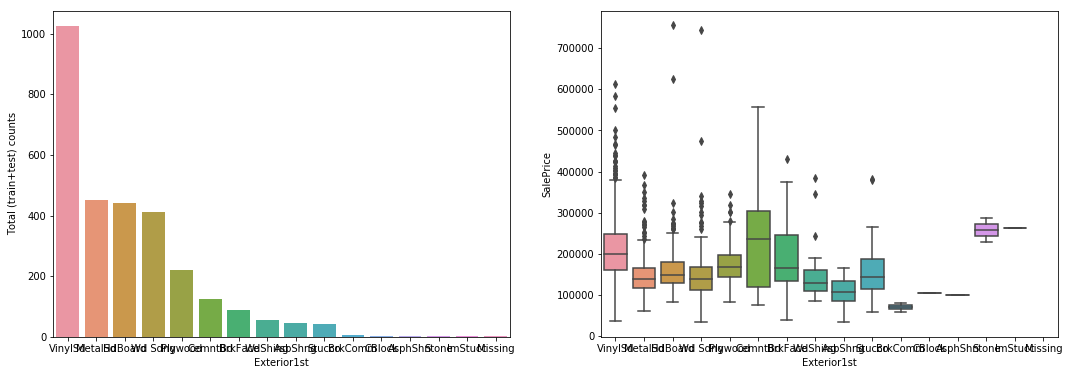

True

In [79]:
analyzefeature("Exterior1st")

This property seems to affect the price. Create 3 categories to reduce dimensionality

In [80]:
temp = housing_train[["Exterior1st", "SalePrice"]].groupby("Exterior1st").agg("mean")
print(temp.head())
tr, bins = pd.cut(temp["SalePrice"], 3, labels=['Chp', 'Med', 'Exp'], retbins=True)
print(bins)
print(tr.head())

             SalePrice
Exterior1st           
AsbShng      107385.55
AsphShn      100000.00
BrkComm       71000.00
BrkFace      194573.00
CBlock       105000.00
[ 70809.         134666.66666667 198333.33333333 262000.        ]
Exterior1st
AsbShng    Chp
AsphShn    Chp
BrkComm    Chp
BrkFace    Med
CBlock     Chp
Name: SalePrice, dtype: category
Categories (3, object): [Chp < Med < Exp]


In [81]:
housing_train["Ext1_tr"] = housing_train["Exterior1st"].map(tr).fillna("Med").astype(str)
housing_test["Ext1_tr"] = housing_test["Exterior1st"].map(tr).fillna("Med").astype(str)
print(housing_train["Ext1_tr"].head())
print(housing_test["Ext1_tr"].head())

Id
1    Exp
2    Med
3    Exp
4    Med
5    Exp
Name: Ext1_tr, dtype: object
Id
1461    Exp
1462    Med
1463    Exp
1464    Exp
1465    Med
Name: Ext1_tr, dtype: object


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Ext1_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Ext1_tr is categorical


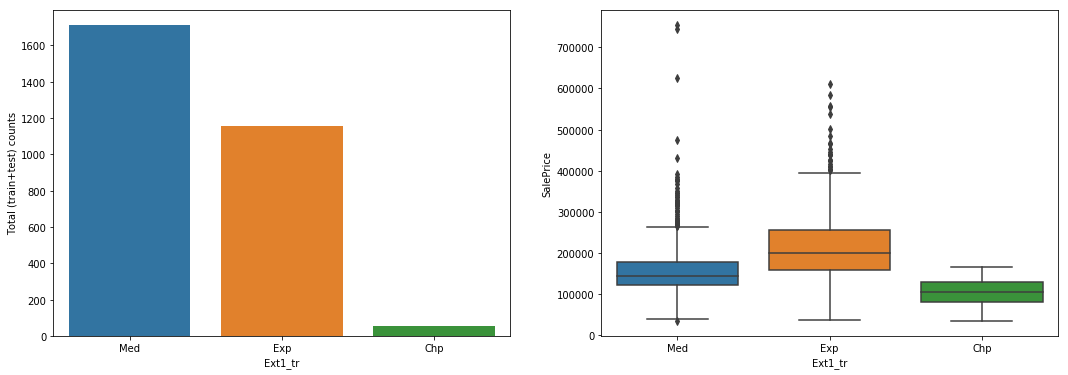

True

In [82]:
analyzefeature("Ext1_tr")

             SalePrice
Exterior1st           
AsbShng      107385.55
AsphShn      100000.00
BrkComm       71000.00
BrkFace      194573.00
CBlock       105000.00
[ 70809.         134666.66666667 198333.33333333 262000.        ]
Exterior1st
AsbShng    Chp
AsphShn    Chp
BrkComm    Chp
BrkFace    Med
CBlock     Chp
Name: SalePrice, dtype: category
Categories (3, object): [Chp < Med < Exp]
Id
1    Exp
2    Med
3    Exp
4    Med
5    Exp
Name: Exterior1st, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Ext1_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Ext1_tr is categorical


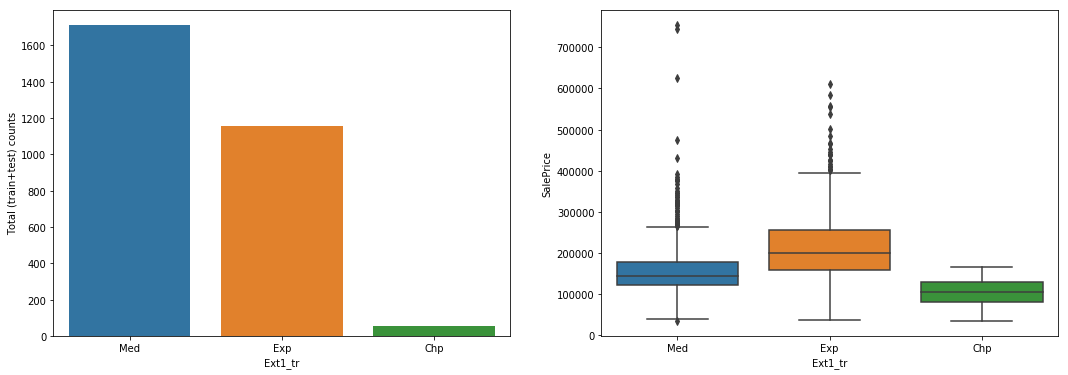

True

In [83]:
housing_train["Ext1_tr"], housing_test["Ext1_tr"]  = categorize("Exterior1st", lbls=['Chp', 'Med', 'Exp'], fillna=True)
analyzefeature("Ext1_tr")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Exterior2nd    2918 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Exterior2nd is categorical


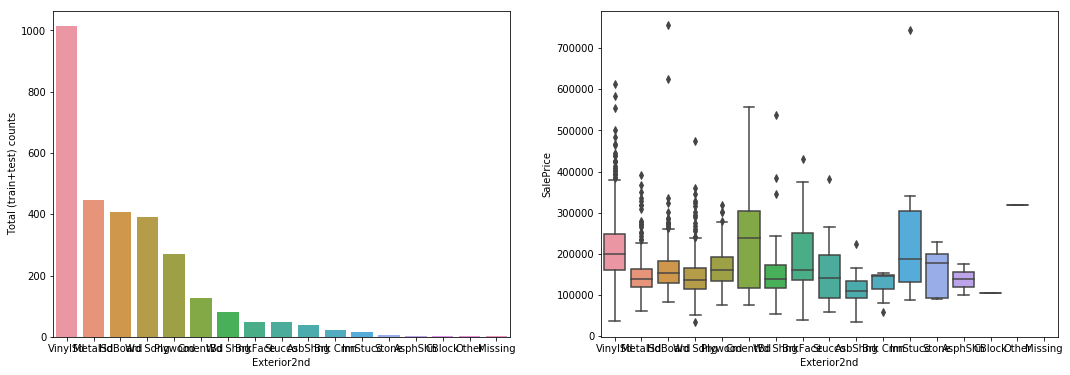

True

In [84]:
analyzefeature("Exterior2nd")

                 SalePrice
Exterior2nd               
AsbShng      114060.550000
AsphShn      138000.000000
Brk Cmn      126714.285714
BrkFace      195818.000000
CBlock       105000.000000
[104786.         176333.33333333 247666.66666667 319000.        ]
Exterior2nd
AsbShng    Chp
AsphShn    Chp
Brk Cmn    Chp
BrkFace    Med
CBlock     Chp
Name: SalePrice, dtype: category
Categories (3, object): [Chp < Med < Exp]
Id
1    Med
2    Chp
3    Med
4    Chp
5    Med
Name: Exterior2nd, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Ext2_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Ext2_tr is categorical


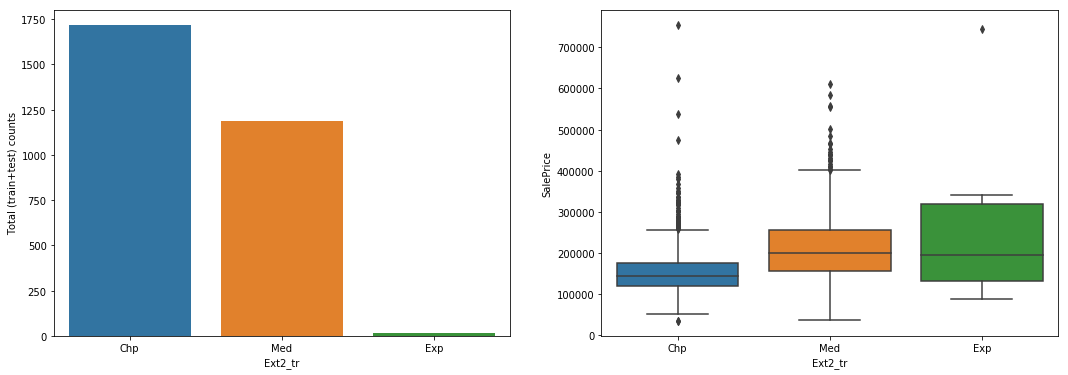

True

In [85]:
housing_train["Ext2_tr"], housing_test["Ext2_tr"]  = categorize("Exterior2nd", lbls=['Chp', 'Med', 'Exp'], fillna=True)
analyzefeature("Ext2_tr")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Ext2_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Ext2_tr is categorical


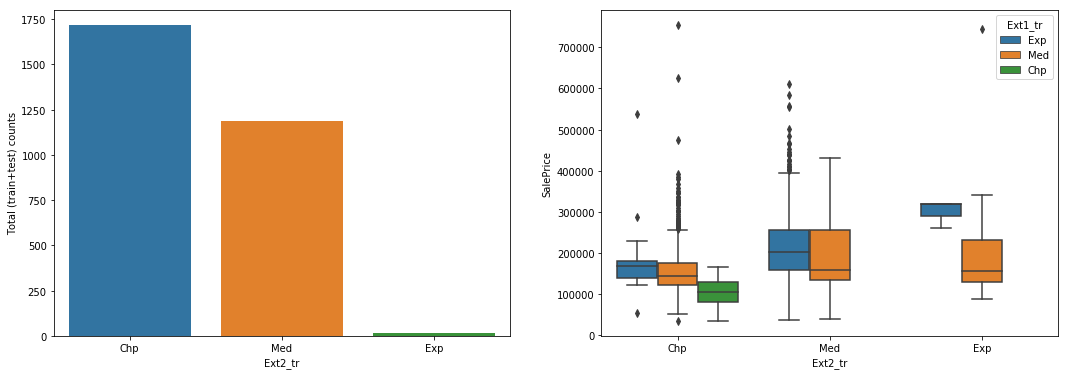

True

In [86]:
analyzefeature("Ext2_tr", "Ext1_tr")

The impact of these categories are now clearer to the sale price. 

In [87]:
features_to_dummies.append("Ext1_tr")
features_to_dummies.append("Ext2_tr")
features_to_drop.append("Exterior1st")
features_to_drop.append("Exterior2nd")

### MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MasVnrType    2895 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
MasVnrType is categorical


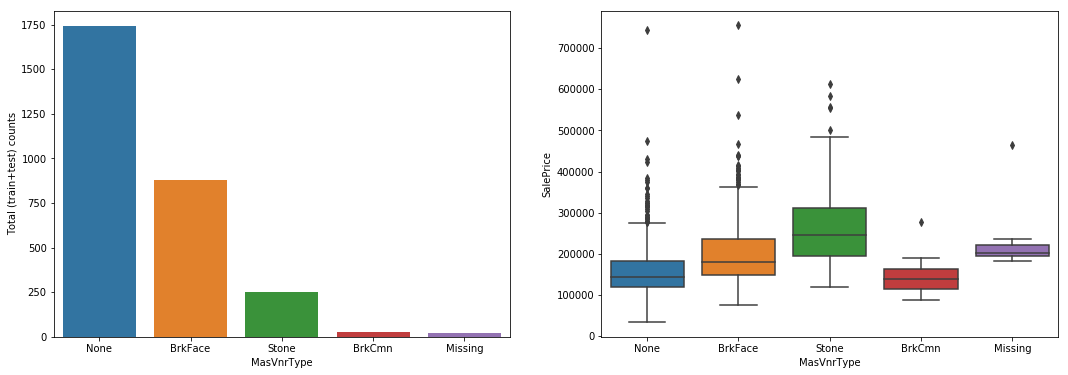

True

In [88]:
analyzefeature("MasVnrType")

                SalePrice
MasVnrType               
BrkCmn      146318.066667
BrkFace     204691.871910
None        156221.891204
Stone       265583.625000
[146198.80110833 186073.25277778 225828.43888889 265583.625     ]
MasVnrType
BrkCmn     Cat1
BrkFace    Cat2
None       Cat1
Stone      Cat3
Name: SalePrice, dtype: category
Categories (3, object): [Cat1 < Cat2 < Cat3]
Id
1    Cat2
2    Cat1
3    Cat2
4    Cat1
5    Cat2
Name: MasVnrType, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MasVnrType_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
MasVnrType_tr is categorical


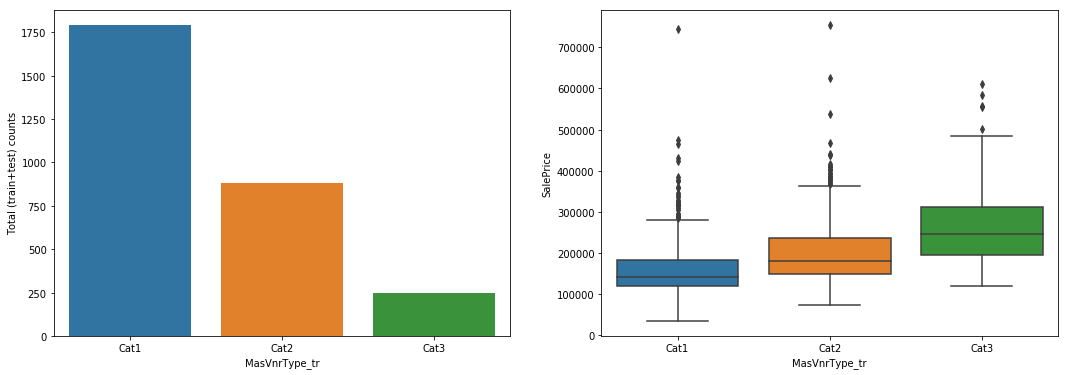

True

In [89]:
housing_train["MasVnrType_tr"], housing_test["MasVnrType_tr"]  = categorize("MasVnrType", lbls=['Cat1', 'Cat2', 'Cat3'], fillna=True)
analyzefeature("MasVnrType_tr")

In [90]:
features_to_dummies.append("MasVnrType_tr")
features_to_drop.append("MasVnrType")

### MasVnrArea

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MasVnrArea    2896 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
MasVnrArea is continuous
            MasVnrArea  SalePrice
MasVnrArea    1.000000   0.477493
SalePrice     0.477493   1.000000


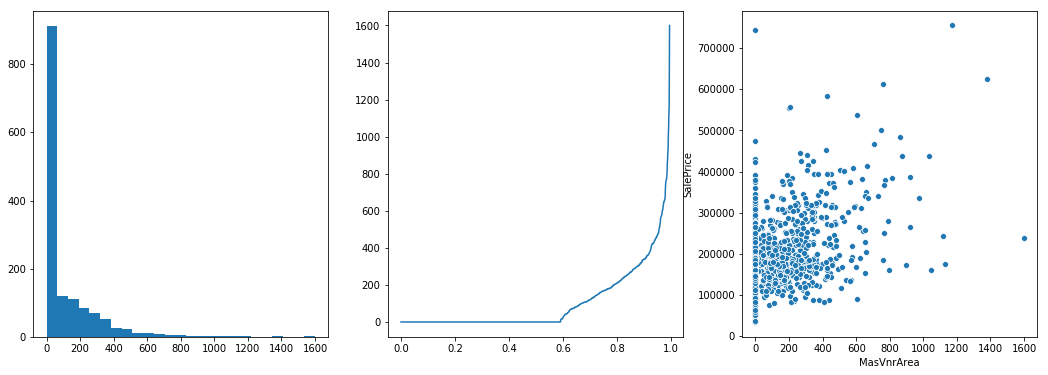

False

In [91]:
analyzefeature("MasVnrArea")

C:\Program Files\Python36\lib\site-packages\numpy\core\_methods.py:32: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial)


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MasVnrArea_log    1158 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
MasVnrArea_log is continuous
                MasVnrArea_log  SalePrice
MasVnrArea_log        1.000000   0.350173
SalePrice             0.350173   1.000000


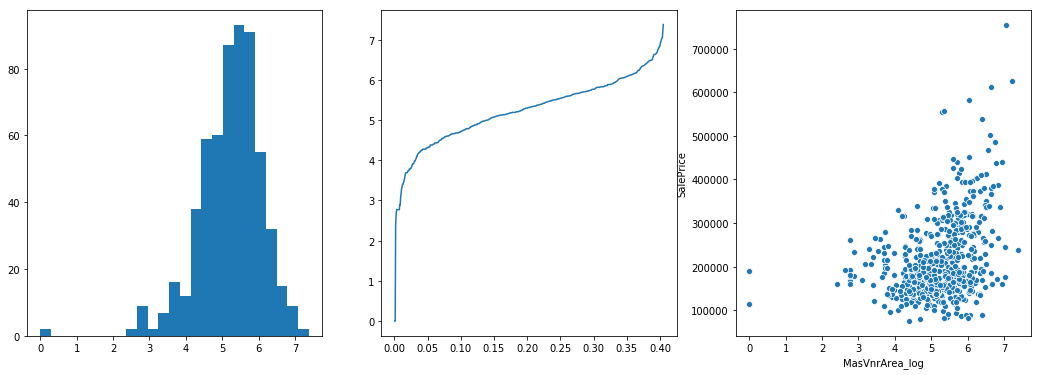

False

In [92]:
housing_train["MasVnrArea_log"]=safelog(np.array(housing_train["MasVnrArea"]))
housing_test["MasVnrArea_log"]=safelog(np.array(housing_test["MasVnrArea"]))
analyzefeature("MasVnrArea_log")

In [93]:
features_to_normalize.append("MasVnrArea_log")
features_to_drop.append("MasVnrArea")

### ExterQual: Evaluates the quality of the material on the exterior 
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
ExterQual    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
ExterQual is categorical


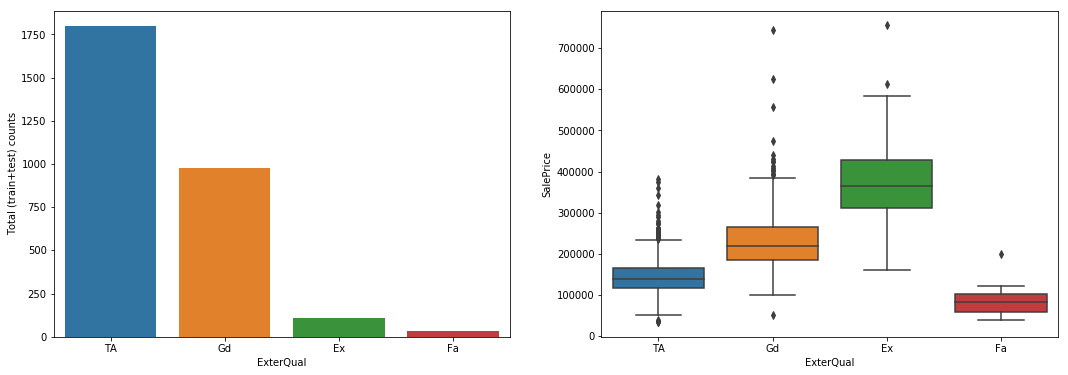

True

In [94]:
analyzefeature("ExterQual")

This feature seems to be significant, so keep it as it is.

In [95]:
features_to_dummies.append("ExterQual")

### ExterCond: Evaluates the present condition of the material on the exterior
		
       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
ExterCond    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
ExterCond is categorical


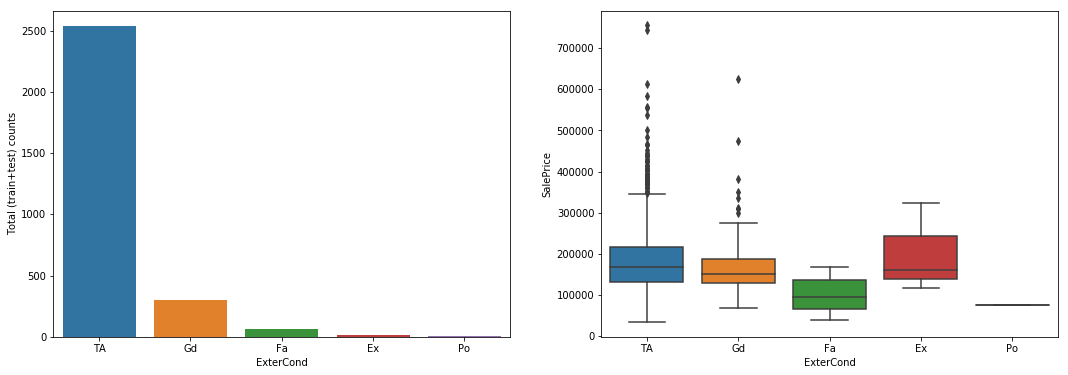

True

In [96]:
analyzefeature("ExterCond")

Most houses are typical/average. Let's try to sort this feature into two categories

               SalePrice
ExterCond               
Ex         201333.333333
Fa         102595.142857
Gd         168897.568493
Po          76500.000000
TA         184034.896256
[ 76375.16666667 138916.66666667 201333.33333333]
ExterCond
Ex    Good
Fa     Bad
Gd    Good
Po     Bad
TA    Good
Name: SalePrice, dtype: category
Categories (2, object): [Bad < Good]
Id
1    Good
2    Good
3    Good
4    Good
5    Good
Name: ExterCond, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
ExterCond_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
ExterCond_tr is categorical


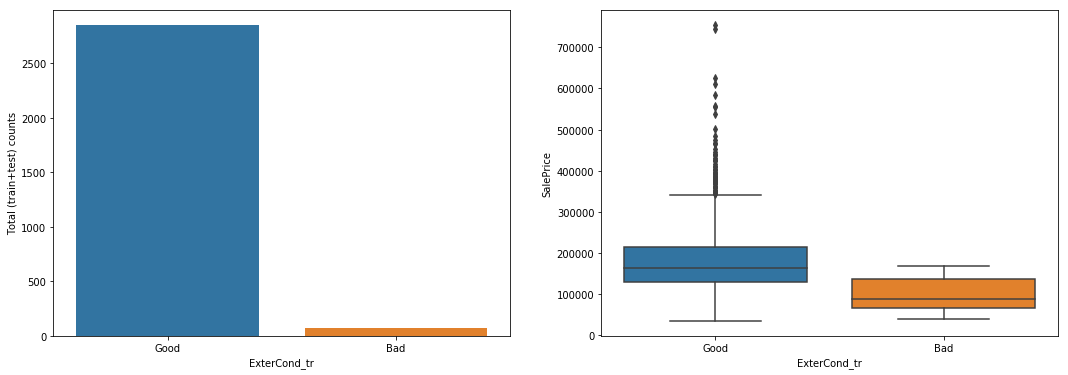

True

In [97]:
housing_train["ExterCond_tr"], housing_test["ExterCond_tr"]  = categorize("ExterCond", bns=2, lbls=['Bad', 'Good'], fillna=True)
analyzefeature("ExterCond_tr")

In [98]:
features_to_dummies.append("ExterCond_tr")
features_to_drop.append("ExterCond")

### Foundation: Type of foundation
		
       BrkTil	Brick & Tile
       CBlock	Cinder Block
       PConc	Poured Contrete	
       Slab	Slab
       Stone	Stone
       Wood	Wood

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Foundation    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Foundation is categorical


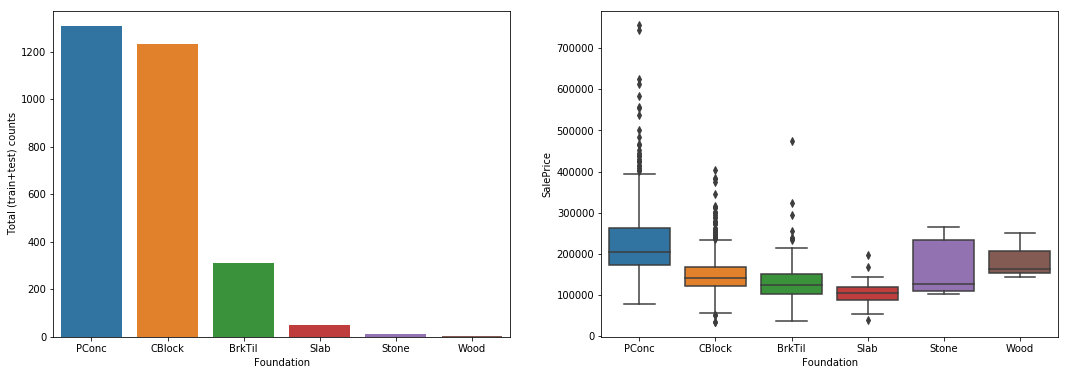

True

In [99]:
analyzefeature("Foundation")

In [100]:
x

array([6.84931507e-04, 1.36986301e-03, 2.05479452e-03, ...,
       9.98630137e-01, 9.99315068e-01, 1.00000000e+00])

                SalePrice
Foundation               
BrkTil      132291.075342
CBlock      149805.714511
PConc       225230.442040
Slab        107365.625000
Stone       165959.166667
[107247.76018296 146653.89734673 185942.16969346 225230.44204019]
Foundation
BrkTil    Chp
CBlock    Avg
PConc     Exp
Slab      Chp
Stone     Avg
Name: SalePrice, dtype: category
Categories (3, object): [Chp < Avg < Exp]
Id
1    Exp
2    Avg
3    Exp
4    Chp
5    Exp
Name: Foundation, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Foundation_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Foundation_tr is categorical


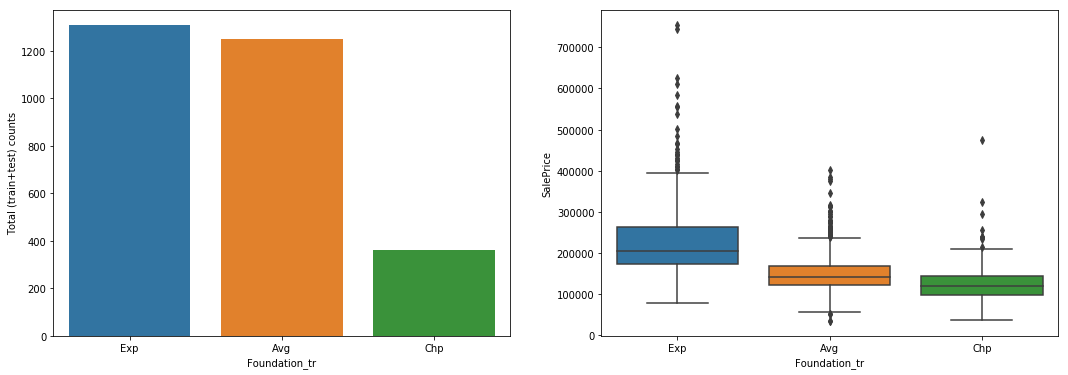

True

In [101]:
housing_train["Foundation_tr"], housing_test["Foundation_tr"]  = categorize("Foundation", bns=3, lbls=['Chp', 'Avg', 'Exp'], fillna=True)
analyzefeature("Foundation_tr")

In [102]:
features_to_dummies.append("Foundation_tr")
features_to_drop.append("Foundation")

### BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtQual    2838 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtQual is categorical


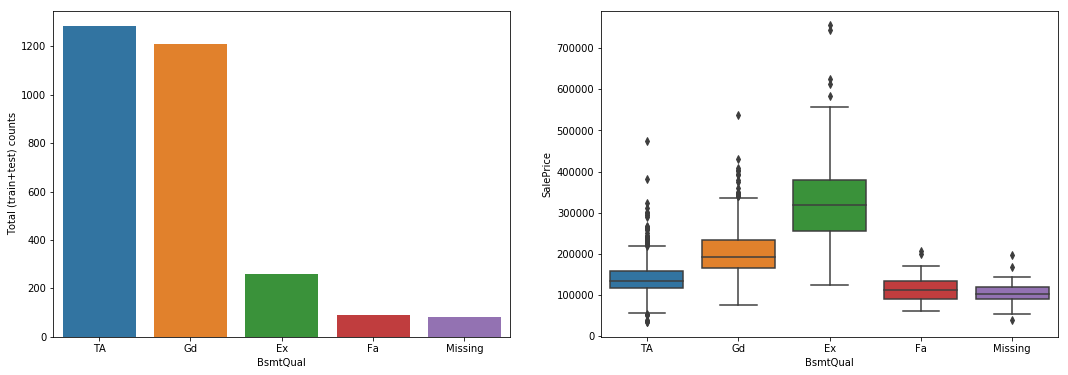

True

In [103]:
analyzefeature("BsmtQual")

              SalePrice
BsmtQual               
Ex        327041.041322
Fa        115692.028571
Gd        202688.478964
TA        140759.818182
[115480.67955868 186141.69948839 256591.37040535 327041.04132231]
BsmtQual
Ex     Good
Fa    BelAv
Gd      Avg
TA    BelAv
Name: SalePrice, dtype: category
Categories (3, object): [BelAv < Avg < Good]
Id
1      Avg
2      Avg
3      Avg
4    BelAv
5      Avg
Name: BsmtQual, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtQual_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtQual_tr is categorical


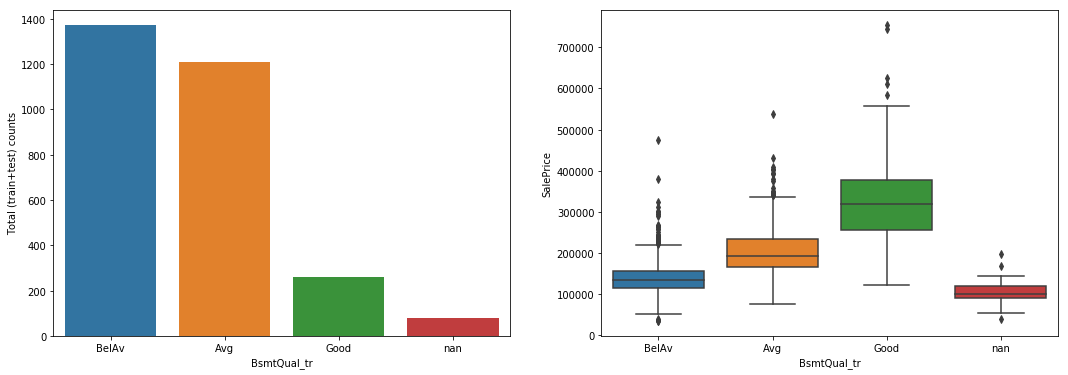

True

In [104]:
housing_train["BsmtQual_tr"], housing_test["BsmtQual_tr"]  = categorize("BsmtQual", bns=3, lbls=['BelAv', 'Avg', 'Good'], fillna=False)
analyzefeature("BsmtQual_tr")

In [105]:
features_to_dummies.append("BsmtQual_tr")
features_to_drop.append("BsmtQual")

### BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtCond    2837 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtCond is categorical


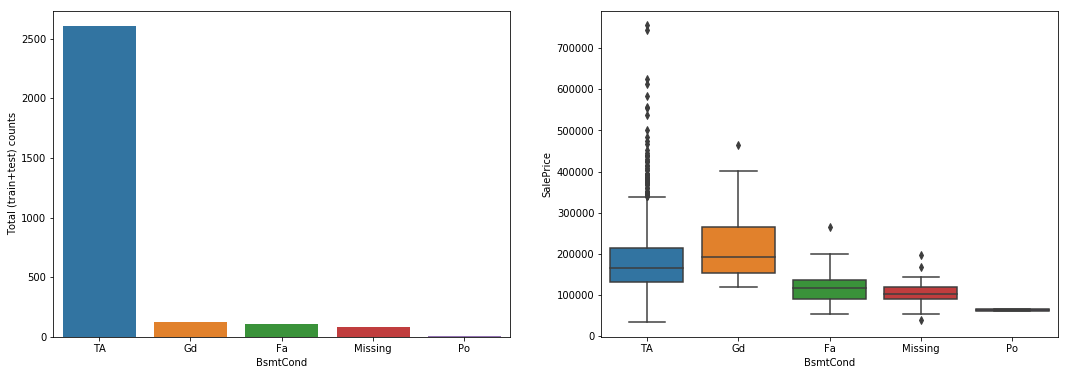

True

In [106]:
analyzefeature("BsmtCond")

In [107]:
features_to_drop.append("BsmtCond")

### BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtExposure    2837 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtExposure is categorical


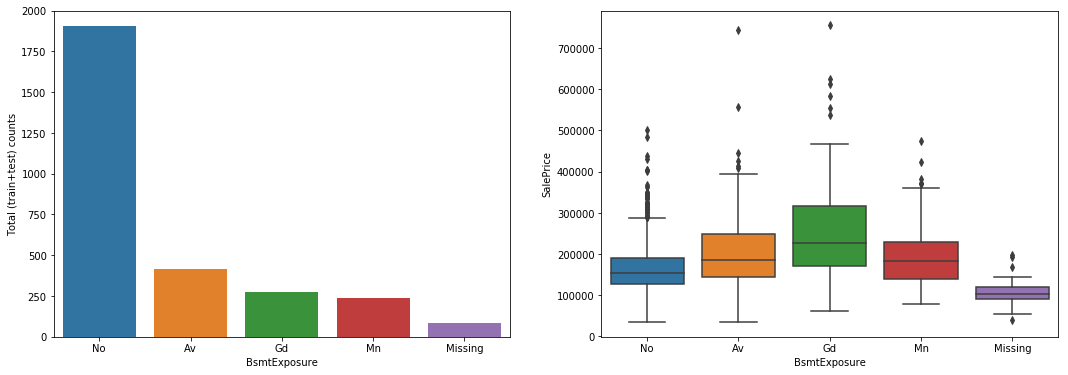

True

In [108]:
analyzefeature("BsmtExposure")

                  SalePrice
BsmtExposure               
Av            206643.420814
Gd            257689.805970
Mn            192789.657895
No            165652.295908
[165560.2583976  196331.46592849 227010.63594932 257689.80597015]
BsmtExposure
Av    Avg
Gd    Max
Mn    Min
No    Min
Name: SalePrice, dtype: category
Categories (3, object): [Min < Avg < Max]
Id
1    Min
2    Max
3    Min
4    Min
5    Avg
Name: BsmtExposure, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtExposure_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtExposure_tr is categorical


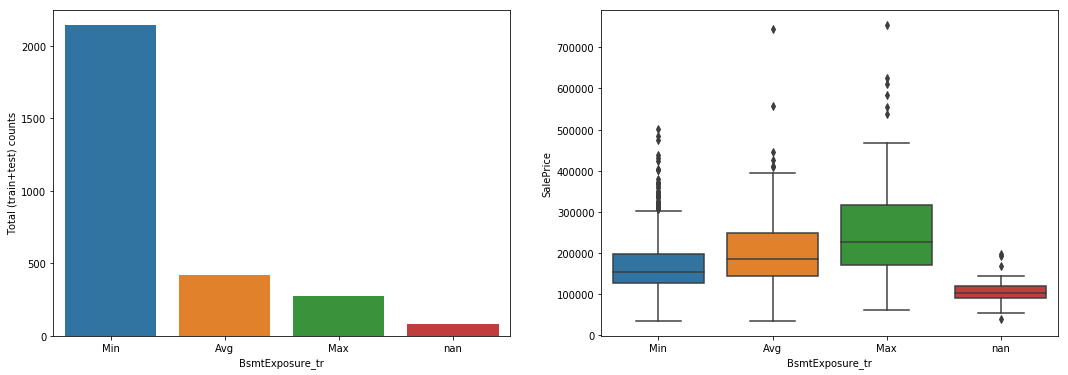

True

In [109]:
housing_train["BsmtExposure_tr"], housing_test["BsmtExposure_tr"]  = categorize("BsmtExposure", bns=3, lbls=['Min', 'Avg', 'Max'], fillna=False)
analyzefeature("BsmtExposure_tr")

In [110]:
features_to_dummies.append("BsmtExposure_tr")
features_to_drop.append("BsmtExposure")

### BsmtFinType1: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtFinType1    2840 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtFinType1 is categorical


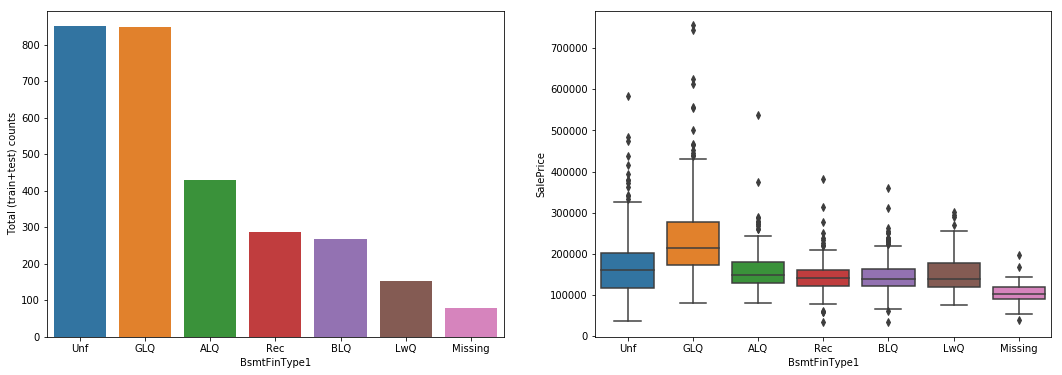

True

In [111]:
analyzefeature("BsmtFinType1")

                  SalePrice
BsmtFinType1               
ALQ           161573.068182
BLQ           149493.655405
GLQ           235413.720096
LwQ           151852.702703
Rec           146889.248120
[146800.72364833 191151.484108   235413.72009569]
BsmtFinType1
ALQ     Avg
BLQ     Avg
GLQ    Good
LwQ     Avg
Rec     Avg
Name: SalePrice, dtype: category
Categories (2, object): [Avg < Good]
Id
1    Good
2     Avg
3    Good
4     Avg
5    Good
Name: BsmtFinType1, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtFinType1_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtFinType1_tr is categorical


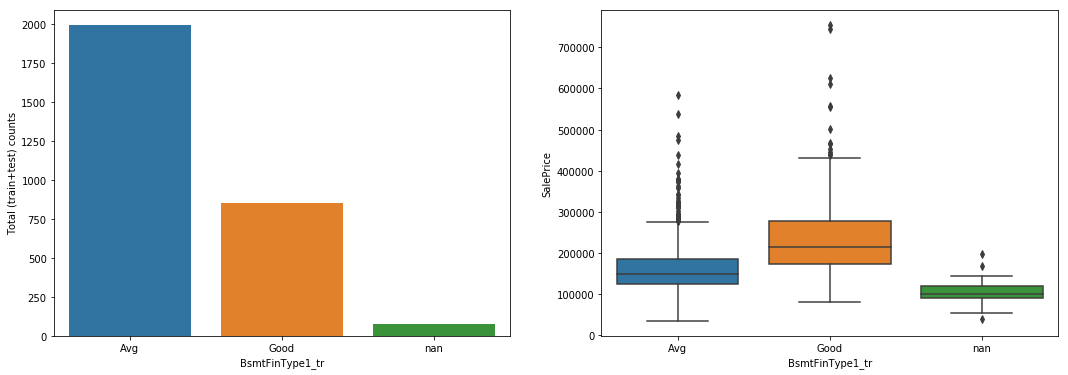

True

In [112]:
housing_train["BsmtFinType1_tr"], housing_test["BsmtFinType1_tr"]  = categorize("BsmtFinType1", bns=2, lbls=['Avg', 'Good'], fillna=False)
analyzefeature("BsmtFinType1_tr")

In [113]:
features_to_dummies.append("BsmtFinType1_tr")
features_to_drop.append("BsmtFinType1")

### BsmtFinSF1: Type 1 finished square feet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtFinSF1    2918 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
BsmtFinSF1 is continuous
            BsmtFinSF1  SalePrice
BsmtFinSF1     1.00000    0.38642
SalePrice      0.38642    1.00000


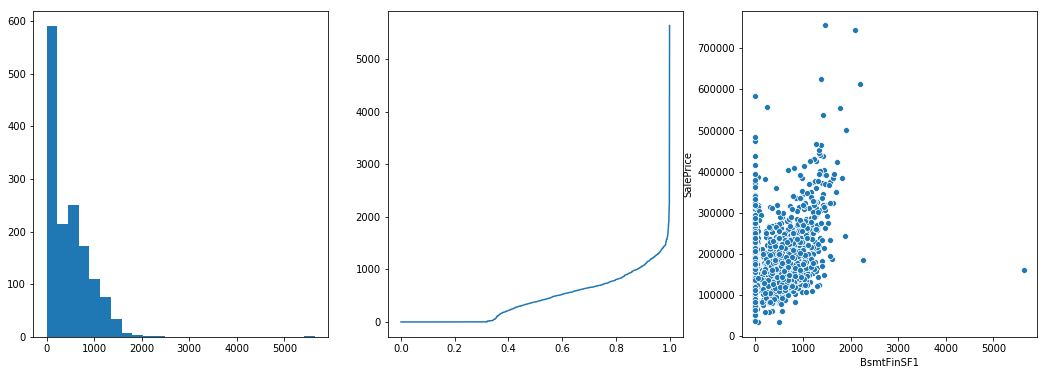

False

In [114]:
analyzefeature("BsmtFinSF1")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtFinSF1_log    2456 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
BsmtFinSF1_log is continuous
                BsmtFinSF1_log  SalePrice
BsmtFinSF1_log        1.000000   0.183266
SalePrice             0.183266   1.000000


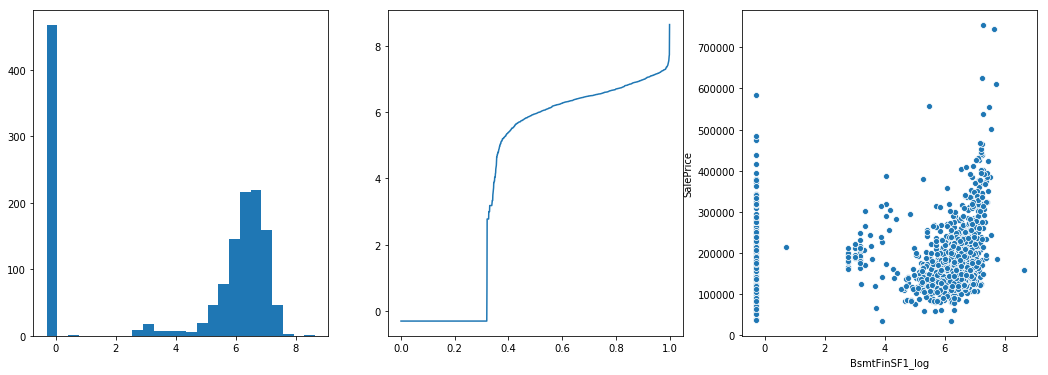

False

In [115]:
housing_train["BsmtFinSF1_log"]=safelog(np.array(housing_train["BsmtFinSF1"]),1)
housing_test["BsmtFinSF1_log"]=safelog(np.array(housing_test["BsmtFinSF1"]),1)
analyzefeature("BsmtFinSF1_log")

Correlation is weak, but let's keep it now.

In [116]:
features_to_normalize.append("BsmtFinSF1_log")
features_to_drop.append("BsmtFinSF1")

### BsmtFinType2: Rating of basement finished area (if multiple types)

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtFinType2    2839 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BsmtFinType2 is categorical


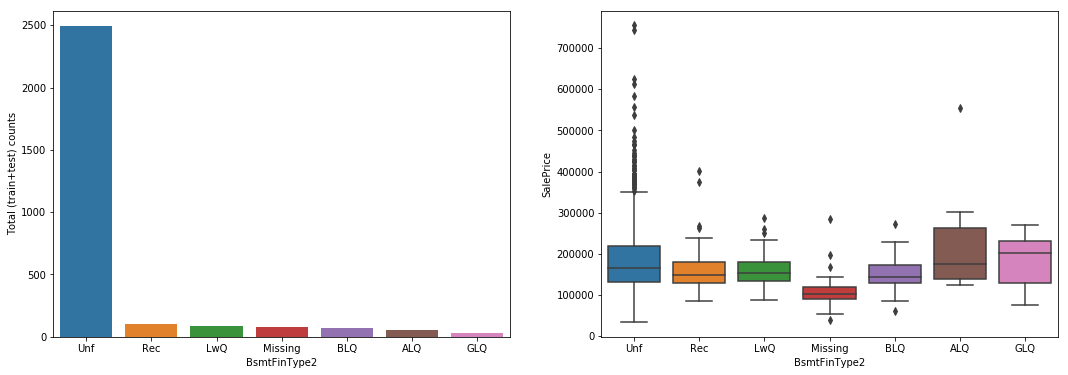

True

In [117]:
analyzefeature("BsmtFinType2")

In [118]:
features_to_drop.append("BsmtFinType2")

### BsmtUnfSF: Unfinished square feet of basement area


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtUnfSF    2918 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
BsmtUnfSF is continuous
           BsmtUnfSF  SalePrice
BsmtUnfSF   1.000000   0.214479
SalePrice   0.214479   1.000000


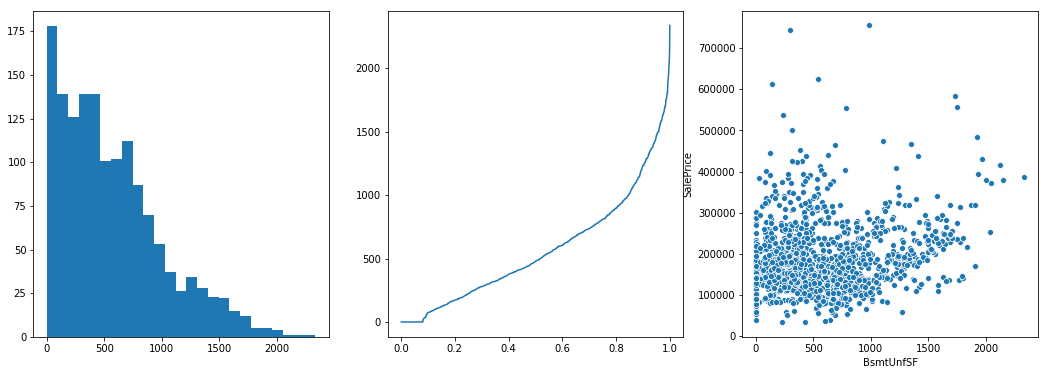

False

In [119]:
analyzefeature("BsmtUnfSF")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtUnfSF_log    2795 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
BsmtUnfSF_log is continuous
               BsmtUnfSF_log  SalePrice
BsmtUnfSF_log       1.000000   0.186111
SalePrice           0.186111   1.000000


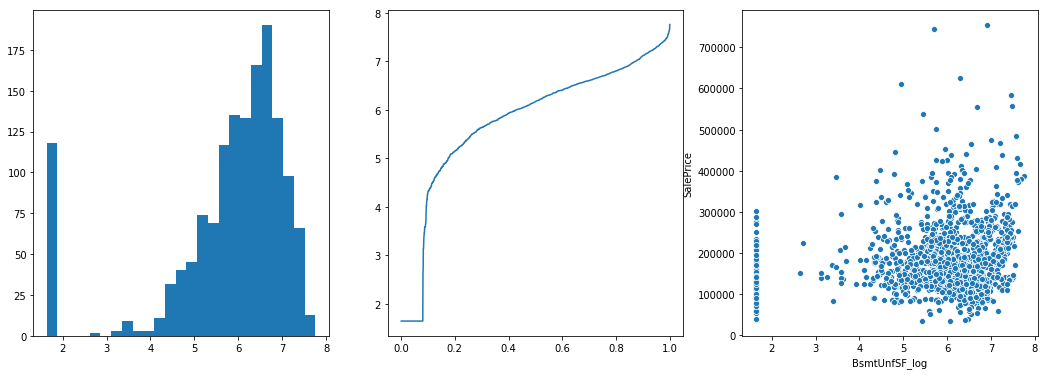

False

In [120]:
housing_train["BsmtUnfSF_log"]=safelog(np.array(housing_train["BsmtUnfSF"]),1)
housing_test["BsmtUnfSF_log"]=safelog(np.array(housing_test["BsmtUnfSF"]),1)
analyzefeature("BsmtUnfSF_log")

In [121]:
features_to_normalize.append("BsmtUnfSF_log")
features_to_drop.append("BsmtUnfSF")

### TotalBsmtSF: Total square feet of basement area


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
TotalBsmtSF    2918 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
TotalBsmtSF is continuous
             TotalBsmtSF  SalePrice
TotalBsmtSF     1.000000   0.613581
SalePrice       0.613581   1.000000


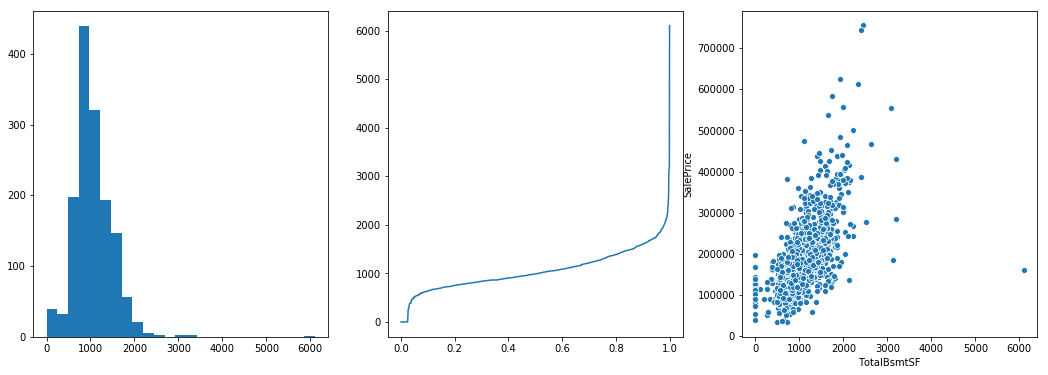

False

In [122]:
analyzefeature("TotalBsmtSF")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
TotalBsmtSF_log    2877 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
TotalBsmtSF_log is continuous
                 TotalBsmtSF_log  SalePrice
TotalBsmtSF_log          1.00000    0.45656
SalePrice                0.45656    1.00000


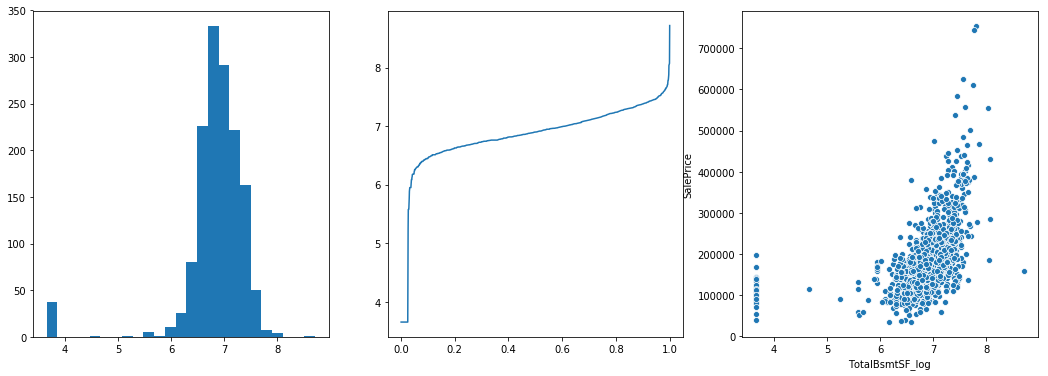

False

In [123]:
housing_train["TotalBsmtSF_log"]=safelog(np.array(housing_train["TotalBsmtSF"]),1)
housing_test["TotalBsmtSF_log"]=safelog(np.array(housing_test["TotalBsmtSF"]),1)
analyzefeature("TotalBsmtSF_log")

In [124]:
features_to_normalize.append("TotalBsmtSF_log")
features_to_drop.append("TotalBsmtSF")

### Heating: Type of heating
		
       Floor	Floor Furnace
       GasA	Gas forced warm air furnace
       GasW	Gas hot water or steam heat
       Grav	Gravity furnace	
       OthW	Hot water or steam heat other than gas
       Wall	Wall furnace

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Heating    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Heating is categorical


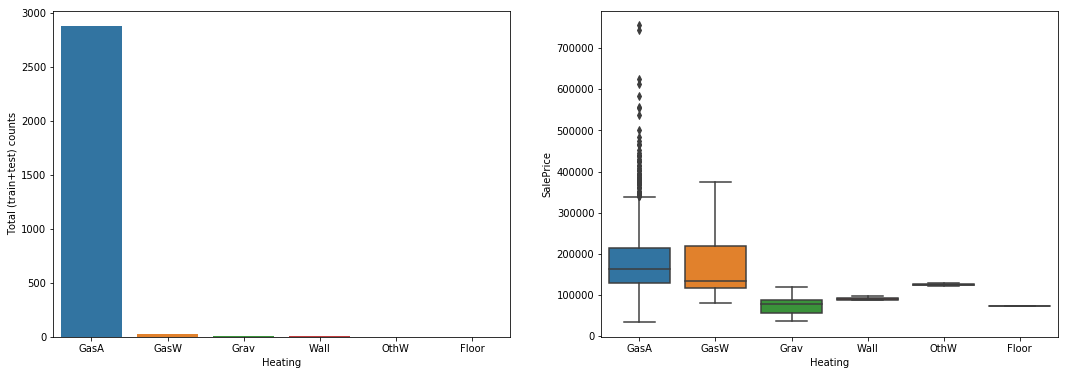

True

In [125]:
analyzefeature("Heating")

In [126]:
features_to_drop.append("Heating")

### HeatingQC: Heating quality and condition

       Ex	Excellent
       Gd	Good
       TA	Average/Typical
       Fa	Fair
       Po	Poor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
HeatingQC    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
HeatingQC is categorical


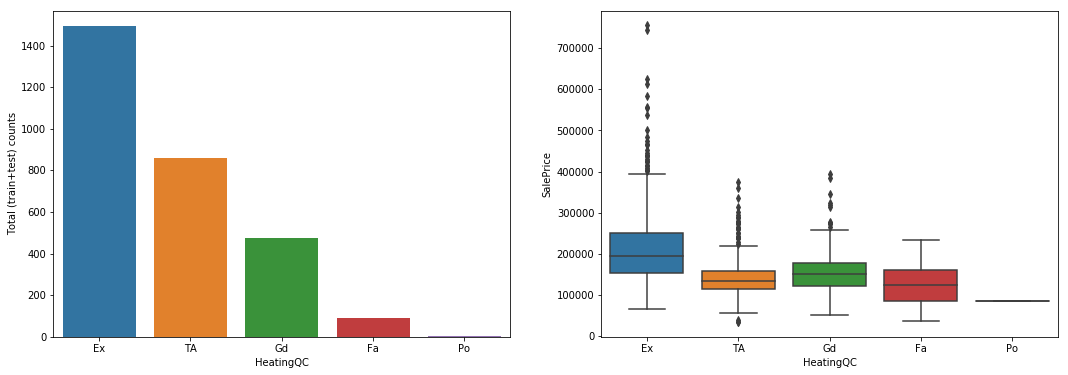

True

In [127]:
analyzefeature("HeatingQC")

               SalePrice
HeatingQC               
Ex         214914.429150
Fa         123919.489796
Gd         156858.871369
Po          87000.000000
TA         142362.876168
[ 86872.08557085 150957.2145749  214914.4291498 ]
HeatingQC
Ex     Ex
Fa    Avg
Gd     Ex
Po    Avg
TA    Avg
Name: SalePrice, dtype: category
Categories (2, object): [Avg < Ex]
Id
1    Ex
2    Ex
3    Ex
4    Ex
5    Ex
Name: HeatingQC, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
HeatingQC_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
HeatingQC_tr is categorical


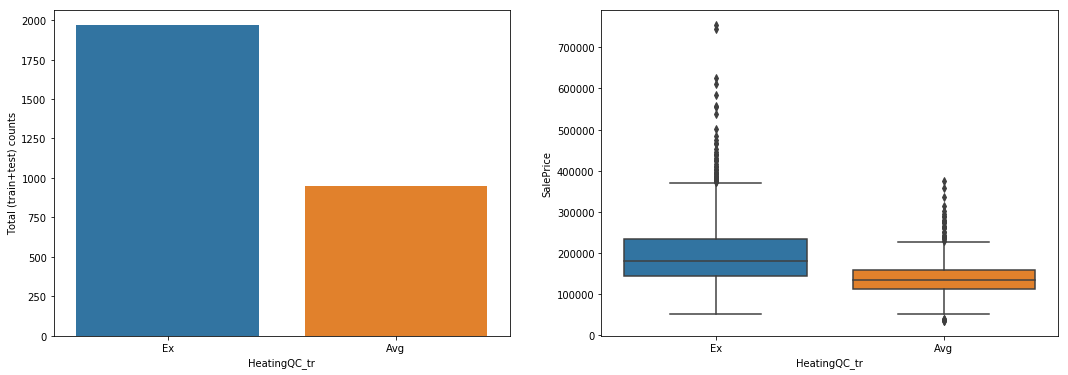

True

In [128]:
housing_train["HeatingQC_tr"], housing_test["HeatingQC_tr"]  = categorize("HeatingQC", bns=2, lbls=['Avg', 'Ex'], fillna=False)
analyzefeature("HeatingQC_tr")

In [129]:
features_to_dummies.append("HeatingQC_tr")
features_to_drop.append("HeatingQC")

### CentralAir: Central air conditioning

       N	No
       Y	Yes

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
CentralAir    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
CentralAir is categorical


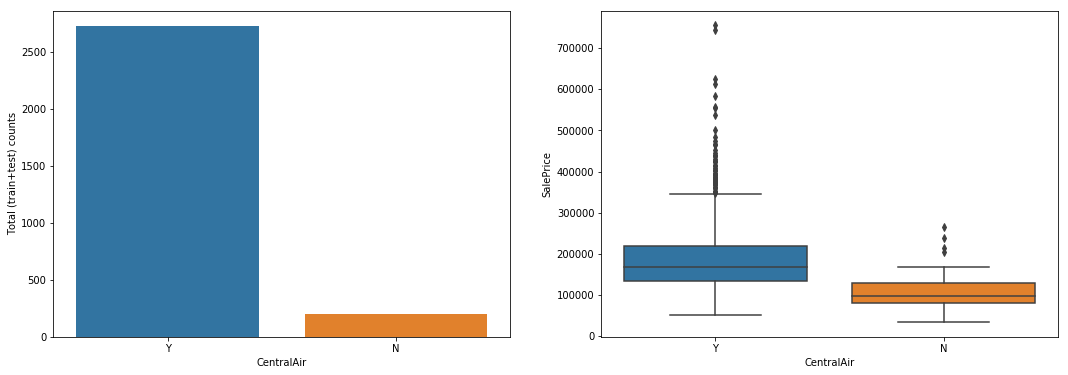

True

In [130]:
analyzefeature("CentralAir")

In [131]:
features_to_dummies.append("CentralAir")

### Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Electrical    2918 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Electrical is categorical


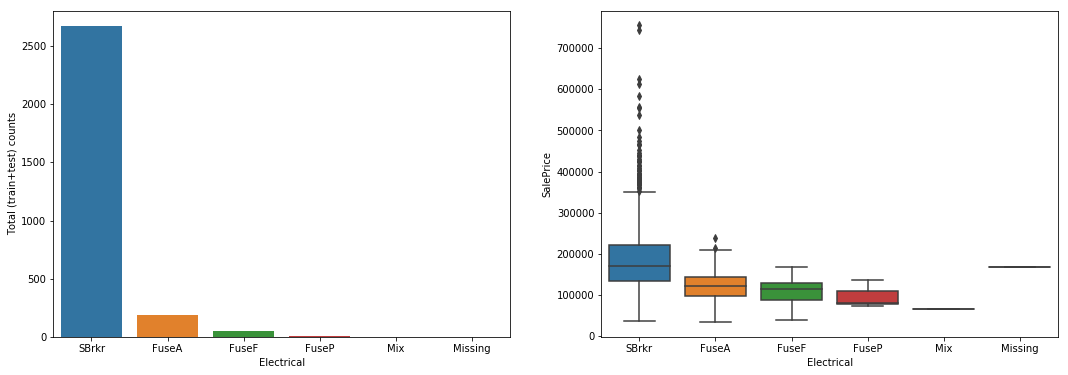

True

In [132]:
analyzefeature("Electrical")

                SalePrice
Electrical               
FuseA       122196.893617
FuseF       107675.444444
FuseP        97333.333333
Mix          67000.000000
SBrkr       186825.113193
[ 66880.17488681 126912.5565967  186825.1131934 ]
Electrical
FuseA     Fuse
FuseF     Fuse
FuseP     Fuse
Mix       Fuse
SBrkr    SBrkr
Name: SalePrice, dtype: category
Categories (2, object): [Fuse < SBrkr]
Id
1    SBrkr
2    SBrkr
3    SBrkr
4    SBrkr
5    SBrkr
Name: Electrical, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Electrical_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Electrical_tr is categorical


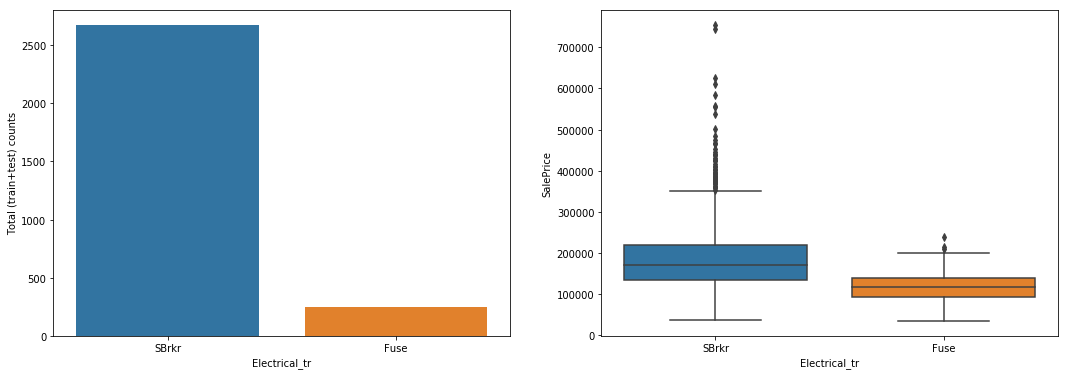

True

In [133]:
housing_train["Electrical_tr"], housing_test["Electrical_tr"]  = categorize("Electrical", bns=2, lbls=['Fuse', 'SBrkr'], fillna=True)
analyzefeature("Electrical_tr")

In [134]:
features_to_dummies.append("Electrical_tr")
features_to_drop.append("Electrical")

### Living Area
1stFlrSF: First Floor square feet
 
2ndFlrSF: Second floor square feet

LowQualFinSF: Low quality finished square feet (all floors)

GrLivArea: Above grade (ground) living area square feet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
1stFlrSF    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
1stFlrSF is continuous
           1stFlrSF  SalePrice
1stFlrSF   1.000000   0.605852
SalePrice  0.605852   1.000000


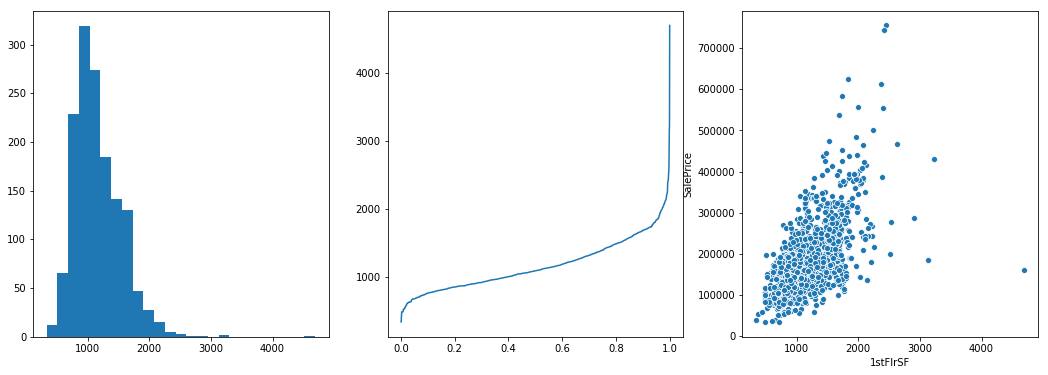

False

In [135]:
analyzefeature("1stFlrSF")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
2ndFlrSF    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
2ndFlrSF is continuous
           2ndFlrSF  SalePrice
2ndFlrSF   1.000000   0.319334
SalePrice  0.319334   1.000000


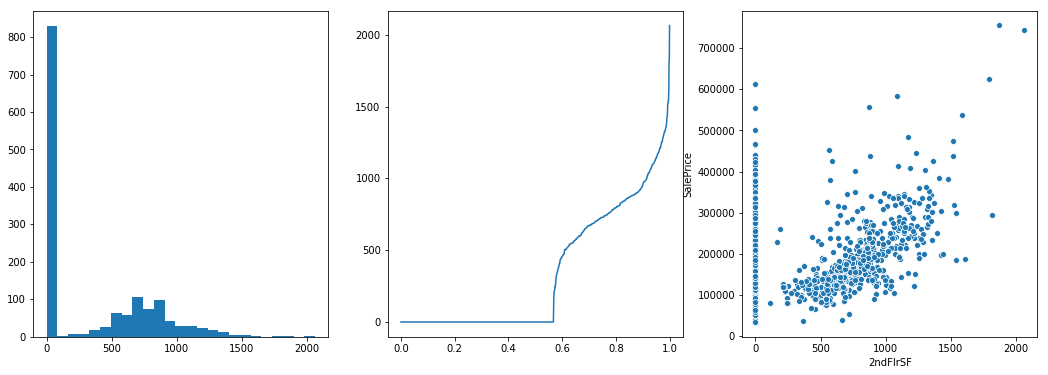

False

In [136]:
analyzefeature("2ndFlrSF")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
LowQualFinSF    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
LowQualFinSF is continuous
              LowQualFinSF  SalePrice
LowQualFinSF      1.000000  -0.025606
SalePrice        -0.025606   1.000000


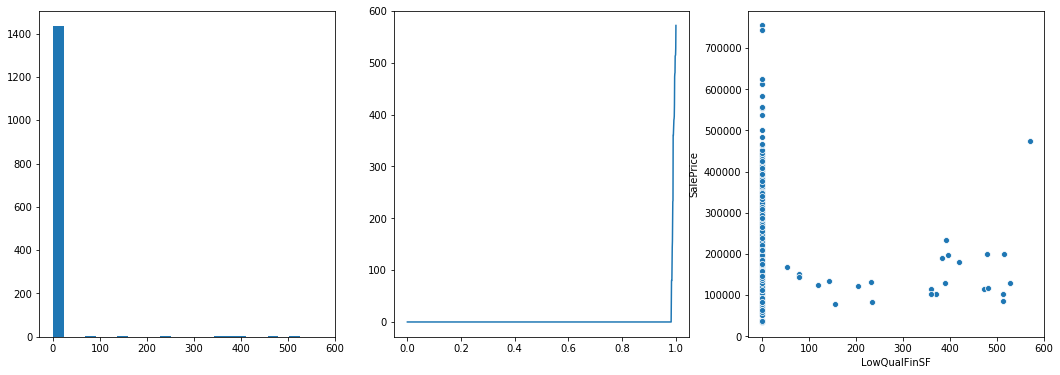

False

In [137]:
analyzefeature("LowQualFinSF")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GrLivArea    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
GrLivArea is continuous
           GrLivArea  SalePrice
GrLivArea   1.000000   0.708624
SalePrice   0.708624   1.000000


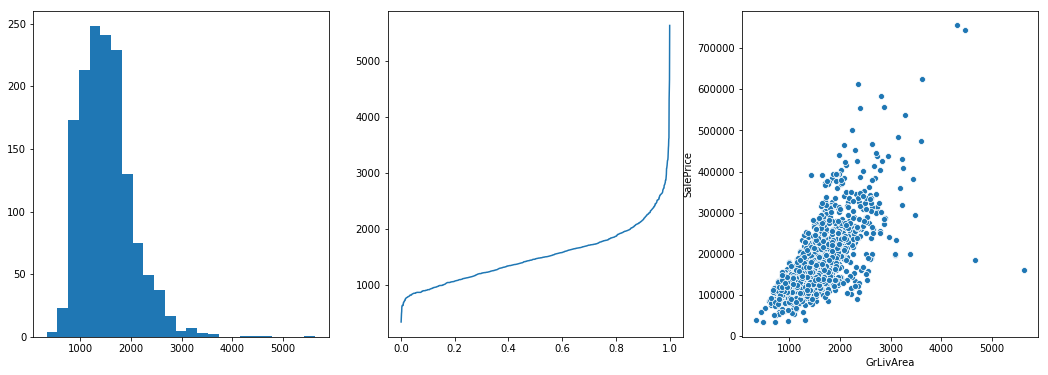

False

In [138]:
analyzefeature("GrLivArea")

Due to the obvious correlation between the living area and the sale price, it is reasonable to define a new normalized target variable, Price/SF

In [139]:
housing_train["SalePrice_SF"] = housing_train["SalePrice"]/housing_train["GrLivArea"]

Let's drop the other area variables, as they are correlated with the total area as well as the corresponding categorical variables.

In [140]:
features_to_drop.append("1stFlrSF")
features_to_drop.append("2ndFlrSF")
features_to_drop.append("LowQualFinSF")

### Rooms
BsmtFullBath: Basement full bathrooms
BsmtHalfBath: Basement half bathrooms
FullBath: Full bathrooms above grade
HalfBath: Half baths above grade
Bedroom: Bedrooms above grade (does NOT include basement bedrooms)
Kitchen: Kitchens above grade

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtFullBath    2917 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
BsmtFullBath is categorical


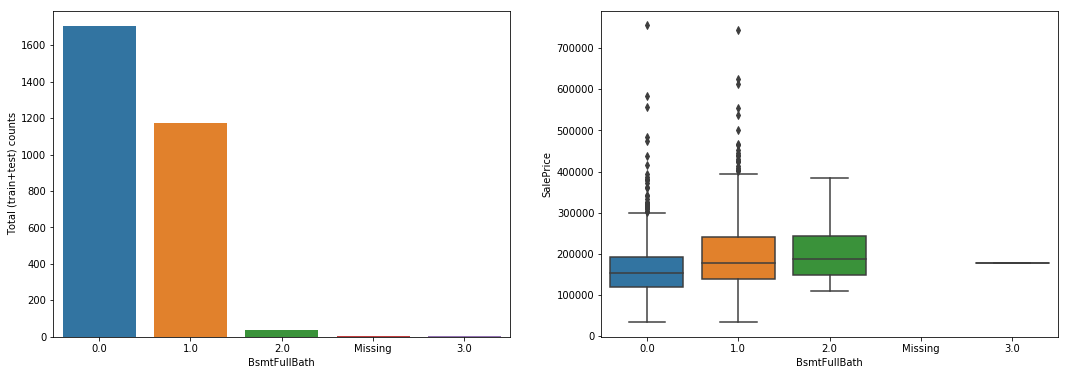

True

In [141]:
analyzefeature("BsmtFullBath")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BsmtHalfBath    2917 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
BsmtHalfBath is categorical


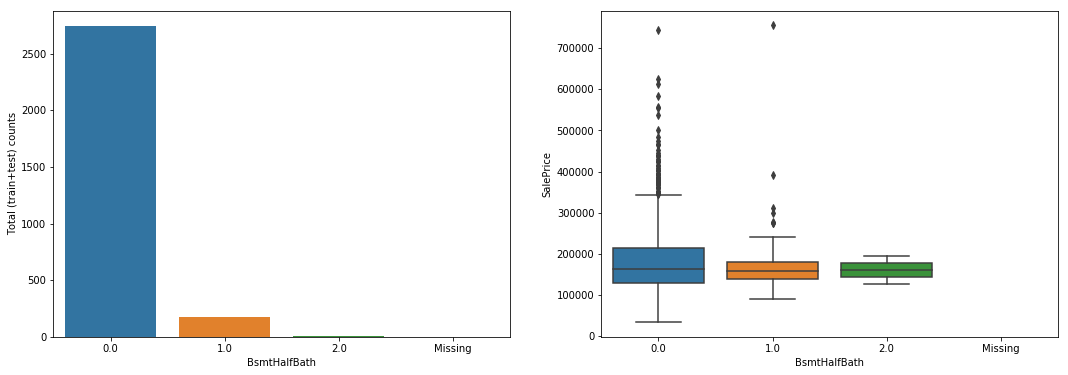

True

In [142]:
analyzefeature("BsmtHalfBath")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
FullBath    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
FullBath is categorical


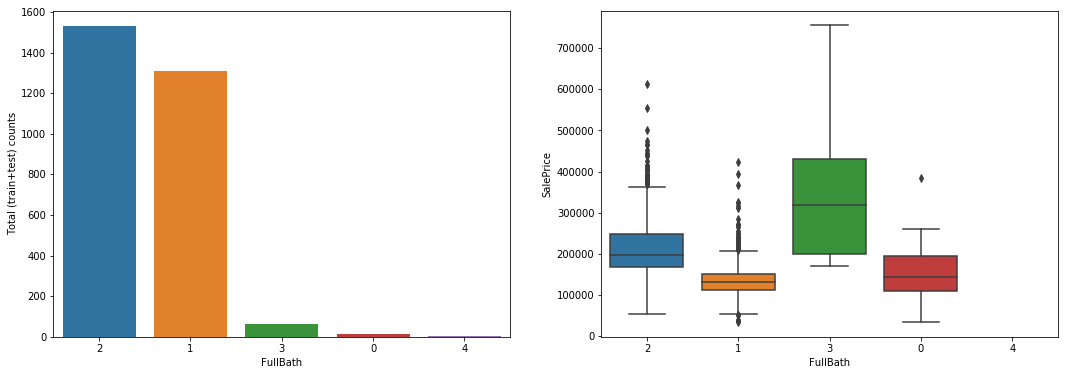

True

In [143]:
analyzefeature("FullBath")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
HalfBath    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
HalfBath is categorical


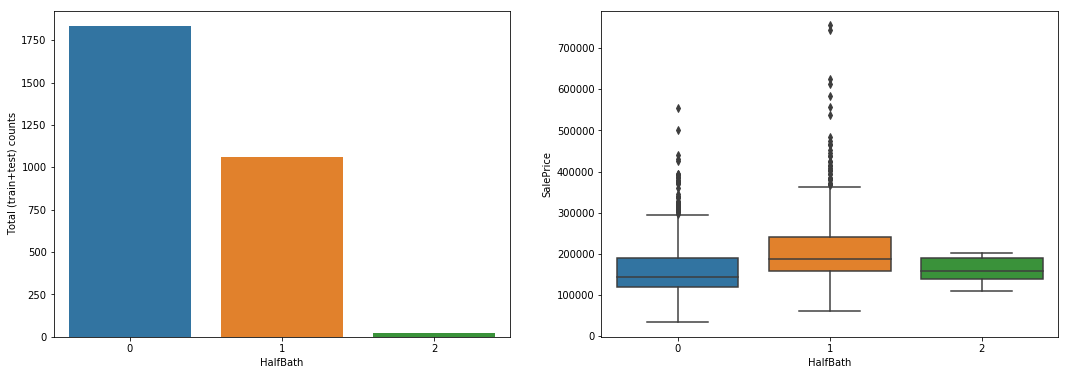

True

In [144]:
analyzefeature("HalfBath")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
TotalBath    2919 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
TotalBath is categorical


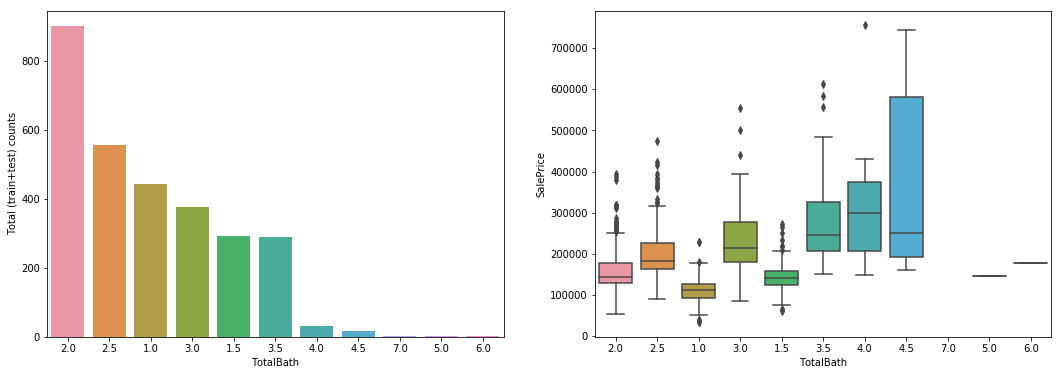

True

In [145]:
housing_train["TotalBath"] = housing_train["BsmtFullBath"].fillna(0.0)+housing_train["BsmtHalfBath"].fillna(0.0)/2+housing_train["FullBath"].fillna(0.0)+housing_train["HalfBath"].fillna(0.0)/2
housing_test["TotalBath"] = housing_test["BsmtFullBath"].fillna(0.0)+housing_test["BsmtHalfBath"].fillna(0.0)/2+housing_test["FullBath"].fillna(0.0)+housing_test["HalfBath"].fillna(0.0)/2
analyzefeature("TotalBath")

In [146]:
housing_train["TotalBath"].describe()

count    1460.000000
mean        2.210616
std         0.785399
min         1.000000
25%         2.000000
50%         2.000000
75%         2.500000
max         6.000000
Name: TotalBath, dtype: float64

               SalePrice
TotalBath               
1.0        110869.671053
1.5        142692.372093
2.0        158116.103070
2.5        199723.983051
3.0        230525.672043
[110594.43358083 202615.49498747 294361.31892231 386107.14285714]
TotalBath
1.0    Few
1.5    Few
2.0    Few
2.5    Few
3.0    Avg
Name: SalePrice, dtype: category
Categories (3, object): [Few < Avg < Many]
Id
1    Avg
2    Few
3    Avg
4    Few
5    Avg
Name: TotalBath, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
TotalBath_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
TotalBath_tr is categorical


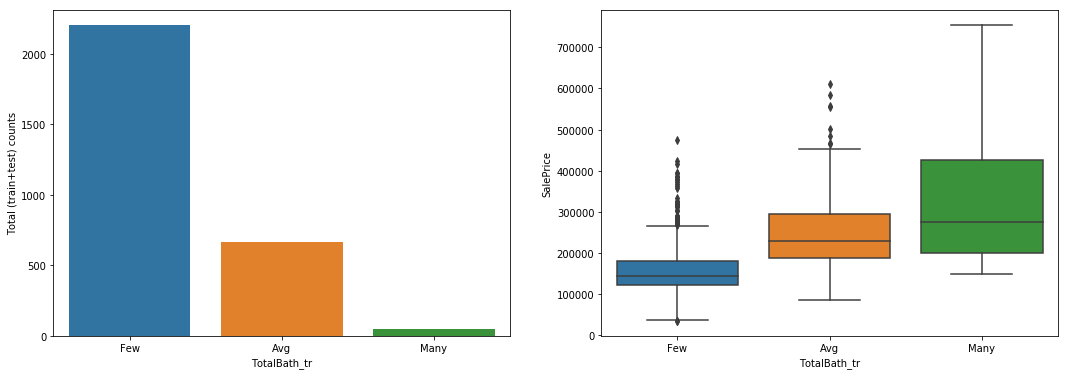

True

In [147]:
housing_train["TotalBath_tr"], housing_test["TotalBath_tr"]  = categorize("TotalBath", bns=3, lbls=['Few', 'Avg', 'Many'], fillna=True)
analyzefeature("TotalBath_tr")

In [148]:
features_to_dummies.append("TotalBath_tr")
features_to_drop.append("TotalBath")
features_to_drop.append("BsmtFullBath")
features_to_drop.append("BsmtHalfBath")
features_to_drop.append("FullBath")
features_to_drop.append("HalfBath")

In [149]:
housing_train.columns[40:60]

Index(['CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BedroomAbvGr    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
BedroomAbvGr is categorical


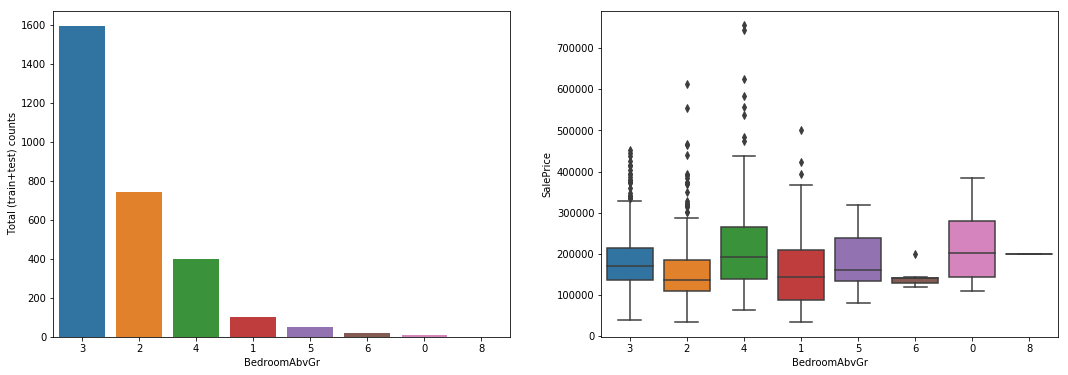

True

In [150]:
analyzefeature("BedroomAbvGr")

                  SalePrice
BedroomAbvGr               
0             221493.166667
1             173162.420000
2             158197.659218
3             181056.870647
4             220421.253521
[143701.28583333 169683.72222222 195588.44444444 221493.16666667]
BedroomAbvGr
0    Many
1     Avg
2     Few
3     Avg
4    Many
Name: SalePrice, dtype: category
Categories (3, object): [Few < Avg < Many]
Id
1     Avg
2     Avg
3     Avg
4     Avg
5    Many
Name: BedroomAbvGr, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
BedroomAbvGr_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
BedroomAbvGr_tr is categorical


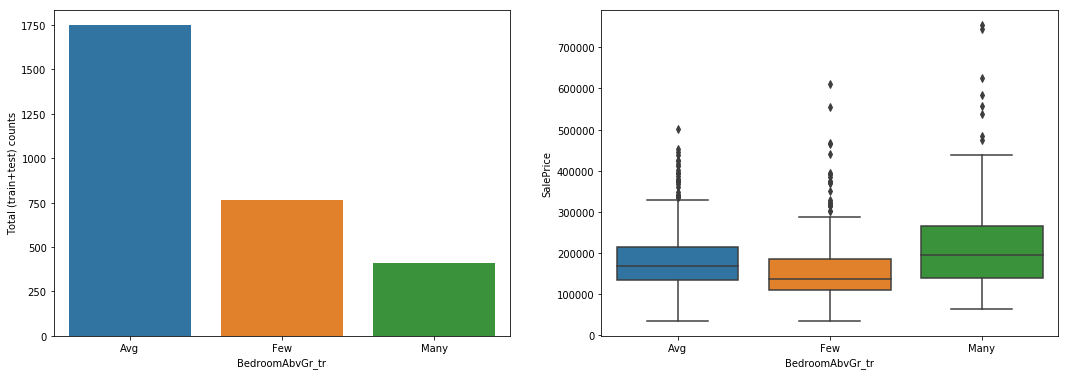

True

In [151]:
housing_train["BedroomAbvGr_tr"], housing_test["BedroomAbvGr_tr"]  = categorize("BedroomAbvGr", bns=3, lbls=['Few', 'Avg', 'Many'], fillna=True)
analyzefeature("BedroomAbvGr_tr")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
TotRmsAbvGrd    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
TotRmsAbvGrd is categorical


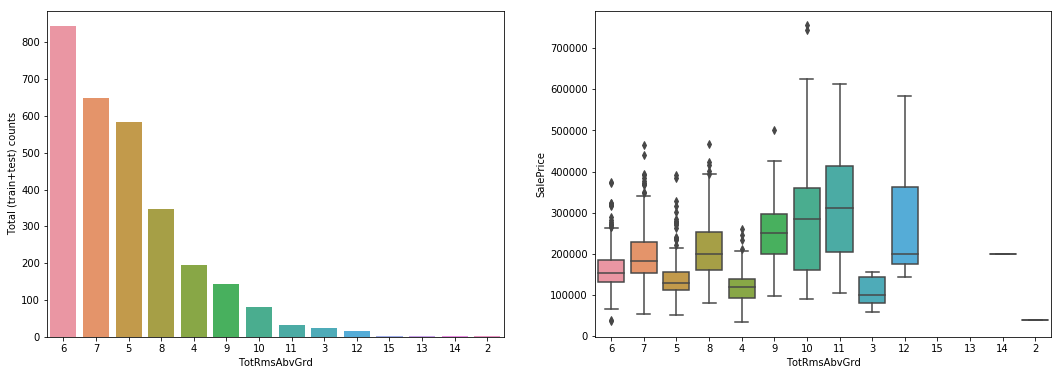

True

In [152]:
analyzefeature("TotRmsAbvGrd")

                  SalePrice
TotRmsAbvGrd               
2              39300.000000
3             111217.647059
4             122844.628866
5             141550.749091
6             161303.296020
[ 39021.278      132207.33333333 225114.66666667 318022.        ]
TotRmsAbvGrd
2    Few
3    Few
4    Few
5    Avg
6    Avg
Name: SalePrice, dtype: category
Categories (3, object): [Few < Avg < Many]
Id
1     Avg
2     Avg
3     Avg
4     Avg
5    Many
Name: TotRmsAbvGrd, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
TotRooms_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
TotRooms_tr is categorical


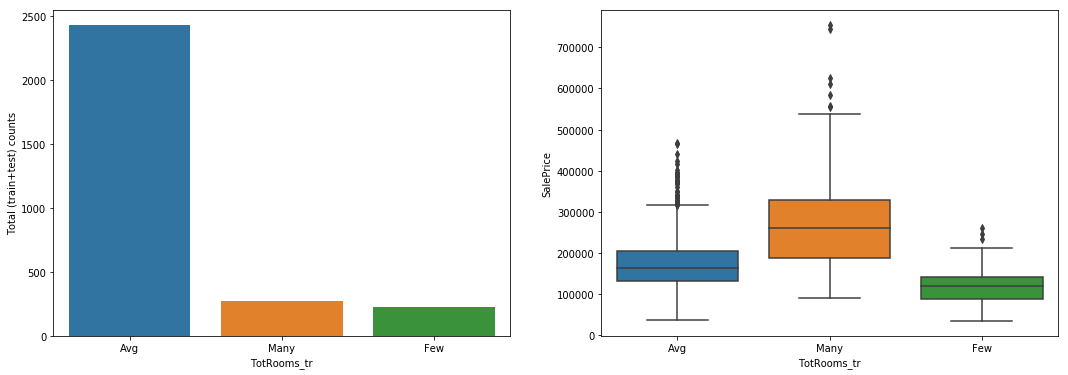

True

In [153]:
housing_train["TotRooms_tr"], housing_test["TotRooms_tr"]  = categorize("TotRmsAbvGrd", bns=3, lbls=['Few', 'Avg', 'Many'], fillna=True)
analyzefeature("TotRooms_tr")

In [154]:
features_to_dummies.append("TotRooms_tr")
features_to_drop.append("TotRmsAbvGrd")
features_to_drop.append("BedroomAbvGr_tr")
features_to_drop.append("BedroomAbvGr")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
KitchenAbvGr    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
KitchenAbvGr is categorical


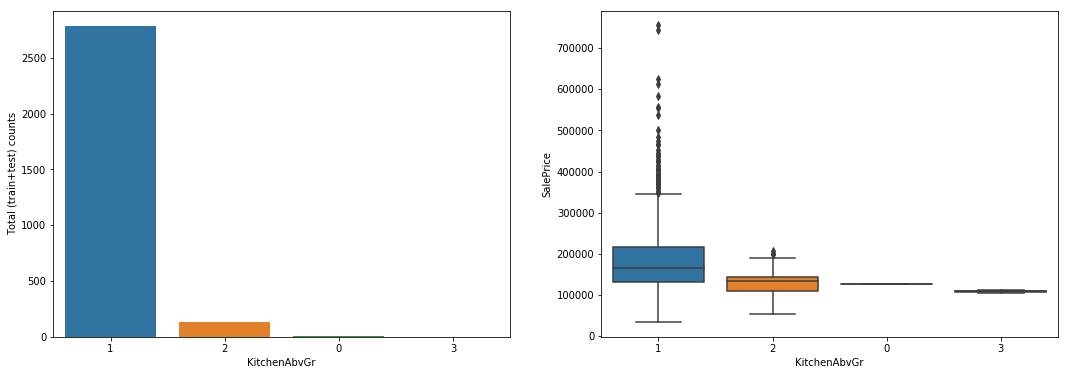

True

In [155]:
analyzefeature("KitchenAbvGr")

In [156]:
features_to_drop.append("KitchenAbvGr")

### KitchenQual: Kitchen quality

       Ex	Excellent
       Gd	Good
       TA	Typical/Average
       Fa	Fair
       Po	Poor

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
KitchenQual    2918 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
KitchenQual is categorical


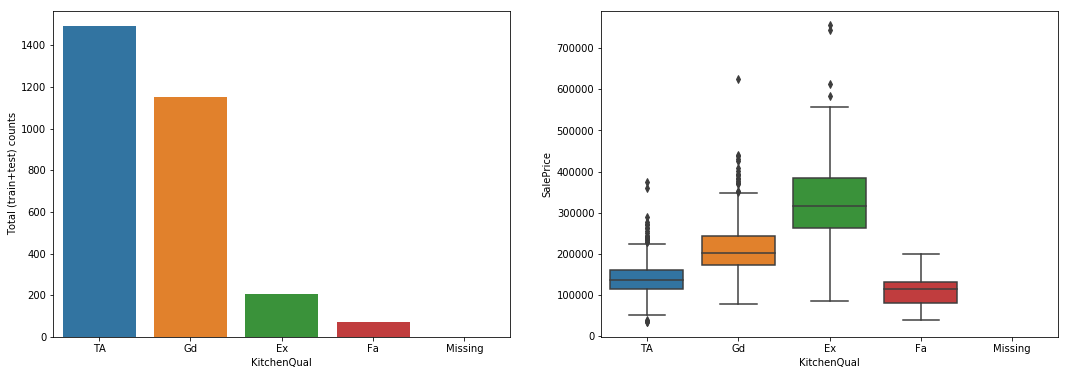

True

In [157]:
analyzefeature("KitchenQual")

                 SalePrice
KitchenQual               
Ex           328554.670000
Fa           105565.205128
Gd           212116.023891
TA           139962.511565
[105342.21566333 179895.02675214 254224.84837607 328554.67      ]
KitchenQual
Ex    Good
Fa    Poor
Gd     Avg
TA    Poor
Name: SalePrice, dtype: category
Categories (3, object): [Poor < Avg < Good]
Id
1     Avg
2    Poor
3     Avg
4     Avg
5     Avg
Name: KitchenQual, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
KitchenQual_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
KitchenQual_tr is categorical


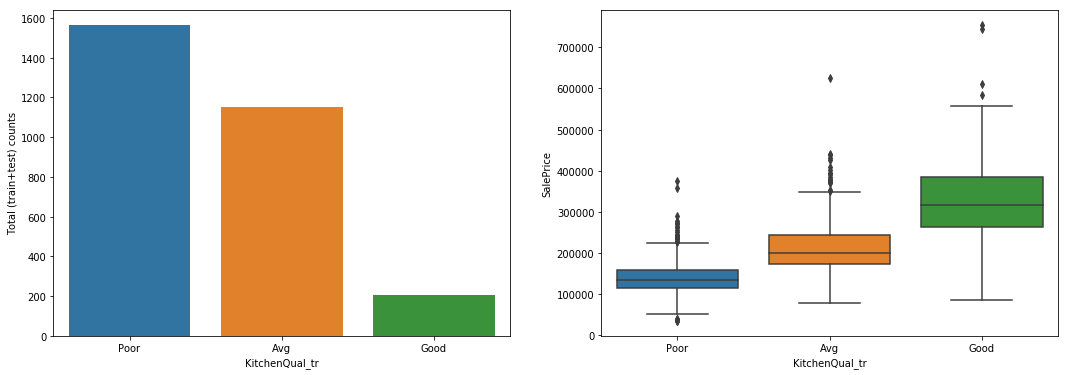

True

In [158]:
housing_train["KitchenQual_tr"], housing_test["KitchenQual_tr"]  = categorize("KitchenQual", bns=3, lbls=['Poor', 'Avg', 'Good'], fillna=True)
analyzefeature("KitchenQual_tr")

In [159]:
features_to_dummies.append("KitchenQual_tr")
features_to_drop.append("KitchenQual")

### Functional: Home functionality (Assume typical unless deductions are warranted)

       Typ	Typical Functionality
       Min1	Minor Deductions 1
       Min2	Minor Deductions 2
       Mod	Moderate Deductions
       Maj1	Major Deductions 1
       Maj2	Major Deductions 2
       Sev	Severely Damaged
       Sal	Salvage only

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Functional    2917 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Functional is categorical


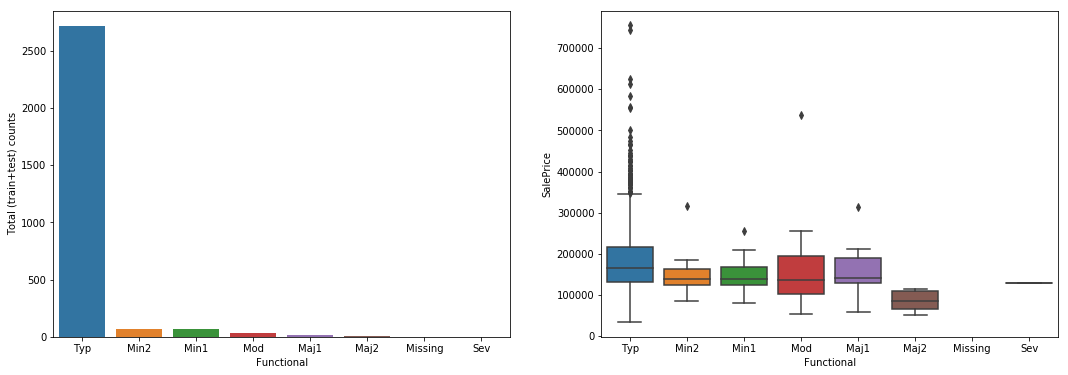

True

In [160]:
analyzefeature("Functional")

In [161]:
features_to_drop.append("Functional")

### Fireplaces: number of fireplaces

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Fireplaces    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
Fireplaces is categorical


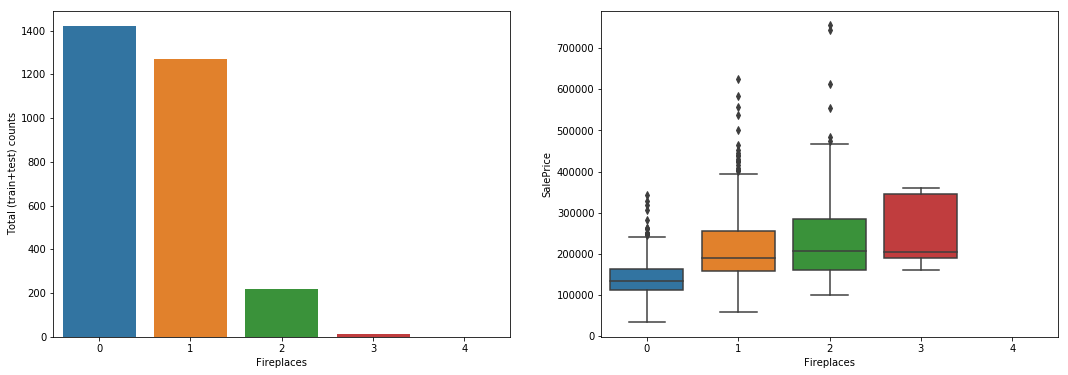

True

In [162]:
analyzefeature("Fireplaces")

                SalePrice
Fireplaces               
0           141331.482609
1           211843.909231
2           240588.539130
3           252000.000000
[141220.8140913  196665.74130435 252000.        ]
Fireplaces
0        None
1    One/More
2    One/More
3    One/More
Name: SalePrice, dtype: category
Categories (2, object): [None < One/More]
Id
1        None
2    One/More
3    One/More
4    One/More
5    One/More
Name: Fireplaces, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Fireplaces_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Fireplaces_tr is categorical


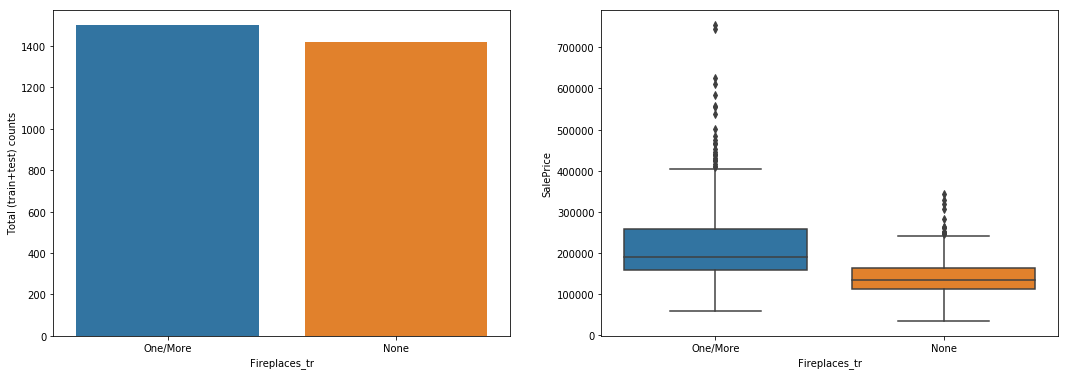

True

In [163]:
housing_train["Fireplaces_tr"], housing_test["Fireplaces_tr"]  = categorize("Fireplaces", bns=2, lbls=['None', 'One/More'], fillna=True)
analyzefeature("Fireplaces_tr")

In [164]:
features_to_dummies.append("Fireplaces_tr")
features_to_drop.append("Fireplaces")

### FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
FireplaceQu    1499 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
FireplaceQu is categorical


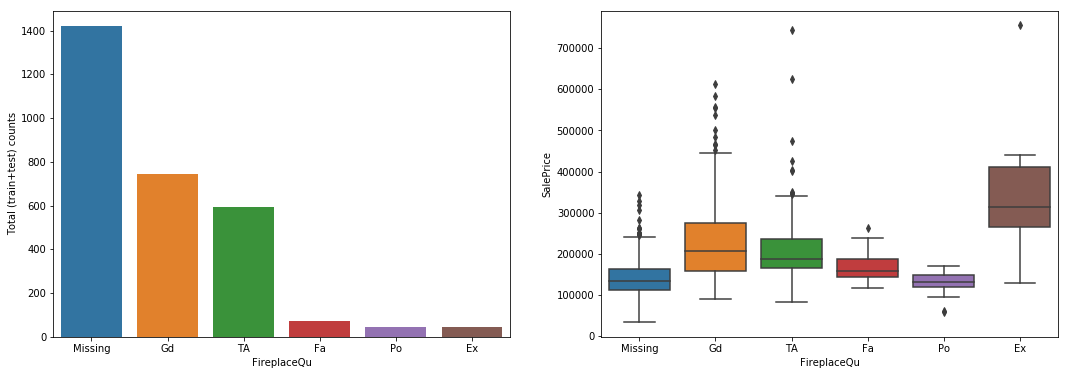

True

In [165]:
analyzefeature("FireplaceQu")

In [166]:
features_to_drop.append("FireplaceQu")

### Garage
GarageType: Garage location
GarageYrBlt: Year garage was built
GarageFinish: Interior finish of the garage
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
GarageQual: Garage quality
GarageCond: Garage condition

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageType    2762 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
GarageType is categorical


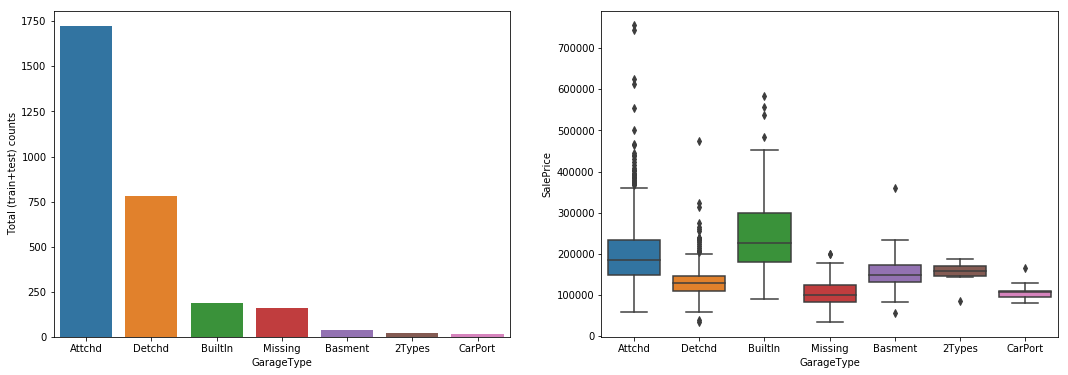

True

In [167]:
analyzefeature("GarageType")

In [168]:
features_to_drop.append("GarageType")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageFinish    2760 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
GarageFinish is categorical


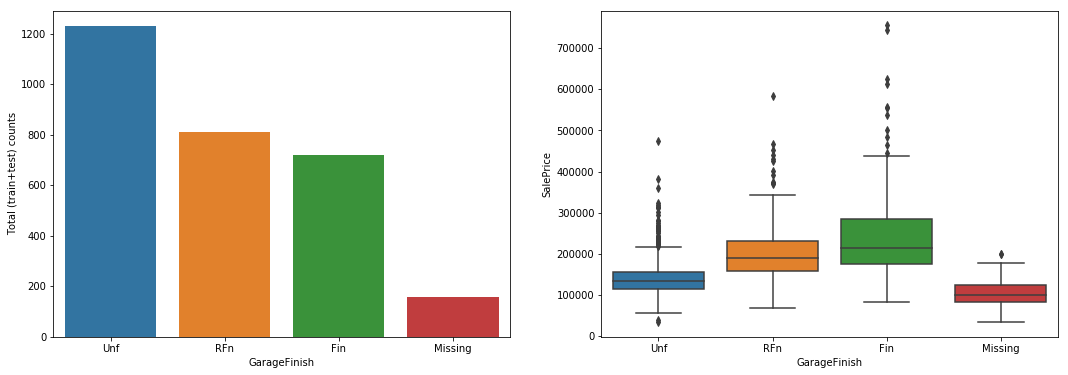

True

In [169]:
analyzefeature("GarageFinish")

In [170]:
features_to_dummies.append("GarageFinish")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageCars    2918 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
GarageCars is categorical


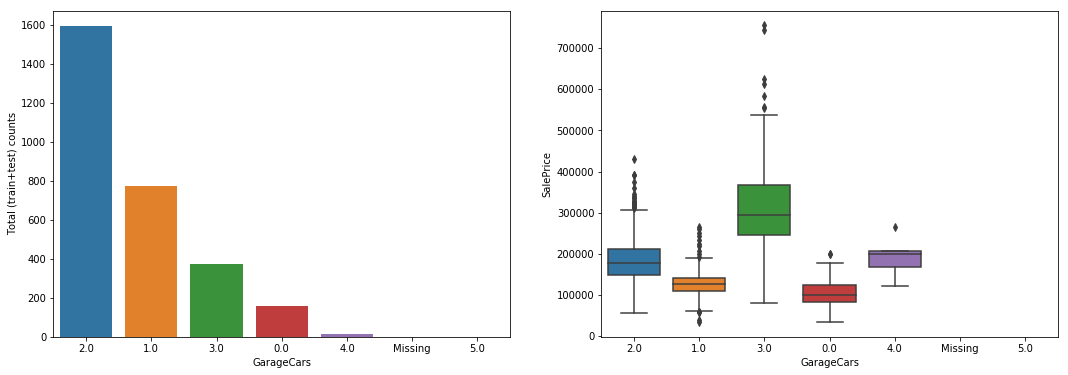

True

In [171]:
analyzefeature("GarageCars")

In [172]:
housing_train["GarageCars"].describe()

count    1460.000000
mean        1.767123
std         0.747315
min         0.000000
25%         1.000000
50%         2.000000
75%         2.000000
max         4.000000
Name: GarageCars, dtype: float64

                SalePrice
GarageCars               
0           103317.283951
1           128116.688347
2           183851.663835
3           309636.121547
4           192655.800000
[103110.96511302 172090.22981607 240863.17568151 309636.12154696]
GarageCars
0     Few
1     Few
2    Some
3    Many
4    Some
Name: SalePrice, dtype: category
Categories (3, object): [Few < Some < Many]
Id
1    Some
2    Some
3    Some
4    Many
5    Many
Name: GarageCars, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageCars_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
GarageCars_tr is categorical


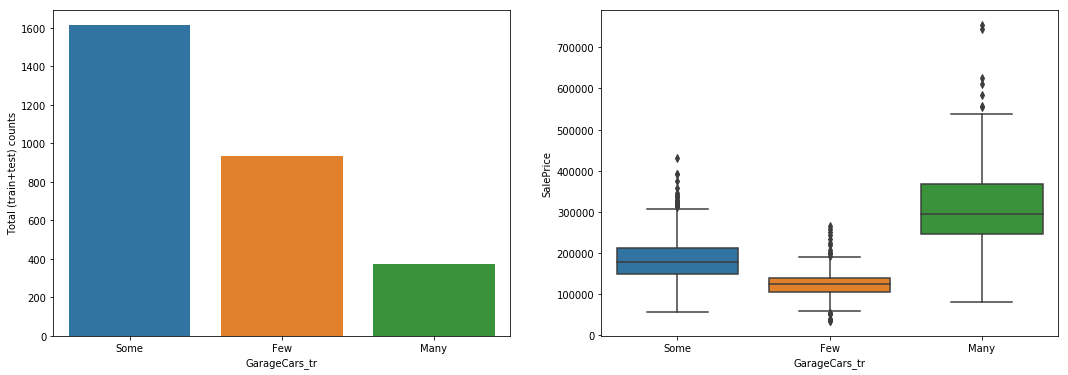

True

In [173]:
housing_train["GarageCars_tr"], housing_test["GarageCars_tr"]  = categorize("GarageCars", bns=3, lbls=['Few', 'Some', 'Many'], fillna=True)
analyzefeature("GarageCars_tr")

In [174]:
features_to_dummies.append("GarageCars_tr")
features_to_drop.append("GarageCars")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageQual    2760 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
GarageQual is categorical


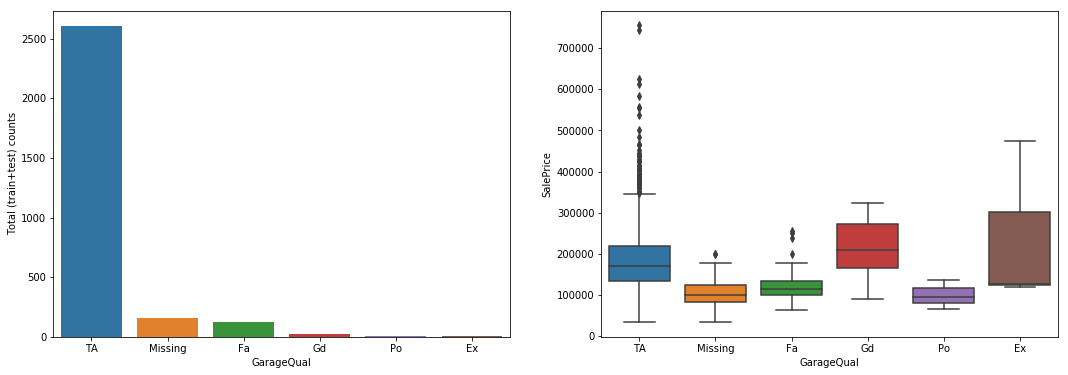

True

In [175]:
analyzefeature("GarageQual")

In [176]:
features_to_drop.append("GarageQual")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageCond    2760 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
GarageCond is categorical


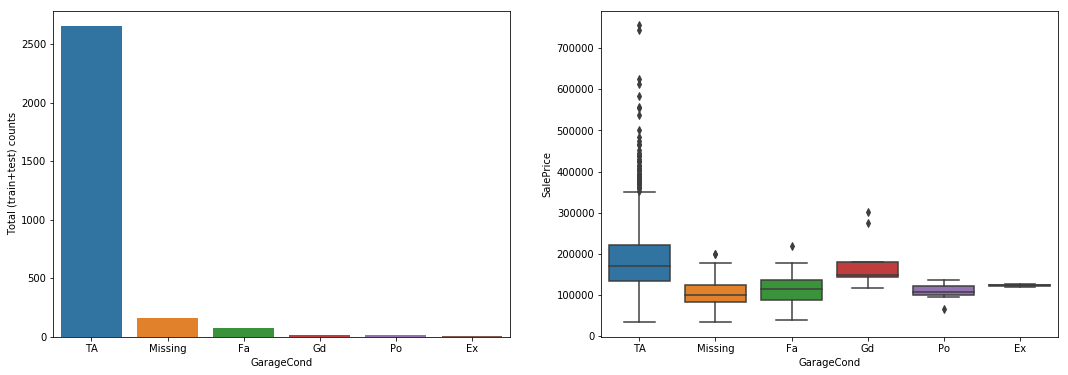

True

In [177]:
analyzefeature("GarageCond")

In [178]:
features_to_drop.append("GarageCond")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageArea    2918 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
GarageArea is continuous
            GarageArea  SalePrice
GarageArea    1.000000   0.623431
SalePrice     0.623431   1.000000


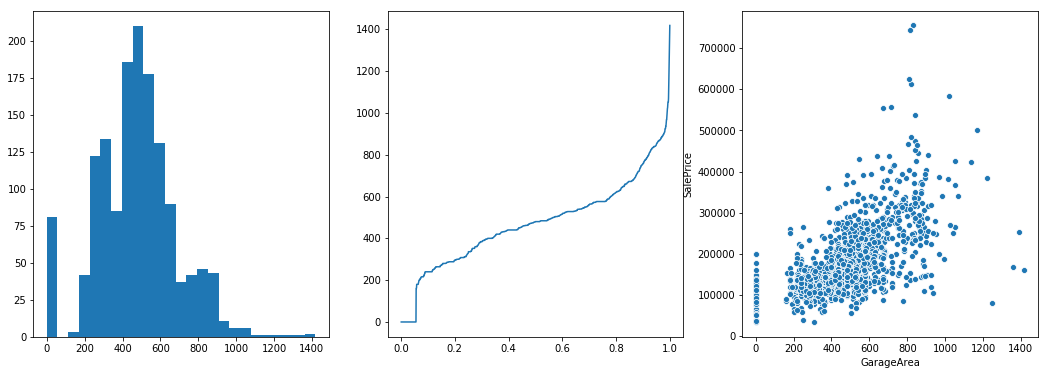

False

In [179]:
analyzefeature("GarageArea")

In [180]:
features_to_normalize.append("GarageArea")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarageYrBlt    2760 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
GarageYrBlt is continuous
             GarageYrBlt  SalePrice
GarageYrBlt     1.000000   0.486362
SalePrice       0.486362   1.000000


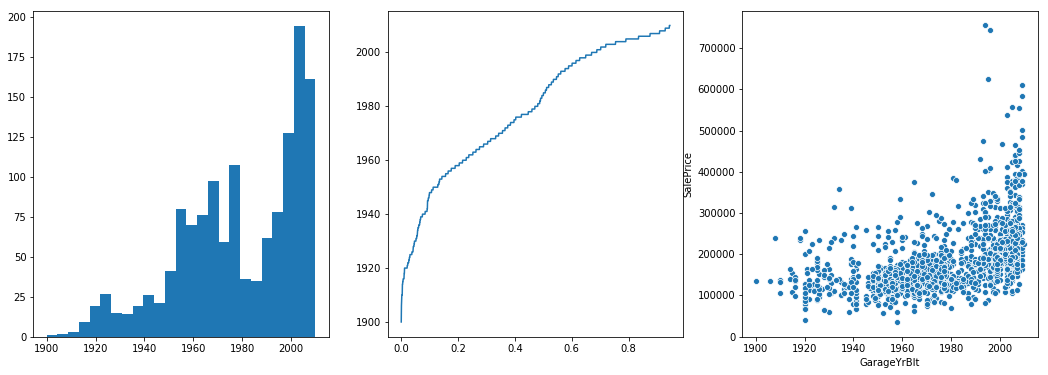

False

In [181]:
analyzefeature("GarageYrBlt")

Transformed year to age before

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
GarAge    2760 non-null float64
dtypes: float64(1)
memory usage: 45.6 KB
GarAge is continuous
             GarAge  SalePrice
GarAge     1.000000  -0.487069
SalePrice -0.487069   1.000000


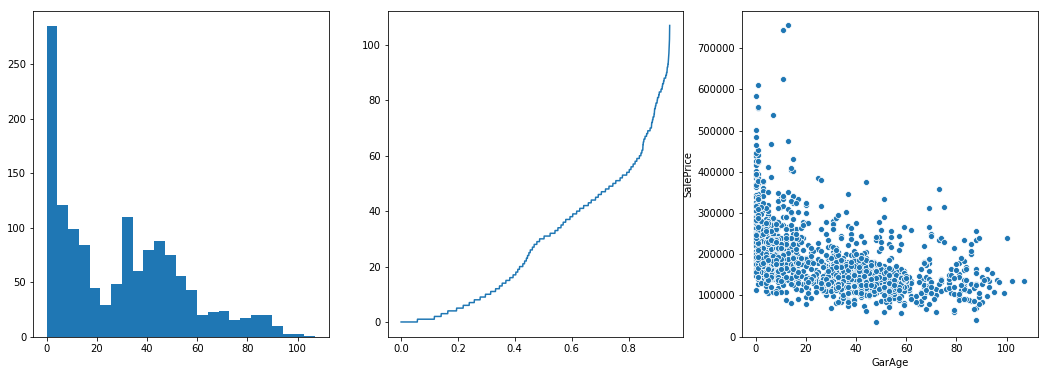

False

In [182]:
analyzefeature("GarAge")

### PavedDrive: Paved driveway

       Y	Paved 
       P	Partial Pavement
       N	Dirt/Gravel

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
PavedDrive    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
PavedDrive is categorical


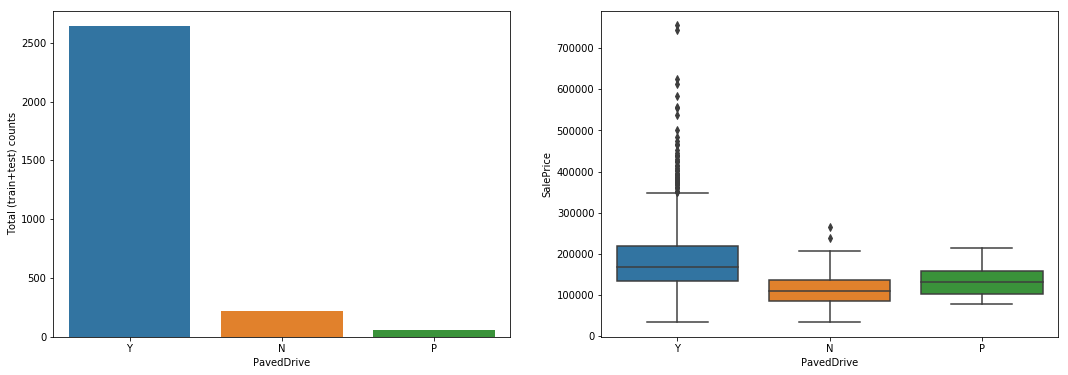

True

In [183]:
analyzefeature("PavedDrive")

In [184]:
features_to_drop.append("PavedDrive")

### Porch and Deck 
WoodDeckSF: Wood deck area in square feet

OpenPorchSF: Open porch area in square feet

EnclosedPorch: Enclosed porch area in square feet

3SsnPorch: Three season porch area in square feet

ScreenPorch: Screen porch area in square feet

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
WoodDeckSF    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
WoodDeckSF is continuous
            WoodDeckSF  SalePrice
WoodDeckSF    1.000000   0.324413
SalePrice     0.324413   1.000000


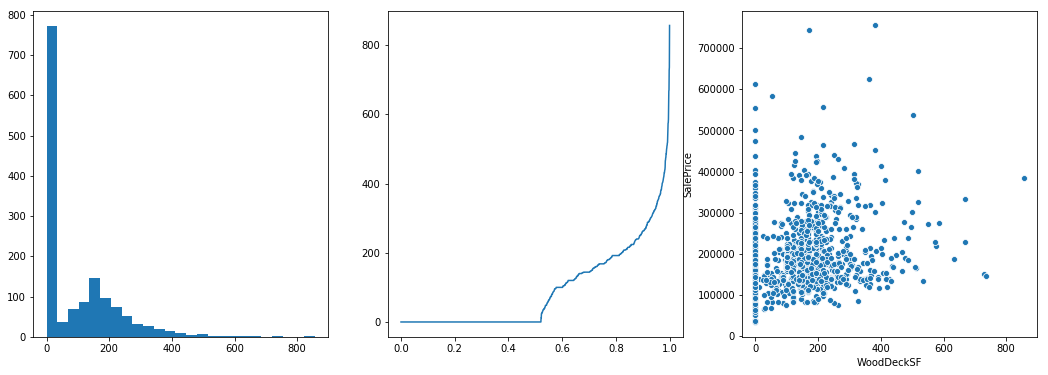

False

In [185]:
analyzefeature("WoodDeckSF")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
OpenPorchSF    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
OpenPorchSF is continuous
             OpenPorchSF  SalePrice
OpenPorchSF     1.000000   0.315856
SalePrice       0.315856   1.000000


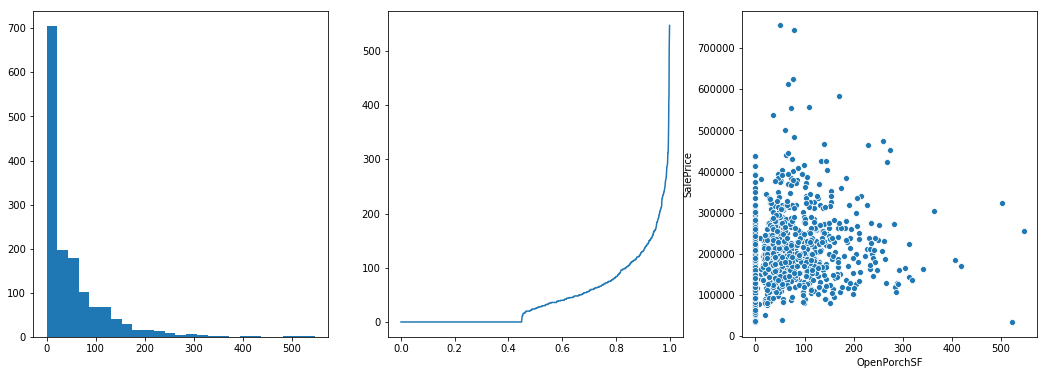

False

In [186]:
analyzefeature("OpenPorchSF")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
EnclosedPorch    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
EnclosedPorch is continuous
               EnclosedPorch  SalePrice
EnclosedPorch       1.000000  -0.128578
SalePrice          -0.128578   1.000000


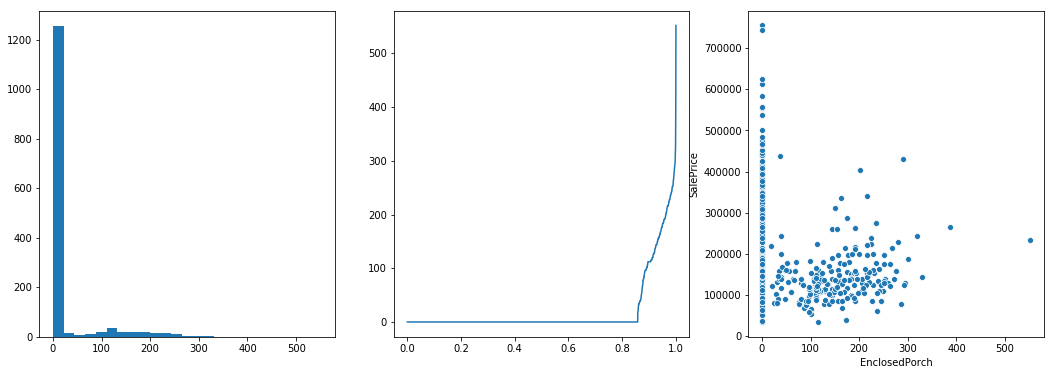

False

In [187]:
analyzefeature("EnclosedPorch")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
3SsnPorch    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
3SsnPorch is continuous
           3SsnPorch  SalePrice
3SsnPorch   1.000000   0.044584
SalePrice   0.044584   1.000000


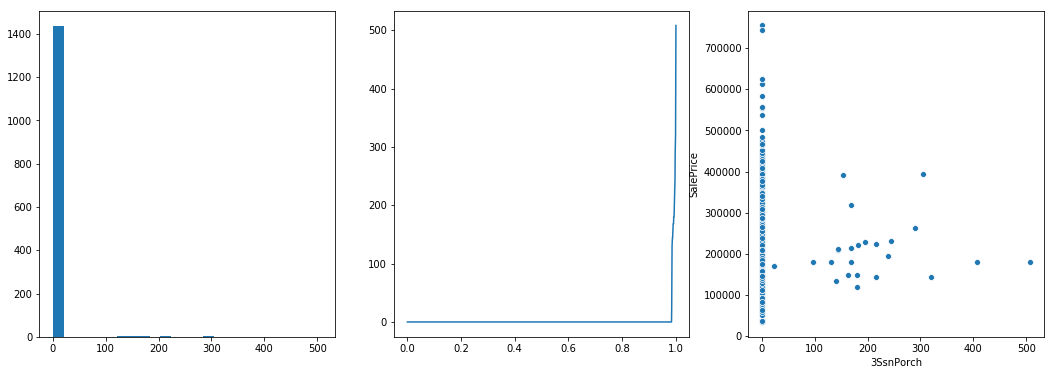

False

In [188]:
analyzefeature("3SsnPorch")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
ScreenPorch    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
ScreenPorch is continuous
             ScreenPorch  SalePrice
ScreenPorch     1.000000   0.111447
SalePrice       0.111447   1.000000


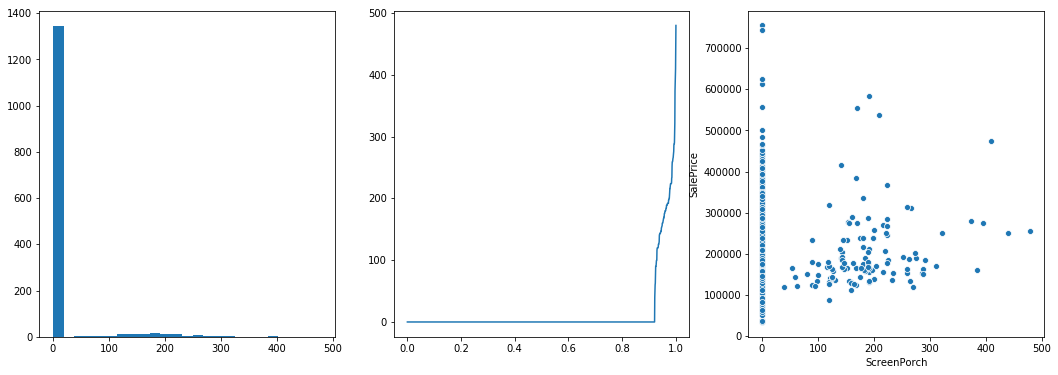

False

In [189]:
analyzefeature("ScreenPorch")

<Figure size 432x288 with 0 Axes>

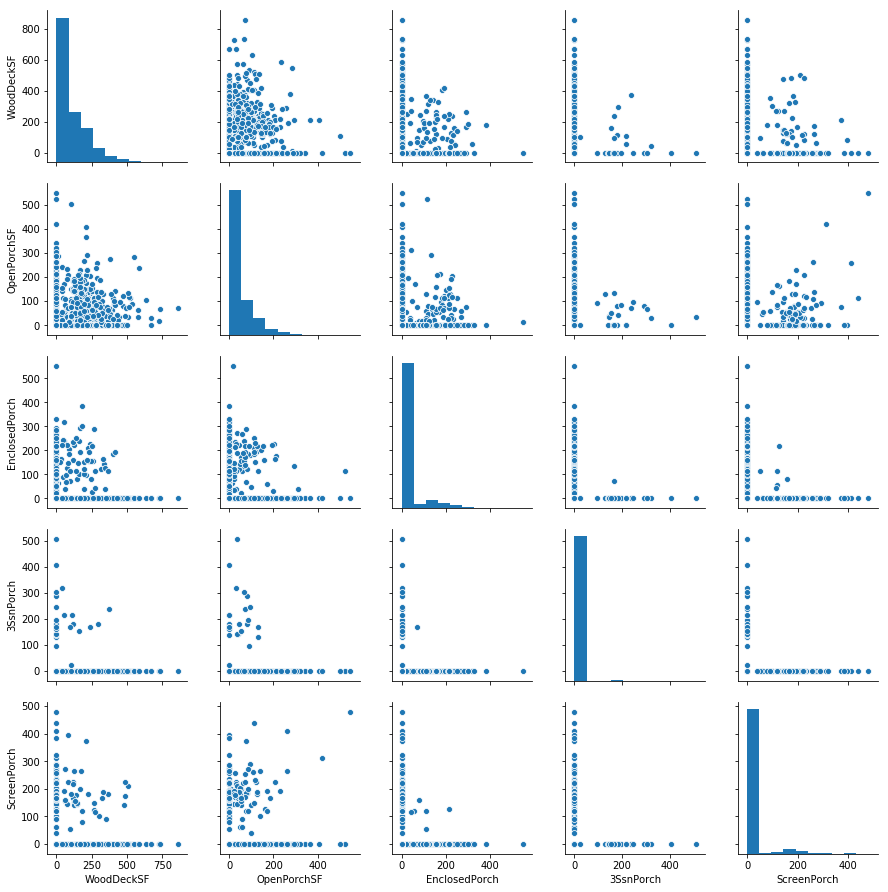

In [190]:
plt.figure()
sns.pairplot(housing_train[["WoodDeckSF", "OpenPorchSF", "EnclosedPorch", "3SsnPorch", "ScreenPorch"]])

In [191]:
housing_train["TotPorch"] = housing_train["OpenPorchSF"]+housing_train["EnclosedPorch"]+housing_train["3SsnPorch"]+housing_train["ScreenPorch"]
housing_test["TotPorch"] = housing_test["OpenPorchSF"]+housing_test["EnclosedPorch"]+housing_test["3SsnPorch"]+housing_test["ScreenPorch"]


<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
TotPorch    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
TotPorch is continuous
           TotPorch  SalePrice
TotPorch   1.000000   0.195739
SalePrice  0.195739   1.000000


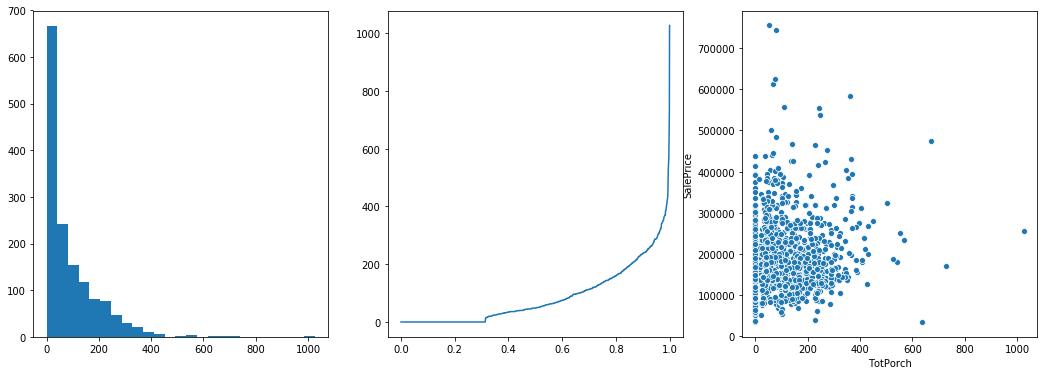

False

In [192]:
analyzefeature("TotPorch")

In [193]:
#create dummies for PorchType
housing_train["PorchType_Open"] = (housing_train["OpenPorchSF"]>0).astype(int)
housing_train["PorchType_Enclosed"] = (housing_train["EnclosedPorch"]>0).astype(int)
housing_train["PorchType_3Ssn"] = (housing_train["3SsnPorch"]>0).astype(int)
housing_train["PorchType_Screen"] = (housing_train["ScreenPorch"]>0).astype(int)

housing_test["PorchType_Open"] = (housing_test["OpenPorchSF"]>0).astype(int)
housing_test["PorchType_Enclosed"] = (housing_test["EnclosedPorch"]>0).astype(int)
housing_test["PorchType_3Ssn"] = (housing_test["3SsnPorch"]>0).astype(int)
housing_test["PorchType_Screen"] = (housing_test["ScreenPorch"]>0).astype(int)

In [194]:
housing_train["PorchType_Open"].describe()

count    1460.000000
mean        0.550685
std         0.497595
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         1.000000
Name: PorchType_Open, dtype: float64

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 4 columns):
PorchType_Open        1460 non-null int32
PorchType_Enclosed    1460 non-null int32
PorchType_3Ssn        1460 non-null int32
PorchType_Screen      1460 non-null int32
dtypes: int32(4)
memory usage: 74.2 KB


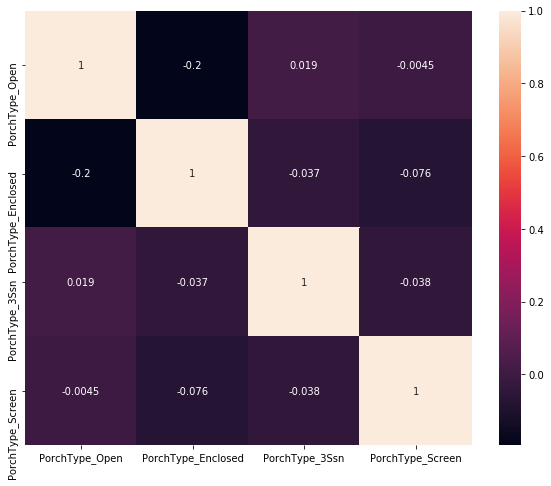

In [195]:
chk_corr_df = housing_train[["PorchType_Open", "PorchType_Enclosed", "PorchType_3Ssn", "PorchType_Screen"]]
chk_corr_df.info()
corr = chk_corr_df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=corr[corr.abs()>0], mask=np.isnan(corr[corr.abs()>0]))
plt.show()

Porch types are not independent. Let's keep them as dummy variables.

In [196]:
features_to_drop.append("OpenPorchSF")
features_to_drop.append("EnclosedPorch")
features_to_drop.append("3SsnPorch")
features_to_drop.append("ScreenPorch")

In [197]:
features_to_normalize.append("WoodDeckSF")
features_to_normalize.append("TotPorch")

### PoolArea

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
PoolArea    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
PoolArea is categorical


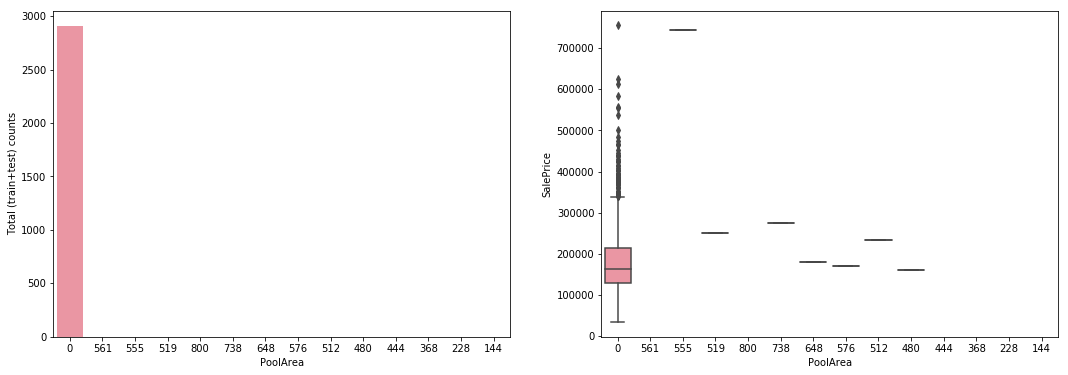

True

In [198]:
analyzefeature("PoolArea")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
PoolQC    10 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
PoolQC is categorical


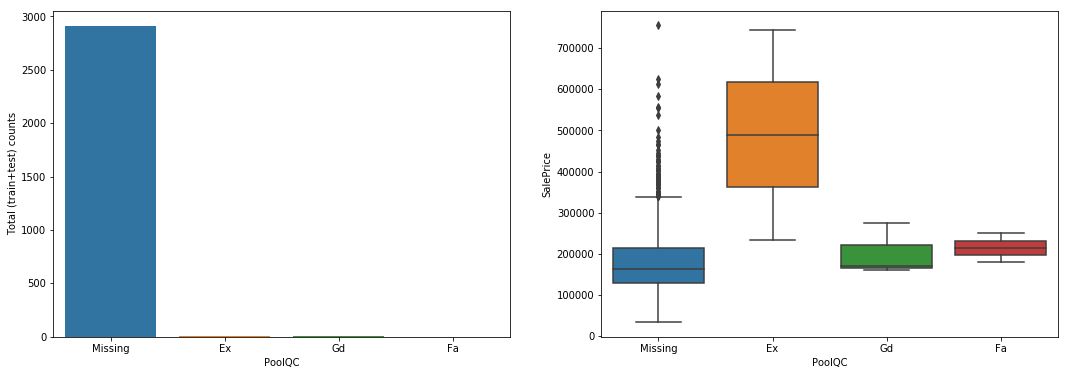

True

In [199]:
analyzefeature("PoolQC")

        SalePrice
PoolQC           
Ex         490000
Fa         215500
Gd         201990
[201701.99 345995.   490000.  ]
PoolQC
Ex        Ex
Fa    No_Bad
Gd    No_Bad
Name: SalePrice, dtype: category
Categories (2, object): [No_Bad < Ex]
Id
1    No_Bad
2    No_Bad
3    No_Bad
4    No_Bad
5    No_Bad
Name: PoolQC, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Pool_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Pool_tr is categorical


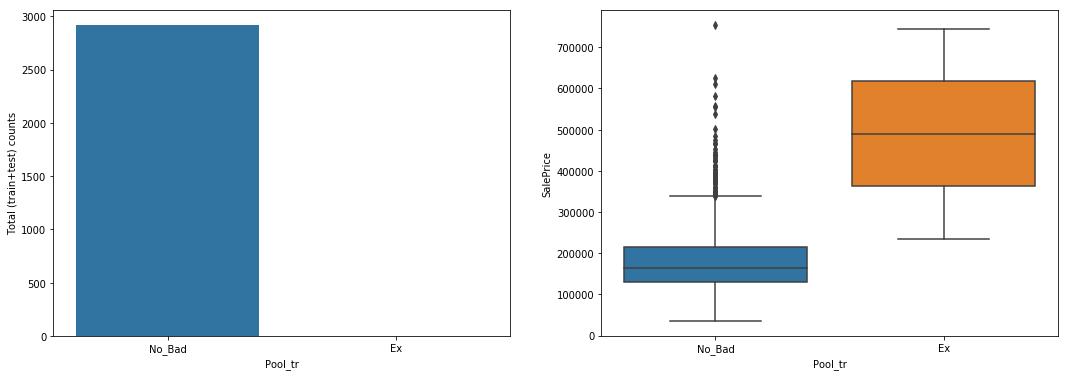

True

In [200]:
housing_train["Pool_tr"], housing_test["Pool_tr"]  = categorize("PoolQC", bns=2, lbls=['No_Bad', 'Ex'], fillna=True)
analyzefeature("Pool_tr")

In [201]:
features_to_dummies.append("Pool_tr")
features_to_drop.append("PoolQC")
features_to_drop.append("PoolArea")

### Fence Quality

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
Fence    571 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
Fence is categorical


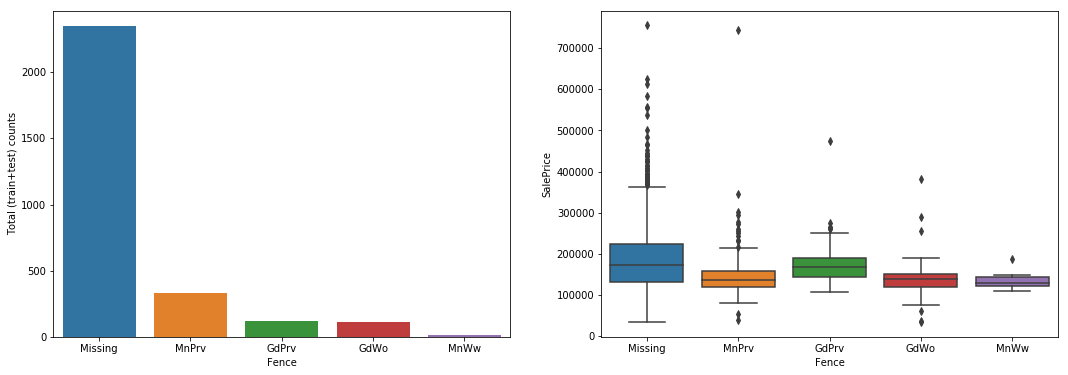

True

In [202]:
analyzefeature("Fence")

In [203]:
features_to_drop.append("Fence")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MiscFeature    105 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
MiscFeature is categorical


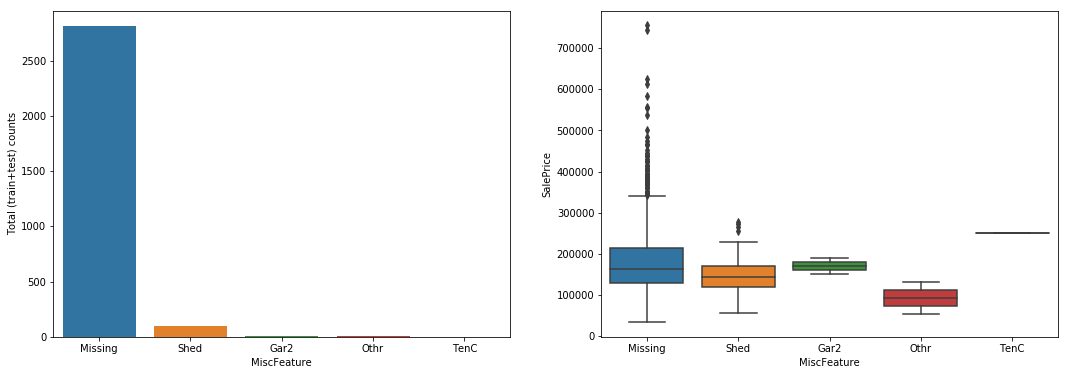

True

In [204]:
analyzefeature("MiscFeature")

In [205]:
features_to_drop.append("MiscFeature")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MiscVal    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
MiscVal is continuous
           MiscVal  SalePrice
MiscVal    1.00000   -0.02119
SalePrice -0.02119    1.00000


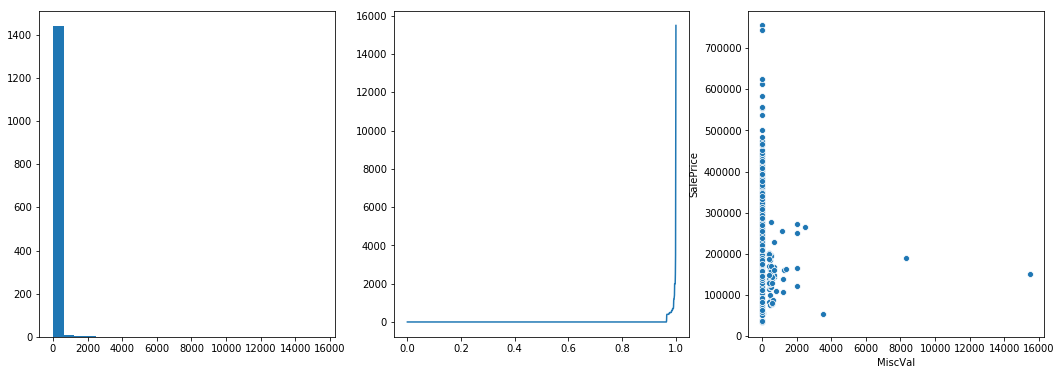

False

In [206]:
analyzefeature("MiscVal")

### New target feature: Remove Misc value from the sale price, then normalize with the living area

In [207]:
housing_train["SalePrice_Misc_SF"] = (housing_train["SalePrice"]-housing_train["MiscVal"])/housing_train["GrLivArea"]

### Month Sold

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
MoSold    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
MoSold is categorical


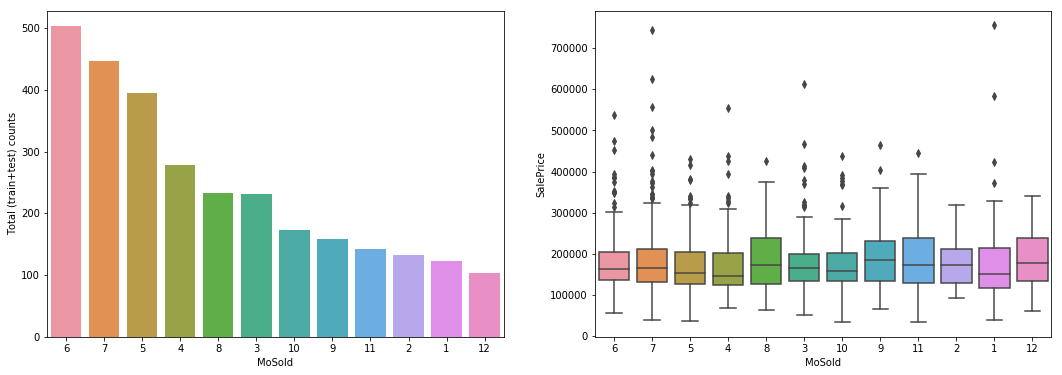

True

In [208]:
analyzefeature("MoSold")

In [209]:
features_to_drop.append("MoSold")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
YrSold    2919 non-null int64
dtypes: int64(1)
memory usage: 45.6 KB
YrSold is categorical


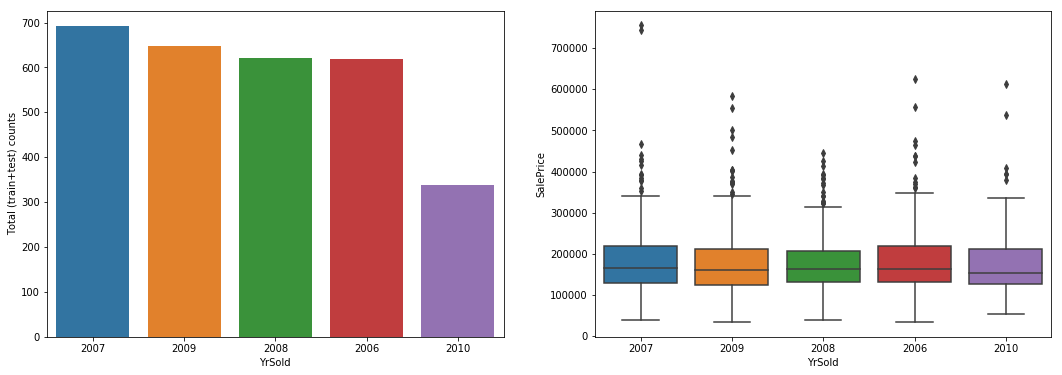

True

In [210]:
analyzefeature("YrSold")

### Type of sale

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
SaleType    2918 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
SaleType is categorical


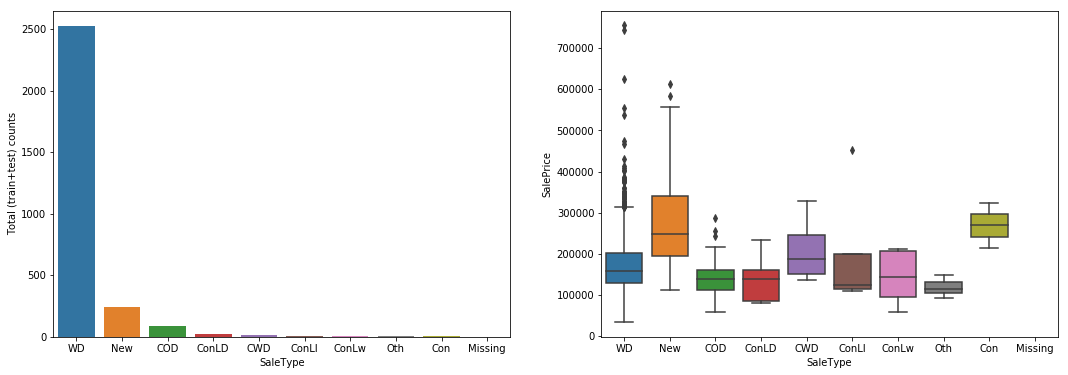

True

In [211]:
analyzefeature("SaleType")

              SalePrice
SaleType               
COD       143973.255814
CWD       210600.000000
Con       269600.000000
ConLD     138780.888889
ConLI     200390.000000
[119694.90458197 171548.4726776  223246.94535519 274945.41803279]
SaleType
COD      Typ1
CWD      Typ2
Con      Typ3
ConLD    Typ1
ConLI    Typ2
Name: SalePrice, dtype: category
Categories (3, object): [Typ1 < Typ2 < Typ3]
Id
1    Typ2
2    Typ2
3    Typ2
4    Typ2
5    Typ2
Name: SaleType, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
SaleType_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
SaleType_tr is categorical


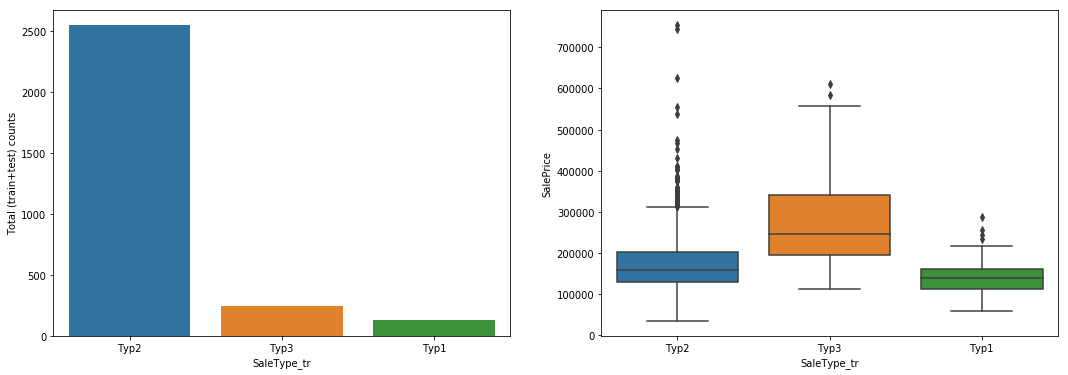

True

In [212]:
housing_train["SaleType_tr"], housing_test["SaleType_tr"]  = categorize("SaleType", bns=3, lbls=['Typ1', 'Typ2', 'Typ3'], fillna=True)
analyzefeature("SaleType_tr")

In [213]:
features_to_dummies.append("SaleType_tr")
features_to_drop.append("SaleType")

### SaleCondition

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
SaleCondition    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
SaleCondition is categorical


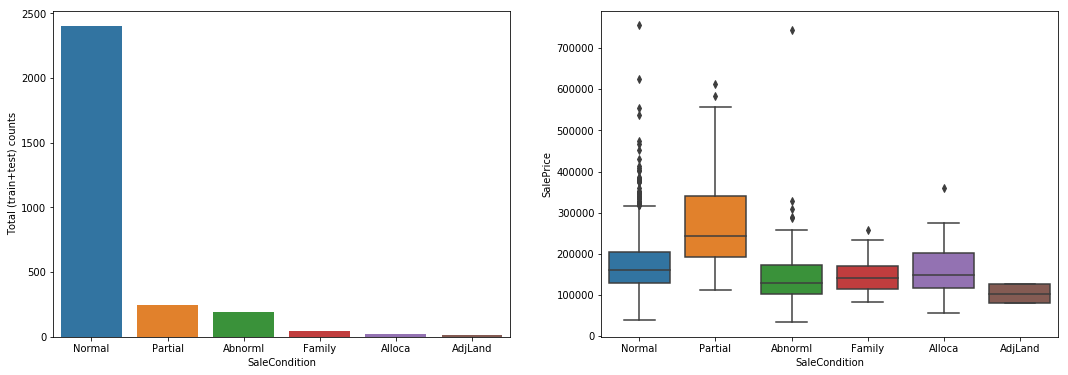

True

In [214]:
analyzefeature("SaleCondition")

                   SalePrice
SaleCondition               
Abnorml        146526.623762
AdjLand        104125.000000
Alloca         167377.416667
Family         149600.000000
Normal         175202.219533
[103956.833248 188208.376    272291.752   ]
SaleCondition
Abnorml    Typ1
AdjLand    Typ1
Alloca     Typ1
Family     Typ1
Normal     Typ1
Name: SalePrice, dtype: category
Categories (2, object): [Typ1 < Typ2]
Id
1    Typ1
2    Typ1
3    Typ1
4    Typ1
5    Typ1
Name: SaleCondition, dtype: object
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2919 entries, 1 to 2919
Data columns (total 1 columns):
SaleCond_tr    2919 non-null object
dtypes: object(1)
memory usage: 45.6+ KB
SaleCond_tr is categorical


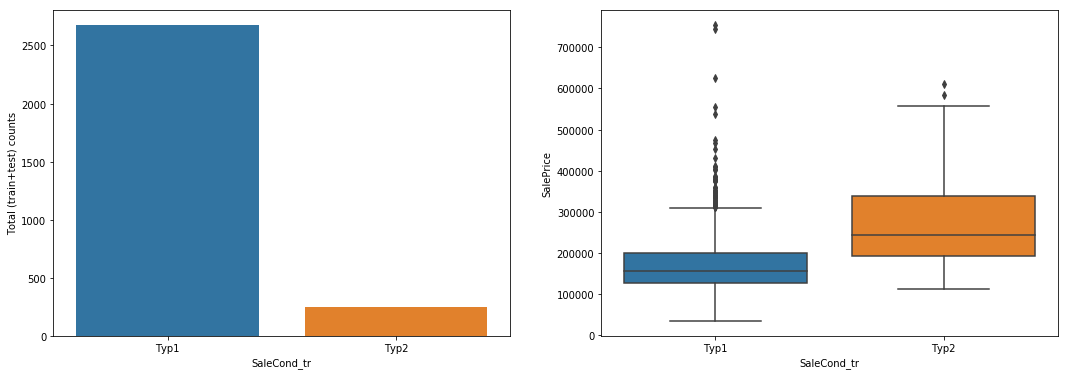

True

In [215]:
housing_train["SaleCond_tr"], housing_test["SaleCond_tr"]  = categorize("SaleCondition", bns=2, lbls=['Typ1', 'Typ2'], fillna=True)
analyzefeature("SaleCond_tr")

In [216]:
features_to_dummies.append("SaleCond_tr")
features_to_drop.append("SaleCondition")

# Feature Selection

### Select target feature:
Let's try the reduced price normalized with the living area. Delete these rows from the training set.

In [217]:
y_train = housing_train["SalePrice_Misc_SF"]
MiscVal_tr = housing_train["MiscVal"]
Area_tr = housing_train["GrLivArea"]
MiscVal_test = housing_test["MiscVal"]
Area_test = housing_test["GrLivArea"]

features_to_drop.append("MiscVal")
features_to_drop.append("GrLivArea")
housing_train = housing_train.drop(["SalePrice", "SalePrice_SF", "SalePrice_Misc_SF", ], axis=1)

In [218]:
print(features_to_dummies)

['MSZoning_tr', 'Alley', 'LotShape_tr', 'Neighborhood_tr', 'Condition', 'HouseStyle_tr', 'Ext1_tr', 'Ext2_tr', 'MasVnrType_tr', 'ExterQual', 'ExterCond_tr', 'Foundation_tr', 'BsmtQual_tr', 'BsmtExposure_tr', 'BsmtFinType1_tr', 'HeatingQC_tr', 'CentralAir', 'Electrical_tr', 'TotalBath_tr', 'TotRooms_tr', 'KitchenQual_tr', 'Fireplaces_tr', 'GarageFinish', 'GarageCars_tr', 'Pool_tr', 'SaleType_tr', 'SaleCond_tr']


In [219]:
print(features_to_normalize)

['LogLotFrontage', 'LogLotArea', 'OverallQual', 'Age', 'RenAge', 'MasVnrArea_log', 'BsmtFinSF1_log', 'BsmtUnfSF_log', 'TotalBsmtSF_log', 'GarageArea', 'WoodDeckSF', 'TotPorch']


In [220]:
print(features_to_drop)

['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'LotShape', 'LandContour', 'LandSlope', 'Utilities', 'LotConfig', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'GarageYrBlt', 'GarAge', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'TotalBath', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'TotRmsAbvGrd', 'BedroomAbvGr_tr', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageCars', 'GarageQual', 'GarageCond', 'PavedDrive', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolQC', 'PoolArea', 'Fence', 'MiscFeature', 'MoSold', 'SaleType', 'SaleCondition', 'MiscVal', 'GrLivArea

In [221]:
X_train = housing_train.drop(features_to_drop, axis=1)
print(X_train.info())
X_test = housing_test.drop(features_to_drop, axis=1)
print(X_test.info())


<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 45 columns):
Alley                 1460 non-null object
OverallQual           1460 non-null int64
ExterQual             1460 non-null object
BsmtFinSF2            1460 non-null int64
CentralAir            1460 non-null object
GarageFinish          1379 non-null object
GarageArea            1460 non-null int64
WoodDeckSF            1460 non-null int64
YrSold                1460 non-null int64
MSZoning_tr           1460 non-null object
LogLotFrontage        1201 non-null float64
LogLotArea            1460 non-null float64
LotShape_tr           1460 non-null object
Neighborhood_tr       1460 non-null object
Condition             1460 non-null float64
HouseStyle_tr         1460 non-null object
Age                   1460 non-null int64
RenAge                1460 non-null int64
Ext1_tr               1460 non-null object
Ext2_tr               1460 non-null object
MasVnrType_tr         1460 non-null o

In [222]:
# Convert dummy features to string
def conv_to_dum(df, cols_to_dummies):
    df[cols_to_dummies] = df[cols_to_dummies].apply(lambda row: row.astype(str))
    # Get dummies for specific features
    dummies = pd.get_dummies(df[cols_to_dummies])
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(cols_to_dummies, axis=1)
    return df

In [223]:
X_train = conv_to_dum(X_train, features_to_dummies)
X_test = conv_to_dum(X_test, features_to_dummies)

In [224]:
print(X_train.info())
print(X_test.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 97 columns):
OverallQual               1460 non-null int64
BsmtFinSF2                1460 non-null int64
GarageArea                1460 non-null int64
WoodDeckSF                1460 non-null int64
YrSold                    1460 non-null int64
LogLotFrontage            1201 non-null float64
LogLotArea                1460 non-null float64
Age                       1460 non-null int64
RenAge                    1460 non-null int64
MasVnrArea_log            591 non-null float64
BsmtFinSF1_log            1460 non-null float64
BsmtUnfSF_log             1460 non-null float64
TotalBsmtSF_log           1460 non-null float64
TotPorch                  1460 non-null int64
PorchType_Open            1460 non-null int32
PorchType_Enclosed        1460 non-null int32
PorchType_3Ssn            1460 non-null int32
PorchType_Screen          1460 non-null int32
MSZoning_tr_C             1460 non-null uint8
MSZoning

## Normalize continuous features

In [225]:
def feature_scale(df, cols_to_normalize):
    scaled = scale(df[cols_to_normalize])
    column_names = [s + "_sc" for s in cols_to_normalize]
    scaled_df = pd.DataFrame(scaled, columns=column_names, index=df.index)
    df = pd.concat([df, scaled_df], axis=1)
    df = df.drop(cols_to_normalize, axis=1)
    return df

In [226]:
X_train_sc = feature_scale(X_train, features_to_normalize) 
X_test_sc = feature_scale(X_test, features_to_normalize)

C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  
C:\Program Files\Python36\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by the scale function.
  


In [227]:
scaled_features = [s + "_sc" for s in features_to_normalize]
X_train_sc.info()
X_train_sc[scaled_features].describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 97 columns):
BsmtFinSF2                1460 non-null int64
YrSold                    1460 non-null int64
PorchType_Open            1460 non-null int32
PorchType_Enclosed        1460 non-null int32
PorchType_3Ssn            1460 non-null int32
PorchType_Screen          1460 non-null int32
MSZoning_tr_C             1460 non-null uint8
MSZoning_tr_FV            1460 non-null uint8
MSZoning_tr_RL            1460 non-null uint8
MSZoning_tr_RMH           1460 non-null uint8
Alley_Grvl                1460 non-null uint8
Alley_Missing             1460 non-null uint8
Alley_Pave                1460 non-null uint8
LotShape_tr_IR            1460 non-null uint8
LotShape_tr_Reg           1460 non-null uint8
Neighborhood_tr_Med       1460 non-null uint8
Neighborhood_tr_Poor      1460 non-null uint8
Neighborhood_tr_Rich      1460 non-null uint8
Condition_-1.0            1460 non-null uint8
Condition_-2.0     

LogLotFrontage_sc  LogLotArea_sc  OverallQual_sc        Age_sc  \
count       1.201000e+03   1.460000e+03    1.460000e+03  1.460000e+03   
mean       -2.360587e-15   2.457699e-16    1.387018e-16  5.110068e-17   
std         1.000417e+00   1.000343e+00    1.000343e+00  1.000343e+00   
min        -3.250975e+00  -3.751843e+00   -3.688413e+00 -1.208604e+00   
25%        -3.218609e-01  -3.500535e-01   -7.951515e-01 -9.440523e-01   
50%         1.220907e-01   8.881828e-02   -7.183611e-02 -5.118902e-02   
75%         5.415182e-01   4.795388e-01    6.514792e-01  5.771222e-01   
max         4.409641e+00   6.125793e+00    2.821425e+00  3.288781e+00   

          RenAge_sc  MasVnrArea_log_sc  BsmtFinSF1_log_sc  BsmtUnfSF_log_sc  \
count  1.460000e+03       5.910000e+02       1.460000e+03      1.460000e+03   
mean   1.946692e-17      -3.606816e-16      -8.760116e-17      7.884104e-16   
std    1.000343e+00       1.000847e+00       1.000343e+00      1.000343e+00   
min   -1.160729e+00      -5.974809e+00      -1.417162e+00     -2.828173e+00   
25%   -9.184057e-01      -5.719178e-01      -1.417162e+00     -2.532842e-01   
50%   -4.337589e-01       9.760883e-02       5.816909e-01      2.669995e-01   
75%    8.747875e-01       6.546223e-01       7.794902e-01      6.264363e-01   
max    1.795616e+00       2.457169e+00       1.440829e+00      1.351889e+00   

       TotalBsmtSF_log_sc  GarageArea_sc  WoodDeckSF_sc   TotPorch_sc  
count        1.460000e+03   1.460000e+03   1.460000e+03  1.460000e+03  
mean        -7.640768e-16  -1.216683e-17   5.596741e-17 -4.136721e-17  
std          1.000343e+00   1.000343e+00   1.000343e+00  1.000343e+00  
min         -5.095641e+00  -2.212963e+00  -7.521758e-01 -8.281630e-01  
25%         -2.602813e-01  -6.479160e-01  -7.521758e-01 -8.281630e-01  
50%          9.123792e-02   3.284429e-02  -7.521758e-01 -3.716911e-01  
75%          5.220640e-01   4.820057e-01   5.886506e-01  4.651741e-01  
max          2.997678e+00   4.421526e+00   6.087635e+00  8.938434e+00

In [228]:
print(X_train_sc.iloc[:,50:].info())
print(X_test_sc.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 47 columns):
BsmtExposure_tr_nan       1460 non-null uint8
BsmtFinType1_tr_Avg       1460 non-null uint8
BsmtFinType1_tr_Good      1460 non-null uint8
BsmtFinType1_tr_nan       1460 non-null uint8
HeatingQC_tr_Avg          1460 non-null uint8
HeatingQC_tr_Ex           1460 non-null uint8
CentralAir_N              1460 non-null uint8
CentralAir_Y              1460 non-null uint8
Electrical_tr_Fuse        1460 non-null uint8
Electrical_tr_SBrkr       1460 non-null uint8
TotalBath_tr_Avg          1460 non-null uint8
TotalBath_tr_Few          1460 non-null uint8
TotalBath_tr_Many         1460 non-null uint8
TotRooms_tr_Avg           1460 non-null uint8
TotRooms_tr_Few           1460 non-null uint8
TotRooms_tr_Many          1460 non-null uint8
KitchenQual_tr_Avg        1460 non-null uint8
KitchenQual_tr_Good       1460 non-null uint8
KitchenQual_tr_Poor       1460 non-null uint8
Fireplaces_tr_None 

## Impute missing values

In [229]:
# Impute missing values with mean: Note that only continuous values may be missing: after normalization: zeros. 
X_train_sc.fillna(0, inplace=True)
X_test_sc.fillna(0, inplace=True)

In [230]:
X_train_sc.iloc[:,100:].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Empty DataFrame

# Train model

### Split the train data to train and cv sets

In [231]:
X_tr, X_cv, y_tr, y_cv = train_test_split(X_train_sc, y_train, test_size=0.2, random_state=42)

In [232]:
# =================Train a random forest model on the training data =====================
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_tr, y_tr)

# prediction and scoring
y_pred = rf.predict(X_cv)
ind_tr = np.array(X_tr.index)
ind_cv = np.array(X_cv.index)
y_pred_tot = y_pred*Area_tr[ind_cv]+MiscVal_tr[ind_cv]
y_cv_tot = y_cv *Area_tr[ind_cv]+MiscVal_tr[ind_cv]

score2 = np.sqrt(np.sum((np.log(y_pred_tot) - np.log(y_cv_tot))**2))
print(score2)
print(rf.score(X_cv, y_cv))

2.9176375116596915
0.6846032485753284


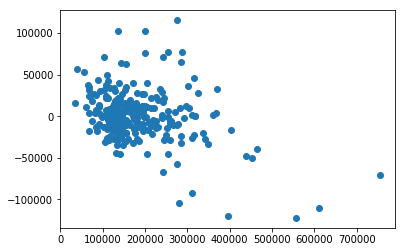

In [233]:
plt.figure()
plt.scatter(y_cv_tot, y_pred_tot-y_cv_tot)

### Feature importances

Age_sc                0.279331
BsmtFinSF1_log_sc     0.090222
HouseStyle_tr_1       0.079460
OverallQual_sc        0.064095
TotalBsmtSF_log_sc    0.059738
dtype: float64


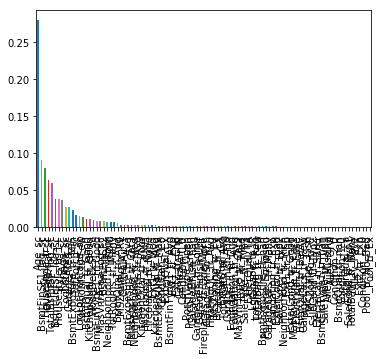

In [234]:
features = X_train_sc.columns
feature_imp = pd.Series(rf.feature_importances_,
                        index=features).sort_values(ascending=False)
print(feature_imp.head())
plt.figure(2)
feature_imp.plot.bar()